In [3]:
#Setup and Data Loading
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import json
import numpy as np
import requests

# Define file paths
csv_file_path = 'ICRISAT District Level Data.csv'

# Load the dataset
df = pd.read_csv(csv_file_path, encoding='iso-8859-1')

In [4]:
# Check columns & missing data
df.columns = (df.columns.str.strip().str.lower()
              .str.replace(r'\s+', '_', regex=True)
              .str.replace(r'[^\w_]', '', regex=True))
print("Column names standardized.")
df.info()
print("\nMissing data percentage per column:")
print(df.isna().mean().sort_values(ascending=False))

Column names standardized.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12803 entries, 0 to 12802
Columns: 107 entries, dist_code to autumn_octdec_windspeed_meter_per_second
dtypes: float64(102), int64(3), object(2)
memory usage: 10.5+ MB

Missing data percentage per column:
total_agricultural_labour_population_1000_number    0.888464
gross_irrigated_area_1000_ha                        0.090057
sept_windspeed_meter_per_second                     0.054440
aug_windspeed_meter_per_second                      0.054440
july_windspeed_meter_per_second                     0.054440
                                                      ...   
state_code                                          0.000000
dist_name                                           0.000000
year                                                0.000000
state_name                                          0.000000
dist_code                                           0.000000
Length: 107, dtype: float64


In [5]:
# Identify columns with >30% missing
missing_percentage = df.isna().mean()
cols_to_drop = missing_percentage[missing_percentage > 0.3].index.tolist()

if cols_to_drop:
    print(f"\nDropping columns with >30% missing data: {cols_to_drop}")
    df.drop(columns=cols_to_drop, inplace=True)
else:
    print("\nNo columns with >30% missing data found.")

# Group-mean imputation per state for numerical columns
numerical_cols = df.select_dtypes(include=np.number).columns
print("\nPerforming group-mean imputation per state for numerical columns...")
for col in numerical_cols:
     if df[col].isnull().any():
        df[col] = df.groupby('state_name')[col].transform(lambda x: x.fillna(x.mean()))

# Impute any remaining numerical NaNs with the overall mean (for columns without state groups or remaining NaNs)
df.fillna(df.mean(numeric_only=True), inplace=True)

# For object type columns, impute with mode
object_cols = df.select_dtypes(include='object').columns
for col in object_cols:
    if df[col].isnull().any():
        df[col].fillna(df[col].mode()[0], inplace=True)

print("\nMissing data after imputation:")
print(df.isna().sum().sum()) # Check total number of missing values


Dropping columns with >30% missing data: ['total_agricultural_labour_population_1000_number']

Performing group-mean imputation per state for numerical columns...

Missing data after imputation:
0


In [6]:
# Check data consistency
# Confirm year is integer and properly sorted.
if 'year' in df.columns:
    df['year'] = pd.to_numeric(df['year'], errors='coerce')
    df.sort_values(by=['dist_code', 'year'], inplace=True)
    print("\n'year' column converted to numeric and data sorted by district and year.")
else:
    print("\n'year' column not found.")

# Confirm no duplicate district-year pairs.
if 'dist_code' in df.columns and 'year' in df.columns:
    duplicates = df.duplicated(subset=['dist_code', 'year']).sum()
    if duplicates == 0:
        print("No duplicate 'dist_code' and 'year' pairs found.")
    else:
        print(f"Warning: {duplicates} duplicate 'dist_code' and 'year' pairs found. Removing duplicates.")
        df.drop_duplicates(subset=['dist_code', 'year'], inplace=True)
else:
    print("\n'dist_code' or 'year' column not found. Cannot check for duplicate district-year pairs.")

df.info()


'year' column converted to numeric and data sorted by district and year.
No duplicate 'dist_code' and 'year' pairs found.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12803 entries, 0 to 12802
Columns: 106 entries, dist_code to autumn_octdec_windspeed_meter_per_second
dtypes: float64(101), int64(3), object(2)
memory usage: 10.4+ MB


In [7]:
#Data Cleaning and Preprocessing
# Standardize column names robustly
# Moved to the beginning of the notebook:
# df.columns = (df.columns.str.strip().str.lower()
#               .str.replace(r'[\s\.\(\)]+', '_', regex=True)
#               .str.replace(r'_+', '_', regex=True)
#               .str.strip('_'))

# Impute missing numerical values using the mean of their state
numerical_cols = df.select_dtypes(include=['number']).columns
for col in numerical_cols:
     if df[col].isnull().any():
        df[col] = df.groupby('state_name')[col].transform(lambda x: x.fillna(x.mean()))
# Replace df.fillna(df.mean(numeric_only=True), inplace=True) with assignment
df = df.fillna(df.mean(numeric_only=True))

# Remove duplicates
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12803 entries, 0 to 12802
Columns: 106 entries, dist_code to autumn_octdec_windspeed_meter_per_second
dtypes: float64(101), int64(3), object(2)
memory usage: 10.4+ MB


In [8]:
# Feature Engineering
# Calculate Irrigation Ratio
# Ensure 'gross_cropped_area_1000_ha' is not zero to avoid division by zero
epsilon = 1e-6
if 'gross_irrigated_area_1000_ha' in df.columns and 'gross_cropped_area_1000_ha' in df.columns:
    df['irrigation_ratio'] = (df['gross_irrigated_area_1000_ha'] / (df['gross_cropped_area_1000_ha'] + epsilon)).fillna(0)
    print("New feature 'irrigation_ratio' created.")
else:
    print("Required columns for 'irrigation_ratio' not found.")
    df['irrigation_ratio'] = 0 # Add column with default value if source columns are missing


# Calculate Yield per Ton of Fertilizer
if 'rice_yield_kg_per_ha' in df.columns and 'total_fertiliser_consumption_tons' in df.columns:
    df['yield_per_fertilizer'] = df['rice_yield_kg_per_ha'] / (df['total_fertiliser_consumption_tons'] + epsilon)
     # Clean up any resulting infinite values
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    # Replace df['yield_per_fertilizer'].fillna(0, inplace=True) with assignment
    df['yield_per_fertilizer'] = df['yield_per_fertilizer'].fillna(0)
    print("New feature 'yield_per_fertilizer' created.")
else:
    print("Required columns for 'yield_per_fertilizer' not found.")
    df['yield_per_fertilizer'] = 0 # Add column with default value if source columns are missing


# Create annual climate variables from monthly data
temp_cols = [col for col in df.columns if 'maximum_temperature' in col and not any(x in col for x in ['winter', 'summer', 'rainy', 'post-monsoon'])]
precip_cols = [col for col in df.columns if 'percipitation_millimeters' in col and not any(x in col for x in ['winter', 'summer', 'rainy', 'post-monsoon'])] # Corrected 'percipitation' spelling

if temp_cols:
    df['temperature_c'] = df[temp_cols].mean(axis=1)
    print("Created 'temperature_c' from monthly data.")
else:
    print("Monthly temperature columns not found for 'temperature_c'.")
    df['temperature_c'] = 0 # Add column with default value if source columns are missing


if precip_cols:
    df['percipitation_mm'] = df[precip_cols].sum(axis=1)
    print("Created 'percipitation_mm' from monthly data.")
else:
    print("Monthly precipitation columns not found for 'percipitation_mm'.")
    df['percipitation_mm'] = 0 # Add column with default value if source columns are missing

New feature 'irrigation_ratio' created.
New feature 'yield_per_fertilizer' created.
Created 'temperature_c' from monthly data.
Created 'percipitation_mm' from monthly data.


['dist_code', 'year', 'state_code', 'state_name', 'dist_name', 'rice_area_1000_ha', 'rice_production_1000_tons', 'rice_yield_kg_per_ha', 'pearl_millet_area_1000_ha', 'pearl_millet_production_1000_tons', 'pearl_millet_yield_kg_per_ha', 'chickpea_area_1000_ha', 'chickpea_production_1000_tons', 'chickpea_yield_kg_per_ha', 'groundnut_area_1000_ha', 'groundnut_production_1000_tons', 'groundnut_yield_kg_per_ha', 'sugarcane_area_1000_ha', 'sugarcane_production_1000_tons', 'sugarcane_yield_kg_per_ha', 'gross_cropped_area_1000_ha', 'nitrogen_consumption_tons', 'phosphate_consumption_tons', 'potash_consumption_tons', 'total_fertiliser_consumption_tons', 'gross_irrigated_area_1000_ha', 'january_maximum_temperature_centigrate', 'february_maximum_temperature_centigrate', 'march_maximum_temperature_centigrate', 'april_maximum_temperature_centigrate', 'may_maximum_temperature_centigrate', 'june_maximum_temperature_centigrate', 'july_maximum_temperature_centigrate', 'august_maximum_temperature_centigr

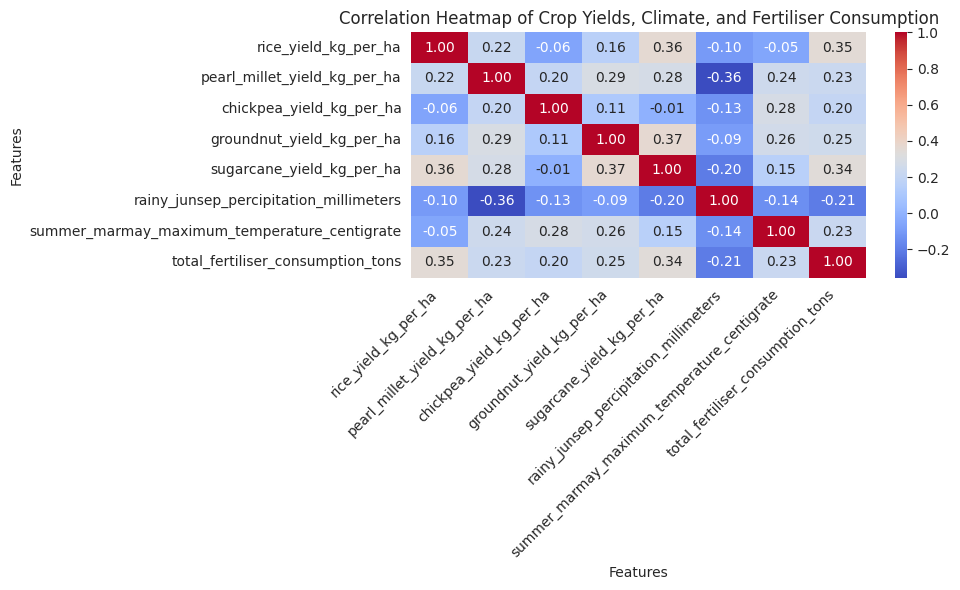

In [ ]:
# Print all columns to identify the correct names
print(df.columns.tolist())

# Select columns for the correlation heatmap
heatmap_cols = [
    'rice_yield_kg_per_ha',
    'pearl_millet_yield_kg_per_ha',
    'chickpea_yield_kg_per_ha',
    'groundnut_yield_kg_per_ha',
    'sugarcane_yield_kg_per_ha',
    'rainy_junsep_percipitation_millimeters', # Corrected column name
    'summer_marmay_maximum_temperature_centigrate', # Corrected column name
    'total_fertiliser_consumption_tons'
]

# Create a subset of the dataframe with these columns
df_heatmap = df[heatmap_cols]

# Calculate the correlation matrix
correlation_matrix = df_heatmap.corr()

# Create the heatmap
plt.figure(figsize=(10, 6)) # Preferred figure size
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Crop Yields, Climate, and Fertiliser Consumption') # Clear title
plt.xlabel('Features') # Clear axis label
plt.ylabel('Features') # Clear axis label
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout() # Preferred layout
plt.show()

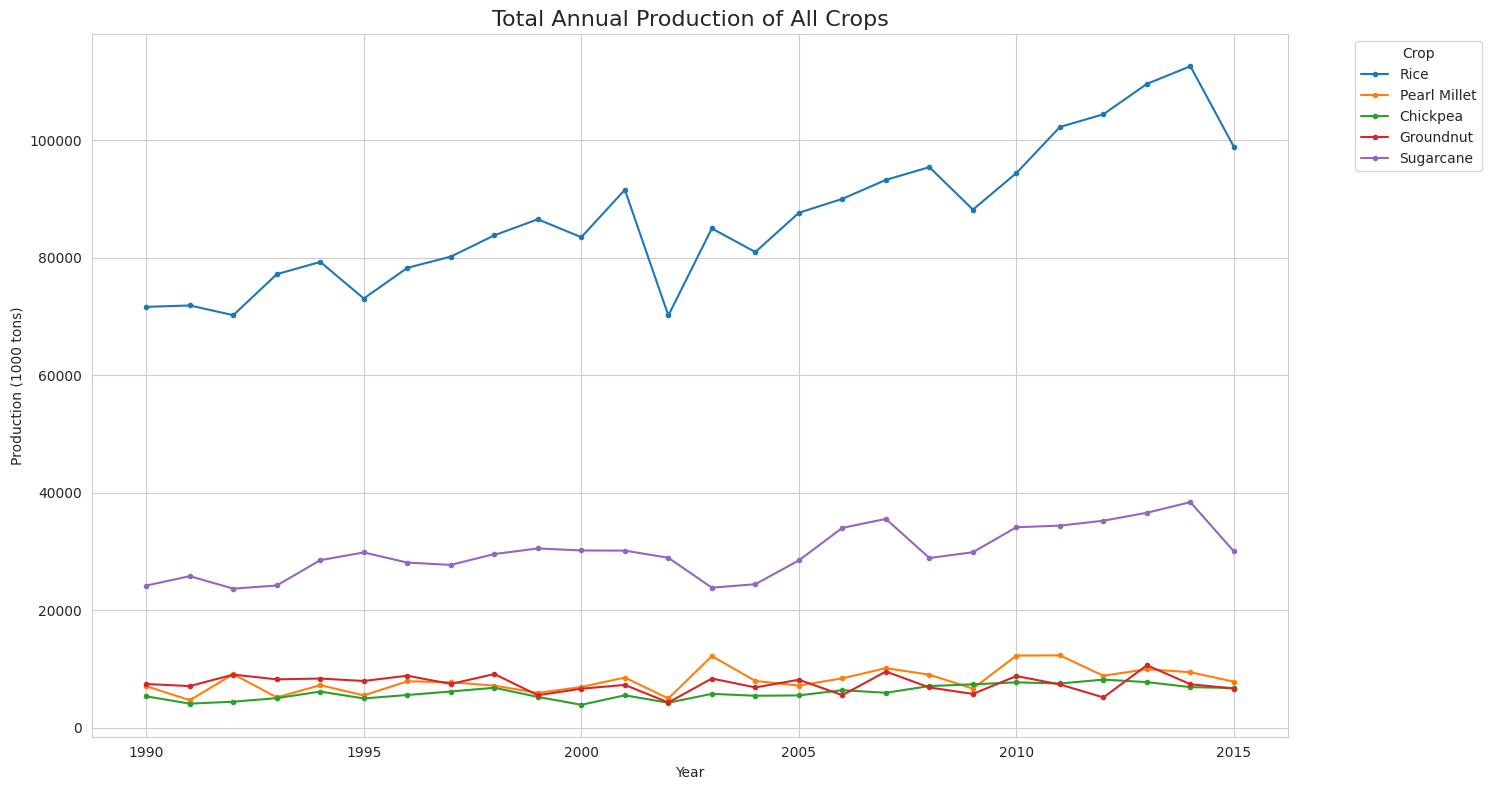

In [ ]:
# Time Series Analysis
plt.figure(figsize=(15, 8))

# Identify all production columns
production_cols = [col for col in df.columns if '_production_1000_tons' in col]

# Plot production data for all identified crops
for col in production_cols:
    df.groupby('year')[col].sum().plot(label=col.replace('_production_1000_tons', '').replace('_', ' ').title(), marker='.')

plt.title('Total Annual Production of All Crops', fontsize=16)
plt.ylabel('Production (1000 tons)')
plt.xlabel('Year')
plt.legend(title='Crop', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

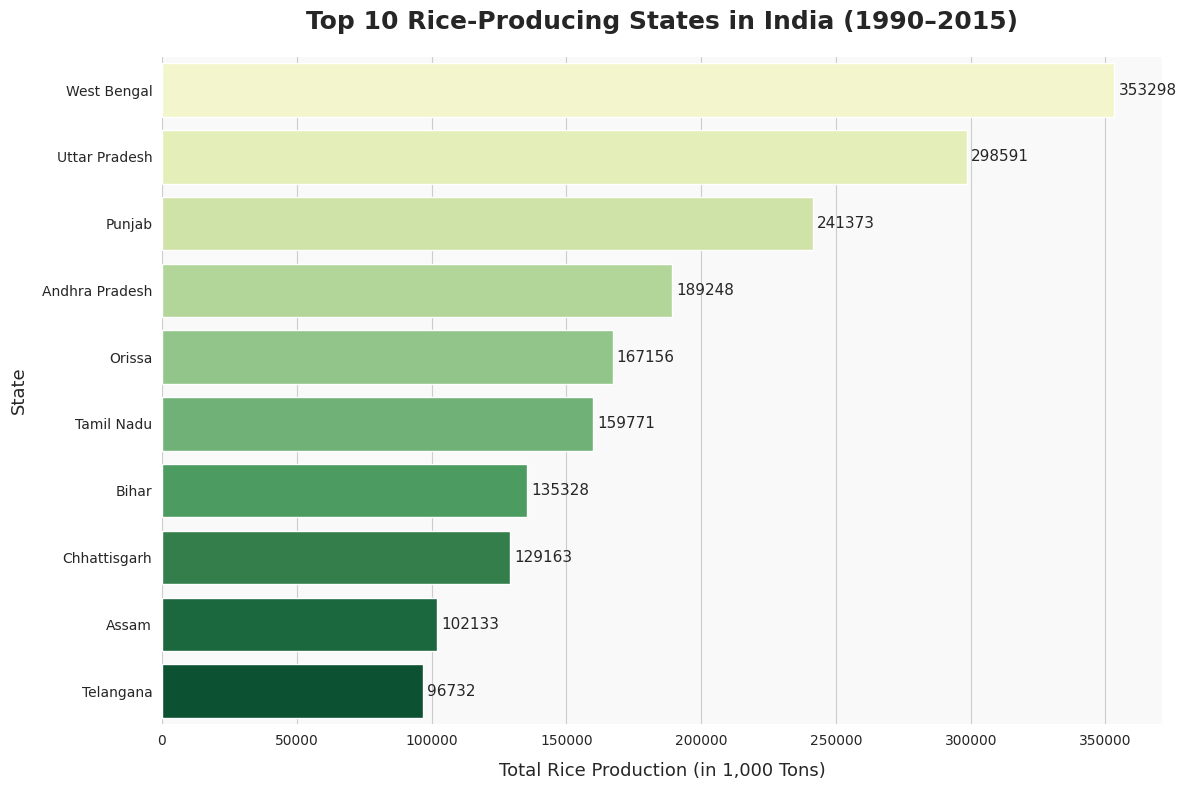

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group and select top 10 rice-producing states
top_10_rice_states = df.groupby('state_name')['rice_production_1000_tons'].sum().nlargest(10)

# Set visual style
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))

# Bar plot
ax = sns.barplot(
    x=top_10_rice_states.values,
    y=top_10_rice_states.index,
    palette="YlGn",
    hue=top_10_rice_states.index,
    legend=False
)

# --- TITLES & LABELS ---
plt.title(
    "Top 10 Rice-Producing States in India (1990–2015)",
    fontsize=18, fontweight='bold', pad=20
)

plt.xlabel("Total Rice Production (in 1,000 Tons)", fontsize=13, labelpad=10)
plt.ylabel("State", fontsize=13, labelpad=10)

# --- ANNOTATIONS ---
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', fontsize=11, padding=3)

# --- STYLE ENHANCEMENTS ---
sns.despine(left=True, bottom=True)
ax.set_facecolor('#f9f9f9')

plt.tight_layout()
plt.show()


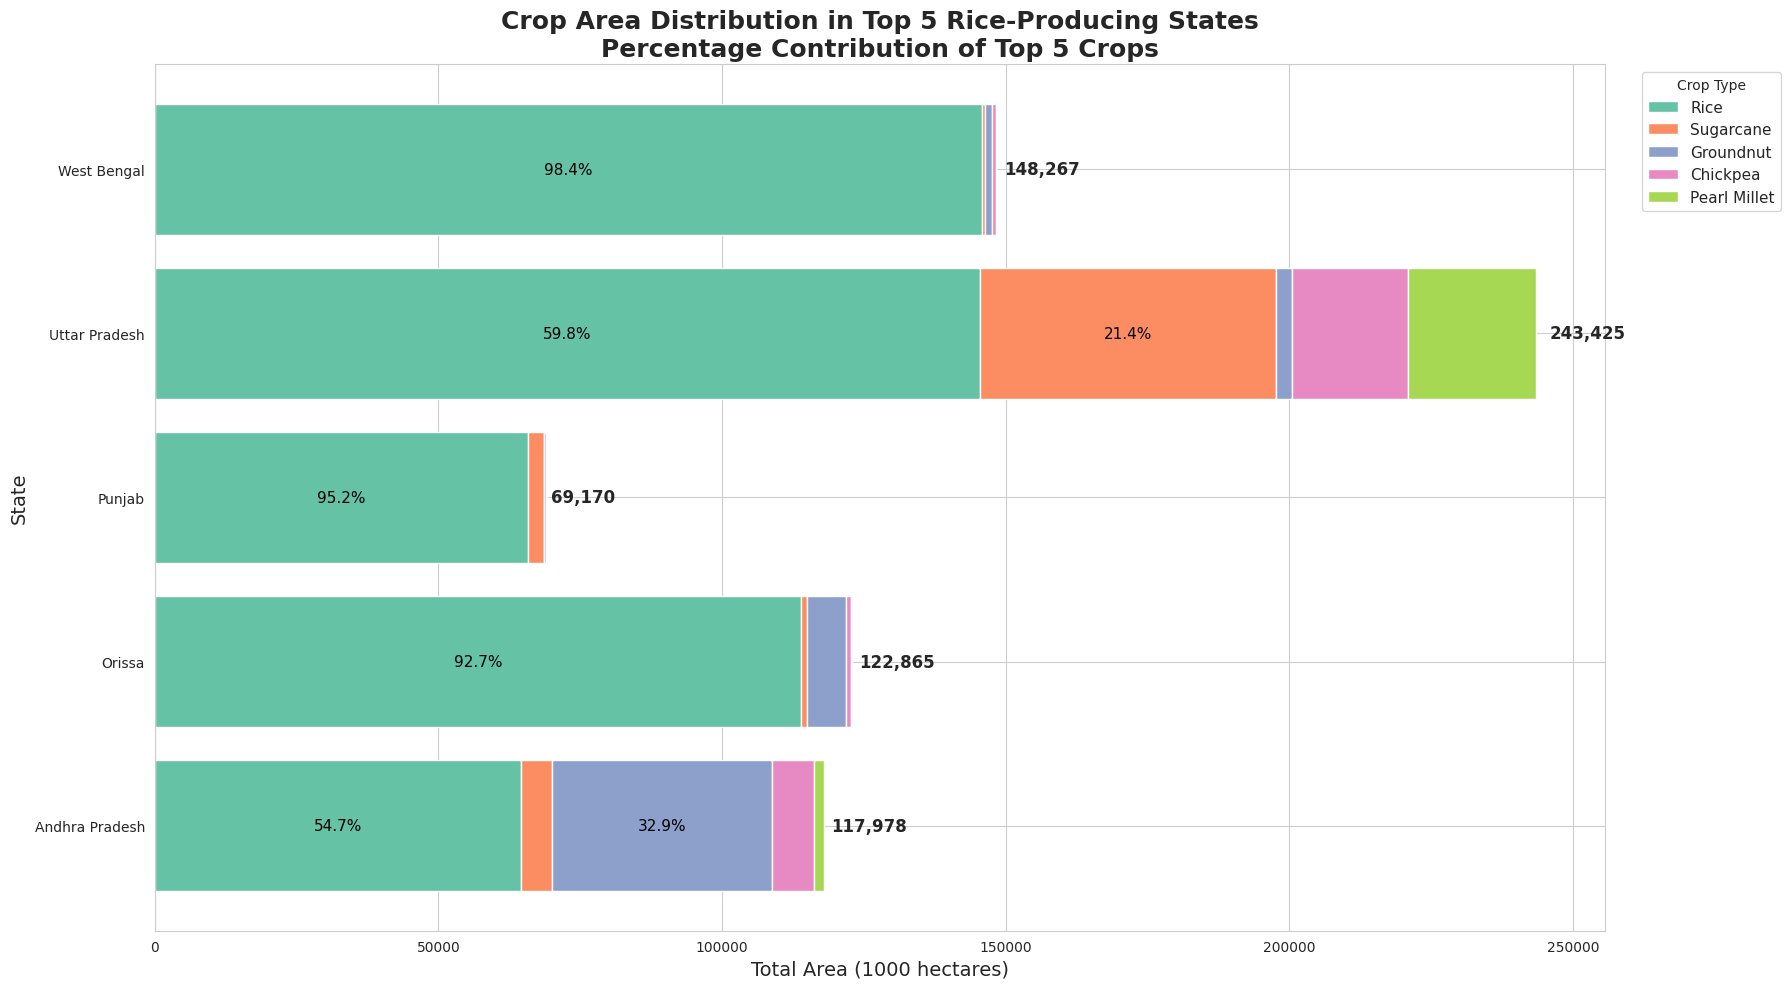

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Clean crop area columns
crop_cols = [
    col for col in df.columns
    if '_area_1000_ha' in col
    and not any(ex in col.lower() for ex in ['gross', 'net', 'irrigated', 'total'])
]

# Top 5 rice-producing states
top_5_states = top_10_rice_states.nlargest(5).index

# Aggregate crop portfolios
portfolio = (
    df[df['state_name'].isin(top_5_states)]
    .groupby('state_name')[crop_cols]
    .sum()
)

# Pick top 5 crops
top_crops = portfolio.sum().sort_values(ascending=False).head(5).index
portfolio_top = portfolio[top_crops]

# Clean names
clean_names = {col: col.replace('_area_1000_ha','').replace('_',' ').title()
               for col in top_crops}
portfolio_top = portfolio_top.rename(columns=clean_names)

plt.figure(figsize=(18, 10))
colors = plt.cm.Set2(range(len(portfolio_top.columns)))
bottom_vals = np.zeros(len(portfolio_top))

# Label threshold: only print if segment >= 10% of total
LABEL_THRESHOLD = 10

for idx, crop in enumerate(portfolio_top.columns):
    values = portfolio_top[crop].values

    plt.barh(
        portfolio_top.index,
        values,
        left=bottom_vals,
        color=colors[idx],
        label=crop
    )

    totals = portfolio_top.sum(axis=1).values

    for i, val in enumerate(values):
        percent = val / totals[i] * 100
        x_start = bottom_vals[i]

        # Print inside ONLY for segments >= 10%
        if percent >= LABEL_THRESHOLD:
            plt.text(
                x_start + val/2, i,
                f"{percent:.1f}%",
                ha='center', va='center',
                fontsize=11, color="black"
            )

    bottom_vals += values

# Add total labels (far right, not touched by percentage labels)
totals = portfolio_top.sum(axis=1)
for i, (state, total) in enumerate(totals.items()):
    plt.text(
        total + (total * 0.01),
        i,
        f"{int(total):,}",
        fontsize=12, fontweight="bold",
        va='center'
    )

plt.title(
    "Crop Area Distribution in Top 5 Rice-Producing States\n"
    "Percentage Contribution of Top 5 Crops",
    fontsize=18, fontweight='bold'
)
plt.xlabel("Total Area (1000 hectares)", fontsize=14)
plt.ylabel("State", fontsize=14)

plt.legend(
    title="Crop Type",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    fontsize=11
)

plt.tight_layout()
plt.show()


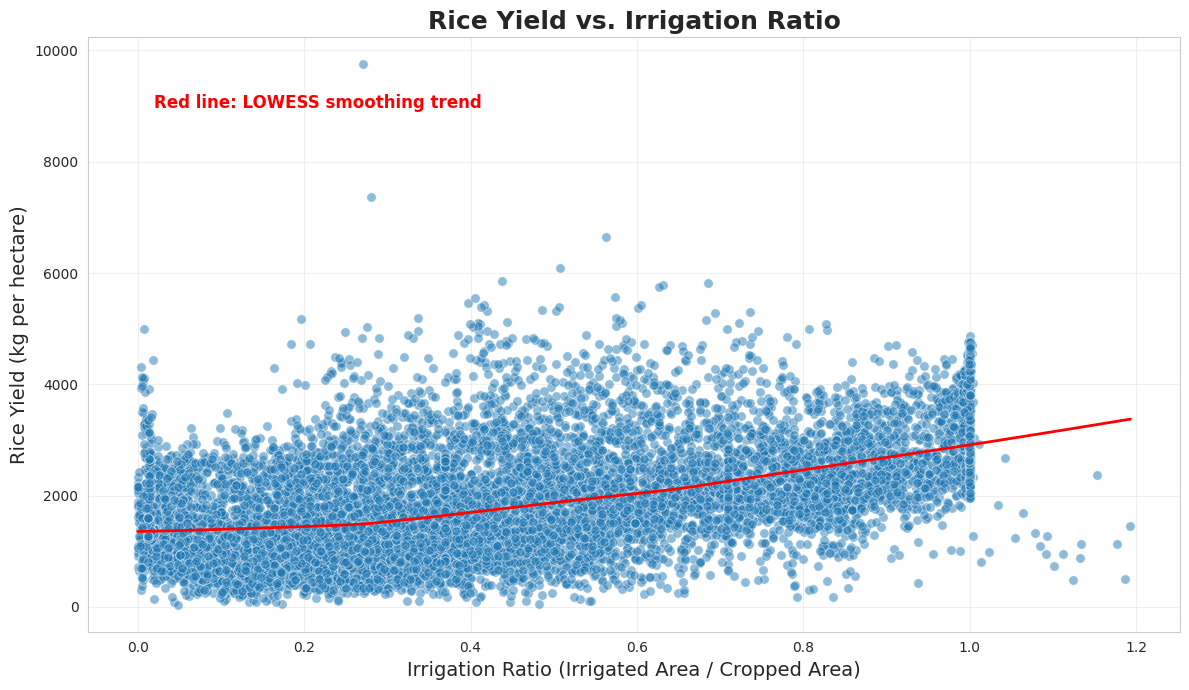

In [ ]:
# Filter unrealistic values
df_clean = df[(df['irrigation_ratio'] >= 0) &
              (df['irrigation_ratio'] <= 1.2) &
              (df['rice_yield_kg_per_ha'] > 0) &
              (df['rice_yield_kg_per_ha'] < 12000)]

plt.figure(figsize=(12, 7))

# Scatter
sns.scatterplot(
    data=df_clean,
    x='irrigation_ratio',
    y='rice_yield_kg_per_ha',
    alpha=0.5,
    s=45,
    color="#1f78b4"
)

# LOWESS smoothing trend line
sns.regplot(
    data=df_clean,
    x='irrigation_ratio',
    y='rice_yield_kg_per_ha',
    scatter=False,
    lowess=True,
    color='red',
    line_kws={'linewidth': 2}
)

# In-plot annotation describing the red line
plt.text(
    0.02,                                      # x-position (2% of x-range)
    df_clean['rice_yield_kg_per_ha'].max()*0.92,  # y-position (top, ~92% of y-range)
    "Red line: LOWESS smoothing trend",
    color='red',
    fontsize=12,
    fontweight='bold'
)

plt.title("Rice Yield vs. Irrigation Ratio", fontsize=18, fontweight='bold')
plt.xlabel("Irrigation Ratio (Irrigated Area / Cropped Area)", fontsize=14)
plt.ylabel("Rice Yield (kg per hectare)", fontsize=14)

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


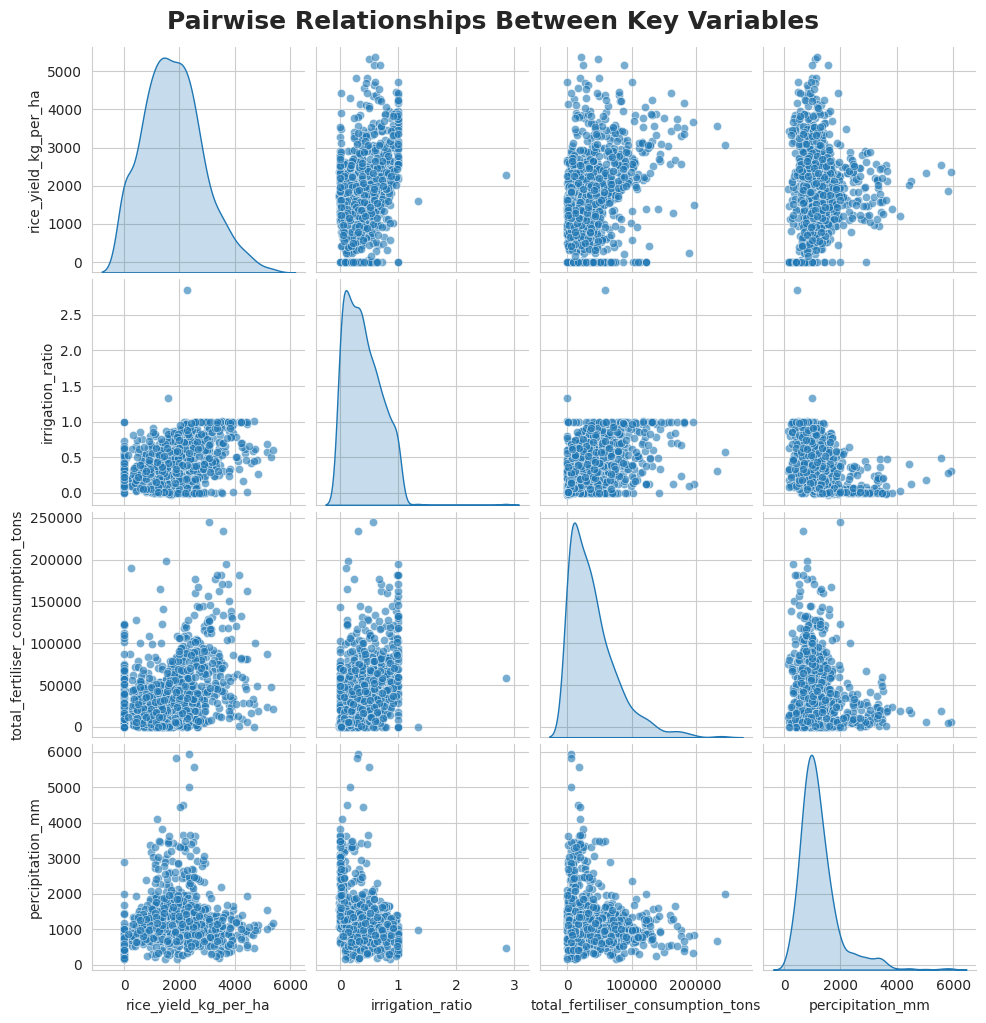

In [ ]:
# Multivariate Pair Plot: Exploring Key Relationships
pairplot_cols = [
    'rice_yield_kg_per_ha',
    'irrigation_ratio',
    'total_fertiliser_consumption_tons',
    'percipitation_mm'
]

# Use only the columns present in df
valid_pairplot_cols = [col for col in pairplot_cols if col in df.columns]

if len(valid_pairplot_cols) > 1:

    sample_size = min(1000, len(df))
    df_sample = df[valid_pairplot_cols].dropna().sample(n=sample_size, random_state=1)

    sns.pairplot(
        df_sample,
        diag_kind="kde",
        corner=False,
        plot_kws={'alpha': 0.6, 's': 35},     # point size + transparency
        diag_kws={'fill': True}              # replaces shade=True
    )

    plt.suptitle(
        "Pairwise Relationships Between Key Variables\n",
        y=1.02,
        fontsize=18,
        fontweight='bold'
    )

    plt.show()


/tmp/ipython-input-2620231900.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


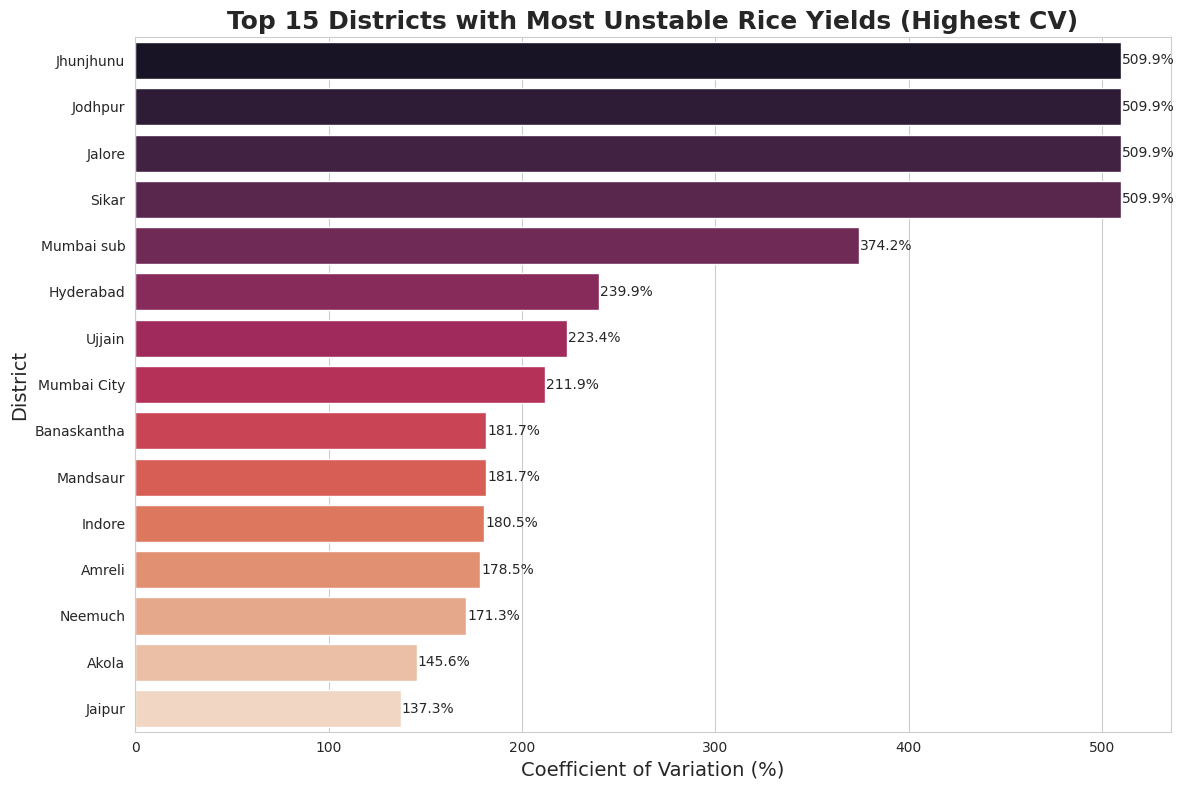

In [ ]:
# Calculate variation (CV %)
dist_yield_stats = (
    df.groupby(['state_name', 'dist_name'])['rice_yield_kg_per_ha']
      .agg(['mean', 'std'])
      .dropna()
)

dist_yield_stats['yield_cv_%'] = (dist_yield_stats['std'] / dist_yield_stats['mean']) * 100

# Top 15 districts with highest volatility
top_15 = dist_yield_stats.nlargest(15, 'yield_cv_%').reset_index()

plt.figure(figsize=(12, 8))

# Clean barplot (NO hue needed)
sns.barplot(
    data=top_15,
    x='yield_cv_%',
    y='dist_name',
    palette='rocket'
)

# Add labels on bars
for index, row in top_15.iterrows():
    plt.text(
        row['yield_cv_%'] + 0.5,
        index,
        f"{row['yield_cv_%']:.1f}%",
        va='center',
        fontsize=10
    )

plt.title('Top 15 Districts with Most Unstable Rice Yields (Highest CV)', fontsize=18, fontweight='bold')
plt.xlabel('Coefficient of Variation (%)', fontsize=14)
plt.ylabel('District', fontsize=14)

plt.tight_layout()
plt.show()


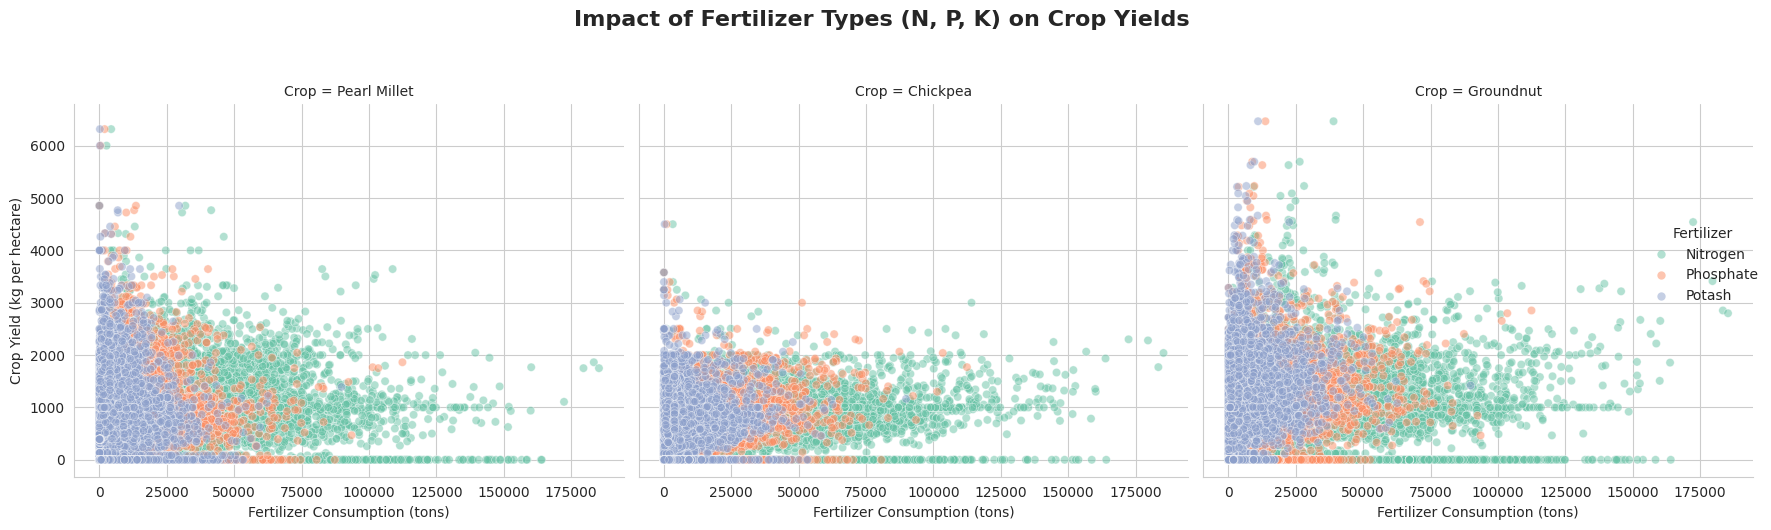

In [ ]:
# Create a tidy dataset for fertilizer vs yield analysis
tidy_list = []

crops = {
    'Pearl Millet': 'pearl_millet_yield_kg_per_ha',
    'Chickpea': 'chickpea_yield_kg_per_ha',
    'Groundnut': 'groundnut_yield_kg_per_ha'
}

fertilizers = {
    'Nitrogen': 'nitrogen_consumption_tons',
    'Phosphate': 'phosphate_consumption_tons',
    'Potash': 'potash_consumption_tons'
}

for crop_name, crop_col in crops.items():
    for fert_name, fert_col in fertilizers.items():
        temp = df[[crop_col, fert_col]].dropna().copy()
        temp['Crop'] = crop_name
        temp['Fertilizer'] = fert_name
        temp['Yield'] = temp[crop_col]
        temp['Consumption'] = temp[fert_col]
        tidy_list.append(temp[['Crop', 'Yield', 'Fertilizer', 'Consumption']])

tidy_df = pd.concat(tidy_list, ignore_index=True)

# Plot: Faceted scatterplots (NO LOWESS)
g = sns.relplot(
    data=tidy_df,
    x='Consumption',
    y='Yield',
    hue='Fertilizer',
    col='Crop',
    kind='scatter',
    alpha=0.5,
    height=5,
    aspect=1.1,
    palette='Set2'
)

for ax in g.axes.flat:
    ax.set_xlabel("Fertilizer Consumption (tons)")
    ax.set_ylabel("Crop Yield (kg per hectare)")

plt.suptitle(
    'Impact of Fertilizer Types (N, P, K) on Crop Yields',
    y=1.05,
    fontsize=16,
    fontweight='bold'
)

plt.tight_layout()
plt.show()


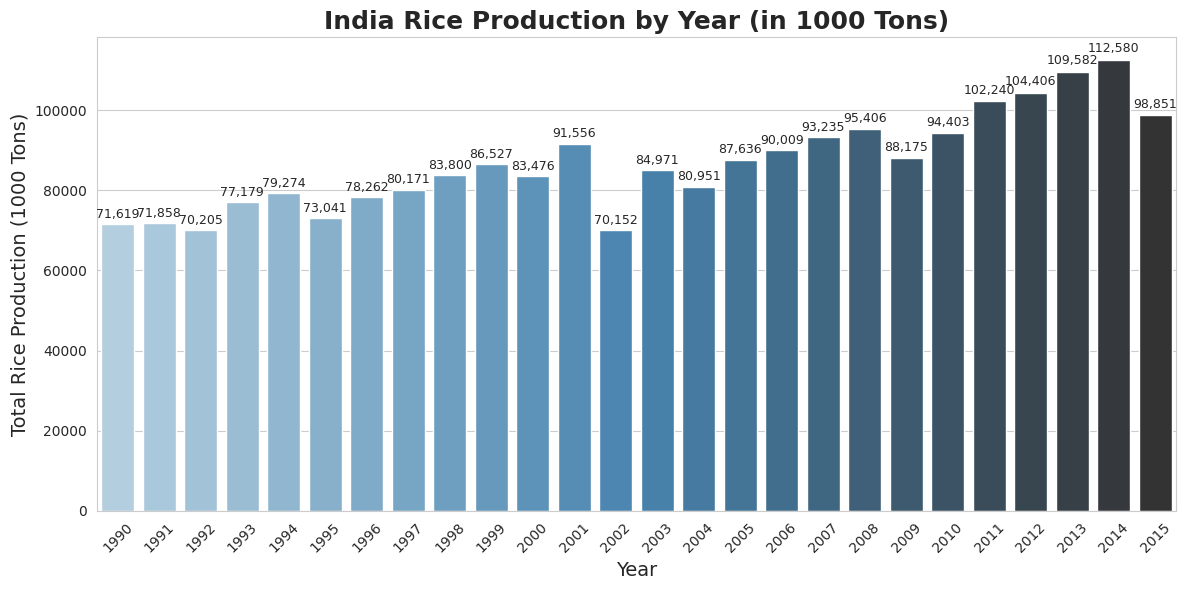

In [ ]:
# Aggregate rice production by year
rice_by_year = (
    df.groupby('year')['rice_production_1000_tons']
      .sum()
      .reset_index()
      .sort_values('year')
)

plt.figure(figsize=(12, 6))

sns.barplot(
    data=rice_by_year,
    x='year',
    y='rice_production_1000_tons',
    hue='year',                # required by seaborn for palette
    palette='Blues_d',
    dodge=False,               # bars stay single
    legend=False               # hide legend since hue = year
)

# Add value labels
for idx, row in rice_by_year.iterrows():
    plt.text(
        idx,
        row['rice_production_1000_tons'] + (row['rice_production_1000_tons'] * 0.01),
        f"{int(row['rice_production_1000_tons']):,}",
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.title('India Rice Production by Year (in 1000 Tons)', fontsize=18, fontweight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Total Rice Production (1000 Tons)', fontsize=14)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


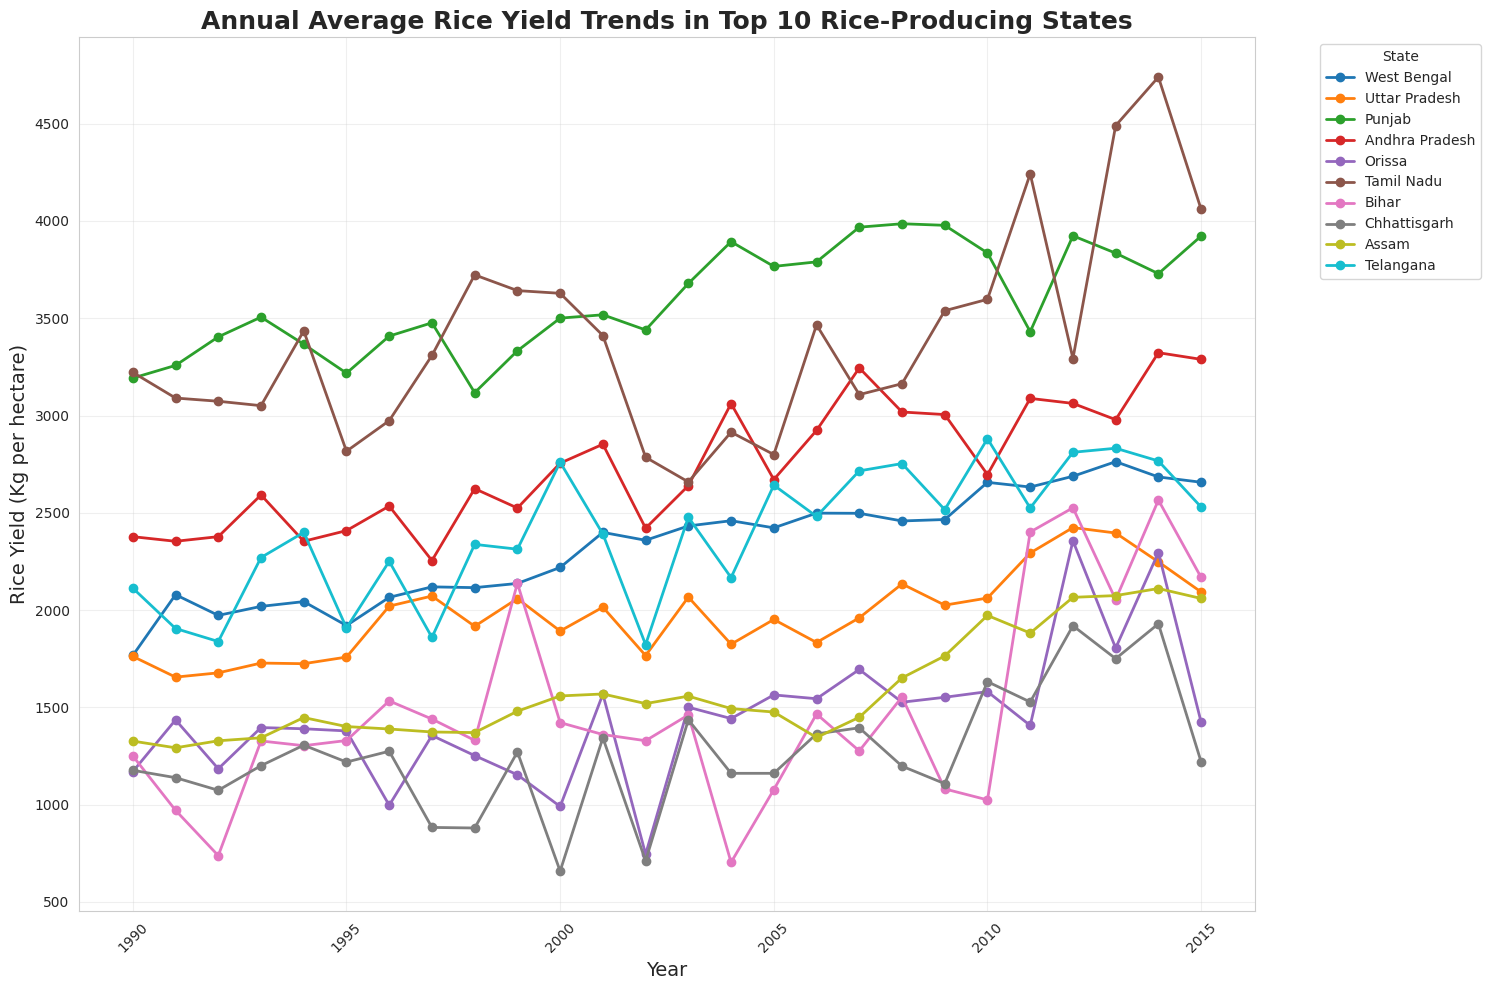

In [ ]:
# Agricultural Trends Analysis: Rice Yield Over Time for Top 10 States

crops_for_trends = ['rice', 'wheat', 'maize', 'jowar', 'bajra']

# Build column lists
production_cols = [f'{crop}_production_1000_tons' for crop in crops_for_trends]
area_cols = [f'{crop}_area_1000_ha' for crop in crops_for_trends]
yield_cols = [f'{crop}_yield_kg_per_ha' for crop in crops_for_trends]

# Filter columns that actually exist
valid_production_cols = [c for c in production_cols if c in df.columns]
valid_area_cols = [c for c in area_cols if c in df.columns]
valid_yield_cols = [c for c in yield_cols if c in df.columns]

# Get top 10 rice-producing states
top_10_rice_states = (
    df.groupby('state_name')['rice_production_1000_tons']
      .sum()
      .nlargest(10)
      .index
)

plt.figure(figsize=(15, 10))

palette = sns.color_palette("tab10", n_colors=len(top_10_rice_states))

for color, state in zip(palette, top_10_rice_states):
    state_df = (
        df[df['state_name'] == state]
        .groupby('year')['rice_yield_kg_per_ha']
        .mean()
        .reset_index()
        .sort_values('year')      # ensure chronological order
    )

    plt.plot(
        state_df['year'],
        state_df['rice_yield_kg_per_ha'],
        label=state,
        marker='o',
        linewidth=2,
        markersize=6,
        color=color
    )

plt.title('Annual Average Rice Yield Trends in Top 10 Rice-Producing States',
          fontsize=18, fontweight='bold')

plt.ylabel('Rice Yield (Kg per hectare)', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.grid(True, alpha=0.3)

plt.xticks(rotation=45)

plt.legend(
    title='State',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    fontsize=10
)

plt.tight_layout()
plt.show()


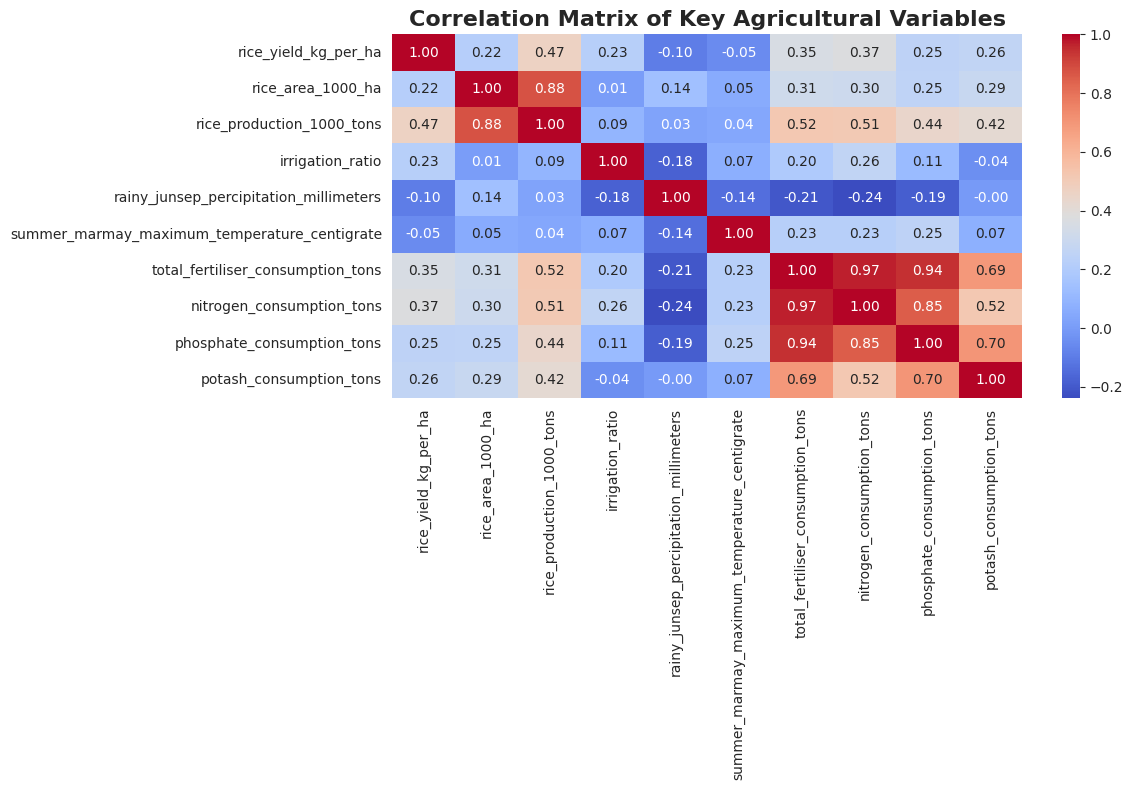

In [ ]:
# Shows which factors matter most for yield
heatmap_cols = [
    'rice_yield_kg_per_ha',
    'rice_area_1000_ha',
    'rice_production_1000_tons',
    'irrigation_ratio',
    'rainy_junsep_percipitation_millimeters', # Corrected column name
    'summer_marmay_maximum_temperature_centigrate', # Corrected column name
    'total_fertiliser_consumption_tons',
    'nitrogen_consumption_tons',
    'phosphate_consumption_tons',
    'potash_consumption_tons'
]

df_corr = df[heatmap_cols].dropna()

plt.figure(figsize=(12,8))
sns.heatmap(df_corr.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Key Agricultural Variables', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

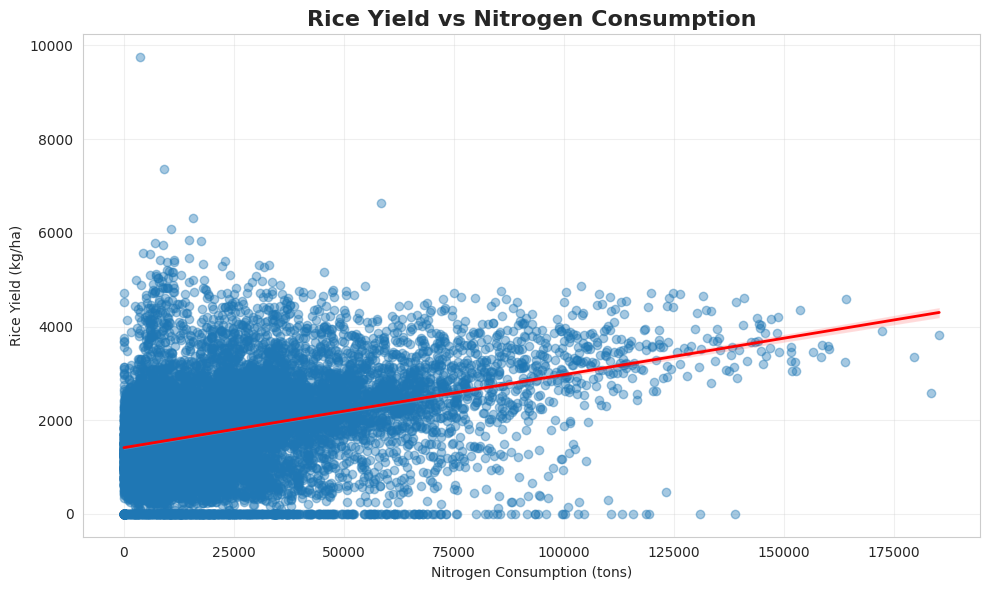

In [ ]:
plt.figure(figsize=(10,6))
sns.regplot(
    data=df,
    x='nitrogen_consumption_tons',
    y='rice_yield_kg_per_ha',
    scatter_kws={'alpha':0.4},
    line_kws={'color':'red', 'lw':2}
)
plt.title('Rice Yield vs Nitrogen Consumption', fontsize=16, fontweight='bold')
plt.xlabel('Nitrogen Consumption (tons)')
plt.ylabel('Rice Yield (kg/ha)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


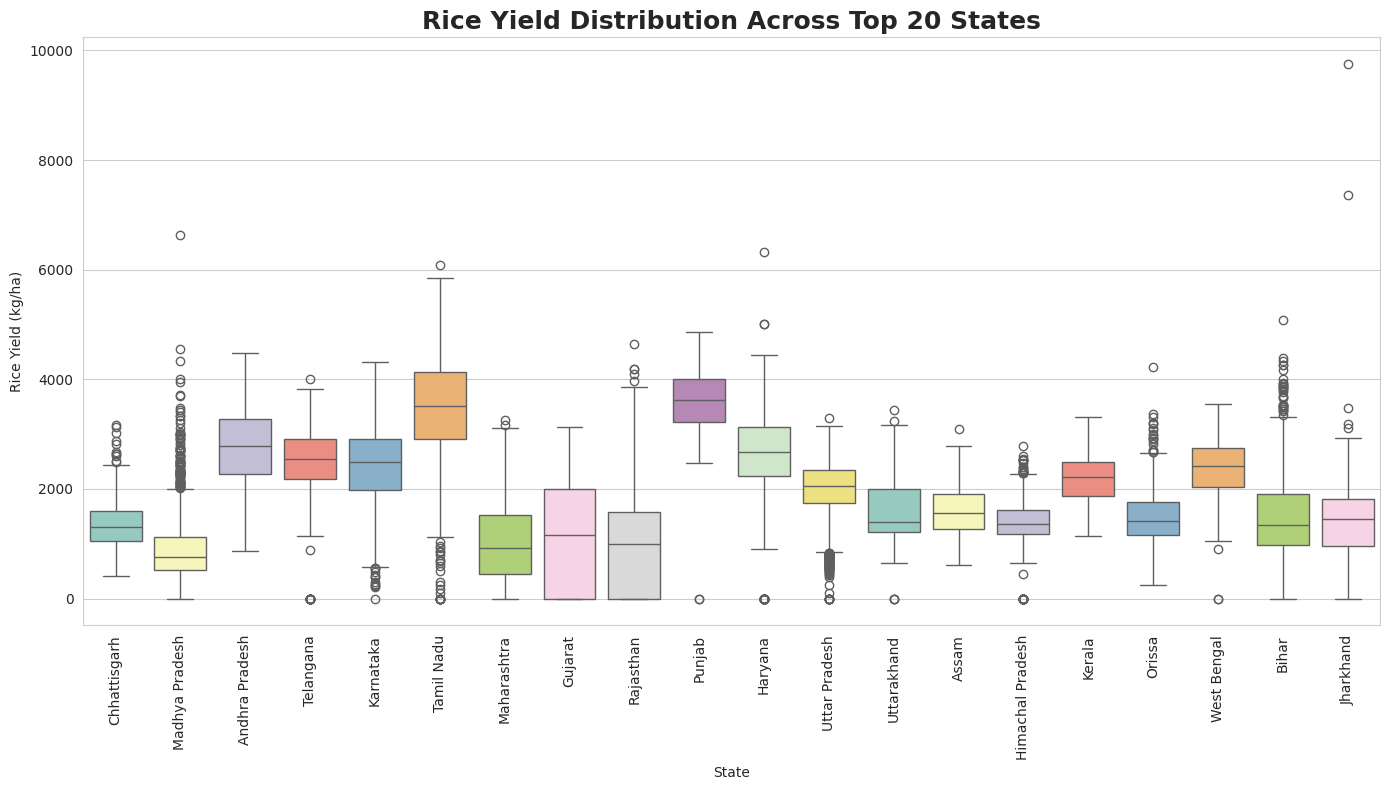

In [ ]:
plt.figure(figsize=(14,8))

top_states = (
    df.groupby('state_name')['rice_yield_kg_per_ha']
      .mean()
      .sort_values(ascending=False)
      .head(20)
      .index
)

sns.boxplot(
    data=df[df['state_name'].isin(top_states)],
    x='state_name',
    y='rice_yield_kg_per_ha',
    hue='state_name',
    palette='Set3',
    dodge=False,
    legend=False
)

plt.title('Rice Yield Distribution Across Top 20 States', fontsize=18, fontweight='bold')
plt.xticks(rotation=90)
plt.xlabel('State')
plt.ylabel('Rice Yield (kg/ha)')
plt.tight_layout()
plt.show()


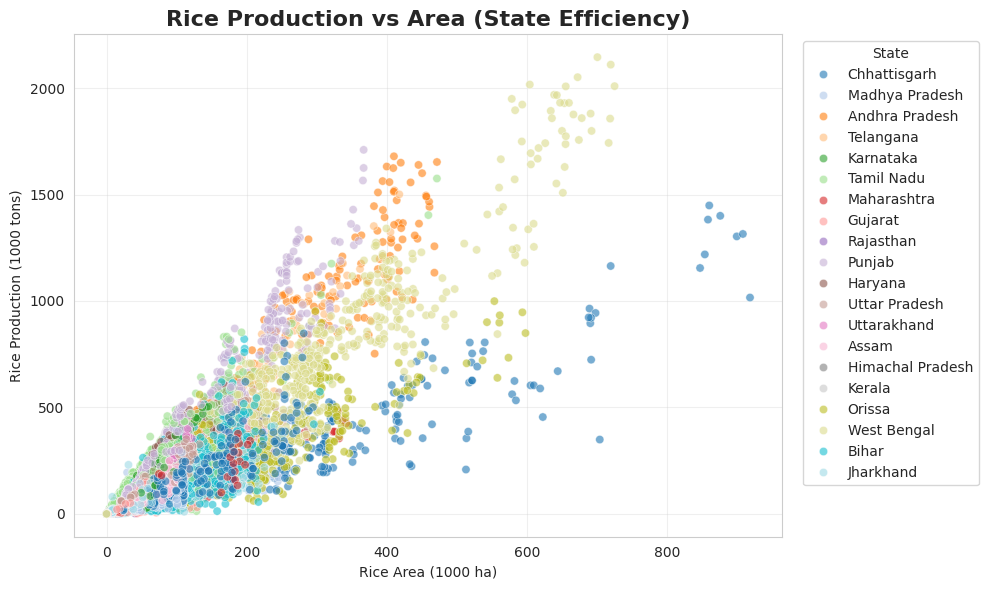

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df,
    x='rice_area_1000_ha',
    y='rice_production_1000_tons',
    hue='state_name',
    alpha=0.6,
    palette='tab20'
)

plt.title('Rice Production vs Area (State Efficiency)', fontsize=16, fontweight='bold')
plt.xlabel('Rice Area (1000 ha)')
plt.ylabel('Rice Production (1000 tons)')
plt.legend(bbox_to_anchor=(1.02,1), loc='upper left', title='State')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

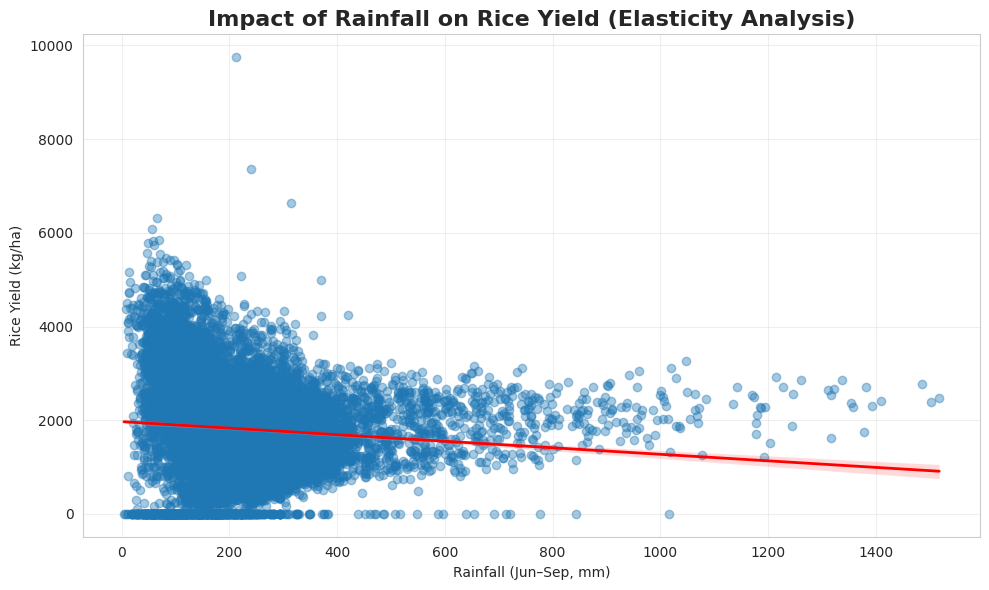

In [ ]:
plt.figure(figsize=(10,6))
sns.regplot(
    data=df,
    x='rainy_junsep_percipitation_millimeters', # Corrected column name
    y='rice_yield_kg_per_ha',
    scatter_kws={'alpha':0.4},
    line_kws={'color':'red', 'lw':2}
)

plt.title('Impact of Rainfall on Rice Yield (Elasticity Analysis)', fontsize=16, fontweight='bold')
plt.xlabel('Rainfall (Jun–Sep, mm)')
plt.ylabel('Rice Yield (kg/ha)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

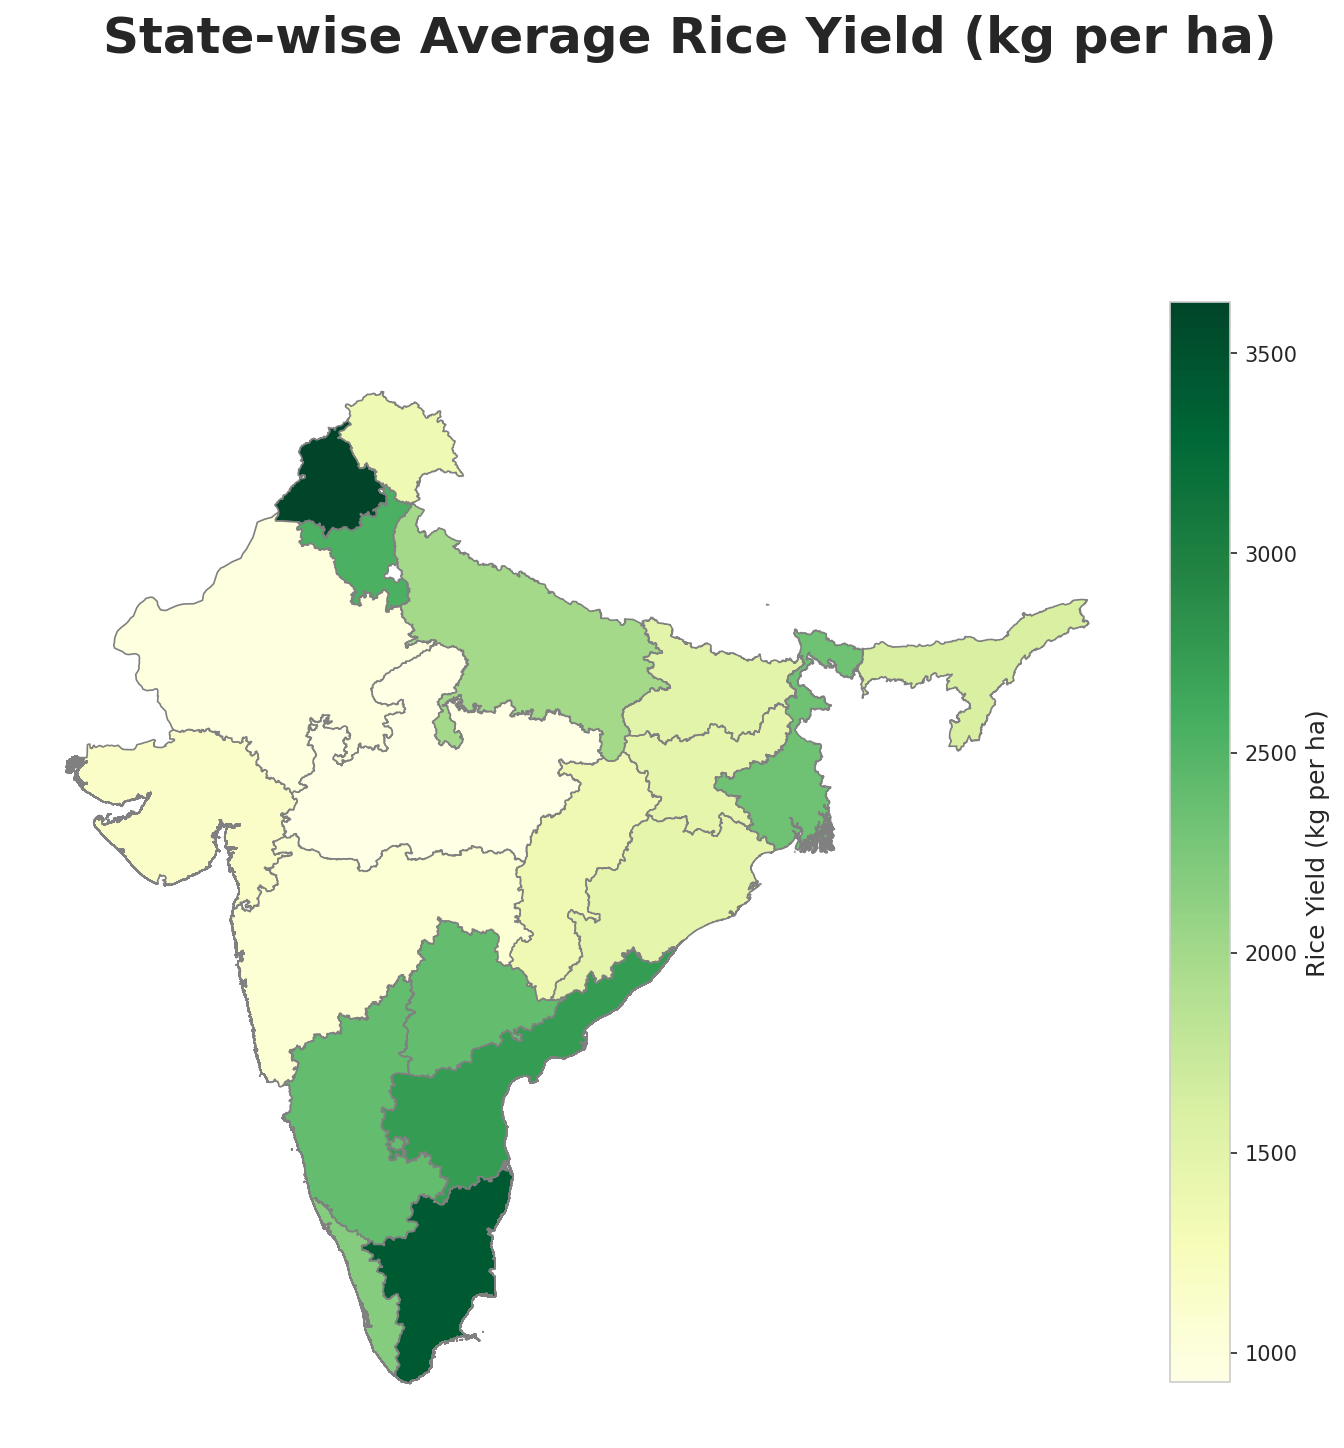

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/geohacker/india/master/state/india_telengana.geojson"
india_map = gpd.read_file(url)

# Rename column to match your dataset
india_map = india_map.rename(columns={'NAME_1': 'state_name'})

state_yield = (
    df.groupby('state_name')['rice_yield_kg_per_ha']
      .mean()
      .reset_index()
)

# Merge map with yield data
merged = india_map.merge(state_yield, on='state_name', how='left')


fig = plt.figure(figsize=(10, 12), dpi=150)

# Axes for the map (left side)
ax = fig.add_axes([0.05, 0.05, 0.75, 0.85])

# Axes for the colorbar (right side)
cax = fig.add_axes([0.82, 0.20, 0.04, 0.60])

# Draw the map
merged.plot(
    column='rice_yield_kg_per_ha',
    cmap='YlGn',
    legend=True,
    edgecolor='gray',
    linewidth=0.8,
    ax=ax,
    cax=cax
)

# Centered title
fig.suptitle(
    "State-wise Average Rice Yield (kg per ha)",
    fontsize=24,
    fontweight="bold",
    y=0.96
)

# Turn off axis lines
ax.axis('off')

# Label for colorbar
cax.set_ylabel('Rice Yield (kg per ha)', fontsize=12)

plt.show()


/tmp/ipython-input-1873823416.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


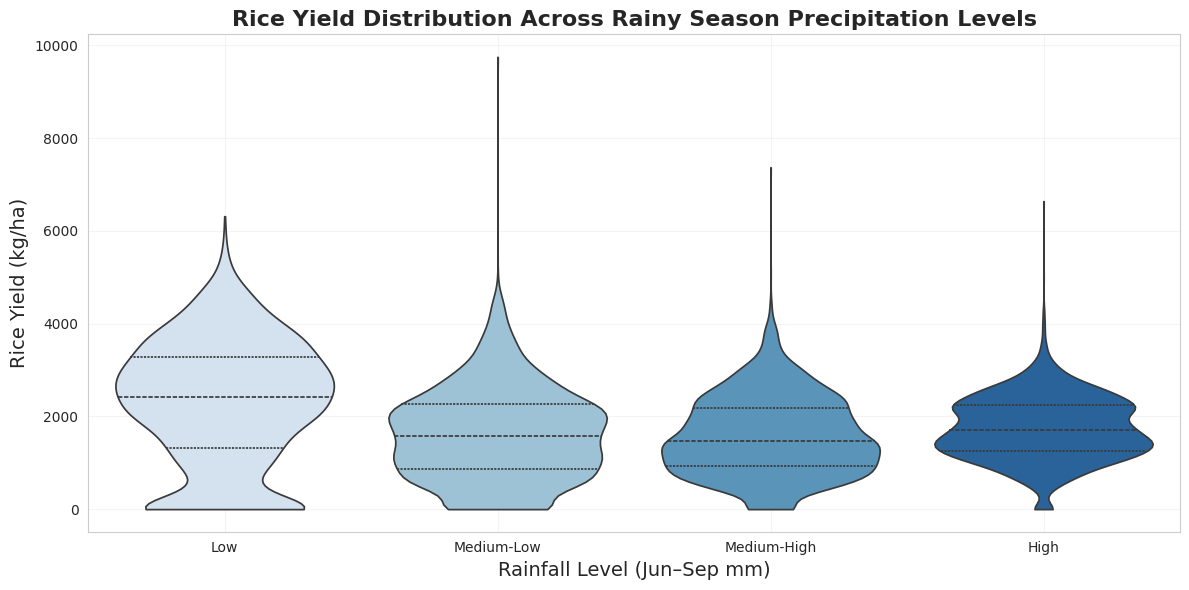

/tmp/ipython-input-1873823416.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


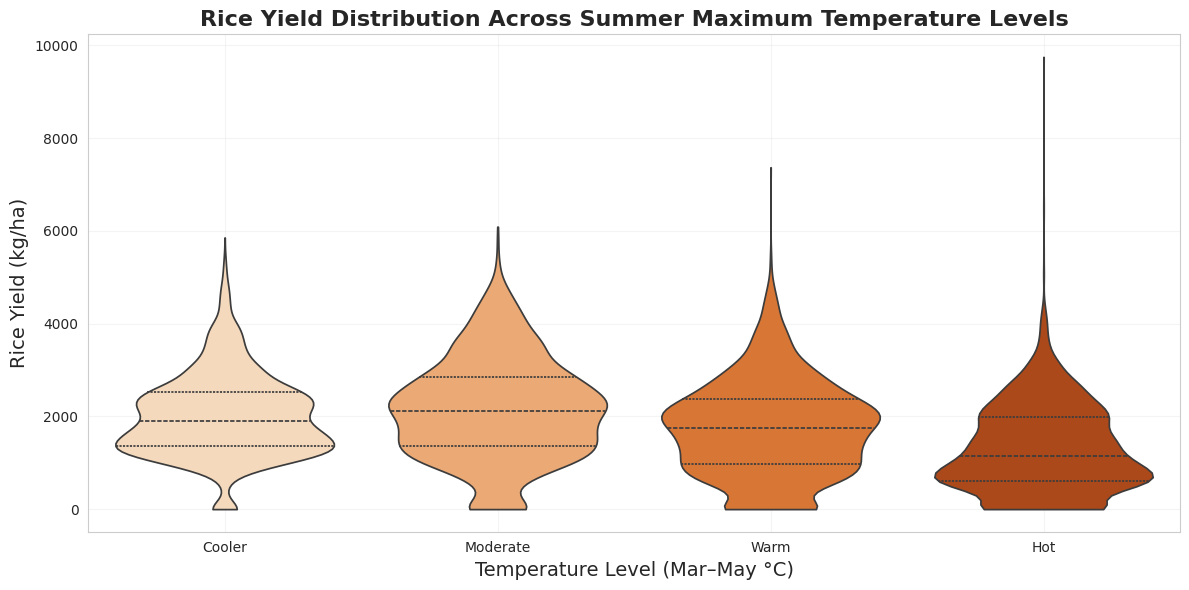

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Column names
rainfall_col = 'rainy_junsep_percipitation_millimeters' # Corrected column name
temperature_col = 'summer_marmay_maximum_temperature_centigrate' # Corrected column name

# Drop rows with missing values in rainfall/temp before binning
df_filtered = df[[rainfall_col, temperature_col, 'rice_yield_kg_per_ha']].dropna().copy()

# Create rainfall bins (ordered)
df_filtered['rainfall_bin'] = pd.qcut(
    df_filtered[rainfall_col],
    4,
    labels=['Low', 'Medium-Low', 'Medium-High', 'High']
)

# Create temperature bins (ordered)
df_filtered['temp_bin'] = pd.qcut(
    df_filtered[temperature_col],
    4,
    labels=['Cooler', 'Moderate', 'Warm', 'Hot']
)

# === Violin plot: Rainfall vs Rice Yield ===
plt.figure(figsize=(12,6))
sns.violinplot(
    data=df_filtered,
    x='rainfall_bin',
    y='rice_yield_kg_per_ha',
    palette=sns.color_palette("Blues", 4),
    inner='quartile',
    cut=0
)
plt.title('Rice Yield Distribution Across Rainy Season Precipitation Levels', fontsize=16, fontweight='bold')
plt.xlabel('Rainfall Level (Jun–Sep mm)', fontsize=14)
plt.ylabel('Rice Yield (kg/ha)', fontsize=14)
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

# === Violin plot: Temperature vs Rice Yield ===
plt.figure(figsize=(12,6))
sns.violinplot(
    data=df_filtered,
    x='temp_bin',
    y='rice_yield_kg_per_ha',
    palette=sns.color_palette("Oranges", 4),
    inner='quartile',
    cut=0
)
plt.title('Rice Yield Distribution Across Summer Maximum Temperature Levels', fontsize=16, fontweight='bold')
plt.xlabel('Temperature Level (Mar–May °C)', fontsize=14)
plt.ylabel('Rice Yield (kg/ha)', fontsize=14)
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

In [ ]:
print(df.columns.tolist())

['dist_code', 'year', 'state_code', 'state_name', 'dist_name', 'rice_area_1000_ha', 'rice_production_1000_tons', 'rice_yield_kg_per_ha', 'pearl_millet_area_1000_ha', 'pearl_millet_production_1000_tons', 'pearl_millet_yield_kg_per_ha', 'chickpea_area_1000_ha', 'chickpea_production_1000_tons', 'chickpea_yield_kg_per_ha', 'groundnut_area_1000_ha', 'groundnut_production_1000_tons', 'groundnut_yield_kg_per_ha', 'sugarcane_area_1000_ha', 'sugarcane_production_1000_tons', 'sugarcane_yield_kg_per_ha', 'gross_cropped_area_1000_ha', 'nitrogen_consumption_tons', 'phosphate_consumption_tons', 'potash_consumption_tons', 'total_fertiliser_consumption_tons', 'gross_irrigated_area_1000_ha', 'january_maximum_temperature_centigrate', 'february_maximum_temperature_centigrate', 'march_maximum_temperature_centigrate', 'april_maximum_temperature_centigrate', 'may_maximum_temperature_centigrate', 'june_maximum_temperature_centigrate', 'july_maximum_temperature_centigrate', 'august_maximum_temperature_centigr

In [9]:
#Save the Cleaned and Processed DataFrame
output_filename = 'cleaned_agricultural_data.csv'
df.to_csv(output_filename, index=False)
print(f"Cleaned data successfully saved to '{output_filename}'")
print("You can find this file in the Colab file explorer on the left.")

Cleaned data successfully saved to 'cleaned_agricultural_data.csv'
You can find this file in the Colab file explorer on the left.


#make correlation matrix complete, simple linear regression

In [ ]:
import statsmodels.api as sm

# Define the dependent variable (Rice Yield) and potential independent variables
dependent_var = 'rice_yield_kg_per_ha'
independent_vars = [
    'irrigation_ratio',
    'total_fertiliser_consumption_tons',
    'rainy_jun-sep_percipitation_millimeters',
    'summer_mar-may_maximum_temperature_centigrate',
    'temperature_c' # This was created as an average of monthly temperatures
]

# Filter for columns that actually exist in the DataFrame
valid_independent_vars = [col for col in independent_vars if col in df.columns]
X = df[valid_independent_vars]
y = df[dependent_var]

# Add a constant (intercept) to the independent variables
X = sm.add_constant(X)

# Perform Backward Elimination
# Start with all valid independent variables and iteratively remove the one with the highest p-value
# if it's above a certain significance level (e.g., 0.05)

def backward_elimination(X, y, significance_level=0.05):
    features = list(X.columns)
    while (len(features) > 0):
        model = sm.OLS(y, X[features]).fit()
        p_values = model.pvalues
        max_p_value = max(p_values)
        if max_p_value > significance_level:
            redundant_feature = p_values.idxmax()
            features.remove(redundant_feature)
        else:
            break
    return features

selected_features = backward_elimination(X, y)

# Fit the final model with the selected features
final_model = sm.OLS(y, X[selected_features]).fit()

# Print the summary of the final model
print("Final Model after Backward Elimination:")
print(final_model.summary())

# Conclusions and Meaning of Results (Rice Yield Model):
# R-squared: 0.214 - This indicates that approximately 21.4% of the variance in rice yield can be explained by the independent variables in this model. This is a relatively low R-squared, suggesting other factors not included in the model also significantly influence rice yield.
# Significant Predictors (P>|t| < 0.05): irrigation_ratio, total_fertiliser_consumption_tons, rainy_jun-sep_percipitation_millimeters, summer_mar-may_maximum_temperature_centigrate, and temperature_c are all statistically significant predictors of rice yield.
# Coefficients (coef):
# - irrigation_ratio: Positive coefficient (341.01) suggests that a higher irrigation ratio is associated with increased rice yield.
# - total_fertiliser_consumption_tons: Positive coefficient (0.0089) indicates that higher fertilizer consumption is associated with increased rice yield.
# - rainy_jun-sep_percipitation_millimeters: Negative coefficient (-0.3094) suggests that higher rainfall during the rainy season is associated with decreased rice yield. This could be due to factors like flooding or excessive moisture.
# - summer_mar-may_maximum_temperature_centigrate: Negative coefficient (-182.27) suggests higher summer temperatures are associated with lower rice yields, likely indicating heat stress.
# - temperature_c: Positive coefficient (201.95) indicates that higher average annual temperature is associated with increased rice yield. This might seem counterintuitive with the summer temp result, suggesting a complex relationship where moderate warmth is beneficial but extreme heat is detrimental.
# The model suggests that irrigation, fertilizer, and climate factors (temperature and rainfall) are important influences on rice yield, though the model's explanatory power is limited. The negative impact of high summer temperatures and excessive rainy season precipitation are notable findings.

Final Model after Backward Elimination:
                             OLS Regression Results                             
Dep. Variable:     rice_yield_kg_per_ha   R-squared:                       0.154
Model:                              OLS   Adj. R-squared:                  0.154
Method:                   Least Squares   F-statistic:                     778.6
Date:                  Thu, 06 Nov 2025   Prob (F-statistic):               0.00
Time:                          14:47:13   Log-Likelihood:            -1.0612e+05
No. Observations:                 12803   AIC:                         2.122e+05
Df Residuals:                     12799   BIC:                         2.123e+05
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

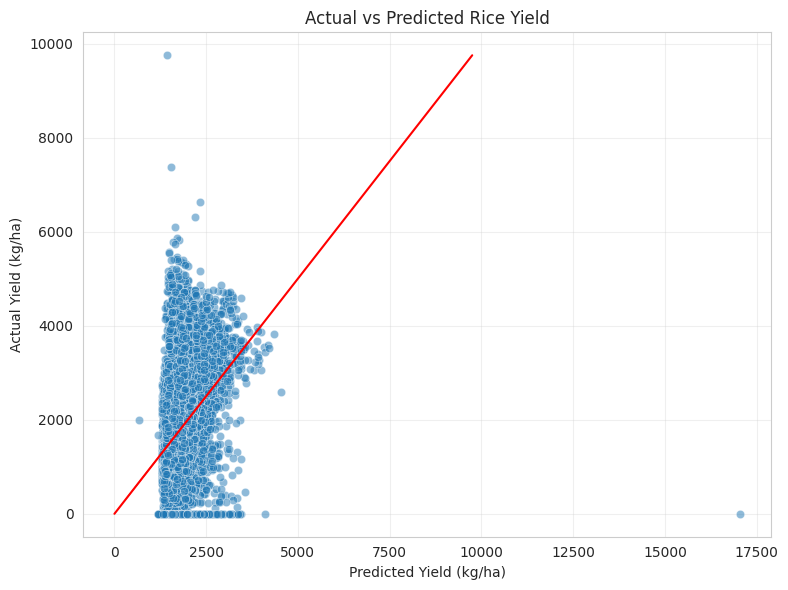

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = final_model.predict(X[selected_features])

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_pred, y=y, alpha=0.5)
sns.lineplot(x=y, y=y, color='red')  # perfect fit line
plt.xlabel("Predicted Yield (kg/ha)")
plt.ylabel("Actual Yield (kg/ha)")
plt.title("Actual vs Predicted Rice Yield")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

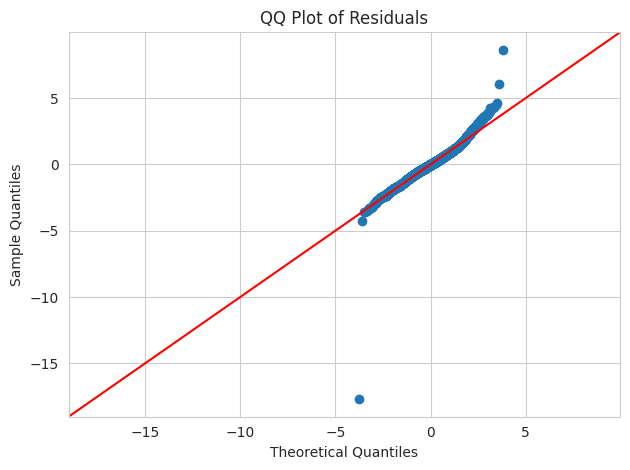

In [ ]:
import statsmodels.api as sm

# Calculate the residuals
residuals = y - y_pred

sm.qqplot(residuals, line='45', fit=True)
plt.title("QQ Plot of Residuals")
plt.tight_layout()
plt.show()

In [ ]:
import statsmodels.api as sm

# Define the dependent variable (Irrigation Ratio) and potential independent variables
dependent_var = 'irrigation_ratio'
independent_vars = [
    'rice_yield_kg_per_ha',
    'total_fertiliser_consumption_tons',
    'rainy_jun-sep_percipitation_millimeters',
    'summer_mar-may_maximum_temperature_centigrate',
    'temperature_c',
    'total_agricultural_labour_population_1000_number',
    'gross_cropped_area_1000_ha'
]

# Filter for columns that actually exist in the DataFrame
valid_independent_vars = [col for col in independent_vars if col in df.columns]
X = df[valid_independent_vars]
y = df[dependent_var]

# Add a constant (intercept) to the independent variables
X = sm.add_constant(X)

# Perform Backward Elimination
# Start with all valid independent variables and iteratively remove the one with the highest p-value
# if it's above a certain significance level (e.g., 0.05)

def backward_elimination(X, y, significance_level=0.05):
    features = list(X.columns)
    while (len(features) > 0):
        model = sm.OLS(y, X[features]).fit()
        p_values = model.pvalues
        max_p_value = max(p_values)
        if max_p_value > significance_level:
            redundant_feature = p_values.idxmax()
            features.remove(redundant_feature)
        else:
            break
    return features

selected_features = backward_elimination(X, y)

# Fit the final model with the selected features
final_model = sm.OLS(y, X[selected_features]).fit()

# Print the summary of the final model
print(f"Final Model for {dependent_var} after Backward Elimination:")
print(final_model.summary())

# Conclusions and Meaning of Results (Irrigation Ratio Model):
# R-squared: 0.111 - This is a very low R-squared, indicating that the independent variables in this model explain only about 11.1% of the variance in irrigation ratio. This suggests that the factors driving irrigation practices are largely not captured by the variables in this dataset.
# Significant Predictors (P>|t| < 0.05): All included independent variables are statistically significant predictors of irrigation ratio.
# Coefficients (coef):
# - rice_yield_kg_per_ha: Positive coefficient (6.76e-05) suggests that higher rice yields are associated with a higher irrigation ratio. This could imply that irrigation is used more in areas with higher potential for rice yield, or that irrigation contributes to higher yields.
# - total_fertiliser_consumption_tons: Positive coefficient (2.95e-06) suggests higher fertilizer use is associated with a higher irrigation ratio. This is expected as irrigated areas often use more fertilizer.
# - rainy_jun-sep_percipitation_millimeters: Negative coefficient (-0.0005) indicates that higher rainy season precipitation is associated with a lower irrigation ratio. This makes sense as more rainfall reduces the need for irrigation.
# - summer_mar-may_maximum_temperature_centigrate: Positive coefficient (0.0253) suggests higher summer temperatures are associated with a higher irrigation ratio. This is expected as higher temperatures increase water demand.
# - temperature_c: Negative coefficient (-0.0211) indicates that higher average annual temperature is associated with a lower irrigation ratio. This might seem counterintuitive, but could suggest that irrigation is less prevalent in regions with consistently high temperatures throughout the year, perhaps due to alternative farming practices or water scarcity issues not captured.
# - total_agricultural_labour_population_1000_number: Negative coefficient (-0.0003) suggests that a larger agricultural labor population is associated with a lower irrigation ratio. This relationship is complex and could be influenced by various socioeconomic factors not in the model.
# - gross_cropped_area_1000_ha: Negative coefficient (-0.0003) indicates that a larger gross cropped area is associated with a lower irrigation ratio. This could imply that larger areas are less likely to be fully irrigated, or that there are economies of scale/focus on specific irrigated crops in smaller areas.
# Overall, while statistically significant, the variables in this model are not strong predictors of irrigation ratio, suggesting that other factors (e.g., access to water sources, government policies, soil types, specific crop mixes) play a much larger role in determining irrigation practices.

Final Model for irrigation_ratio after Backward Elimination:
                                 OLS Regression Results                                
Dep. Variable:       irrigation_ratio   R-squared (uncentered):                   0.431
Model:                            OLS   Adj. R-squared (uncentered):              0.431
Method:                 Least Squares   F-statistic:                              2427.
Date:                Thu, 06 Nov 2025   Prob (F-statistic):                        0.00
Time:                        14:49:29   Log-Likelihood:                         -9269.2
No. Observations:               12803   AIC:                                  1.855e+04
Df Residuals:                   12799   BIC:                                  1.858e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                                        coef    std err    

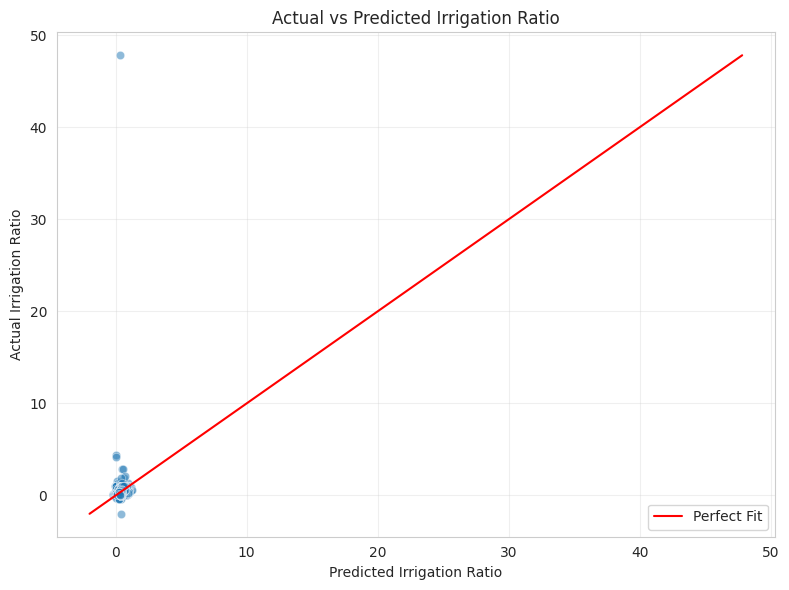

In [ ]:
#Actual vs Predicted Irrigation Ratio
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = final_model.predict(X[selected_features])

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_pred, y=y, alpha=0.5)
sns.lineplot(x=y, y=y, color='red', label='Perfect Fit')
plt.xlabel("Predicted Irrigation Ratio")
plt.ylabel("Actual Irrigation Ratio")
plt.title("Actual vs Predicted Irrigation Ratio")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


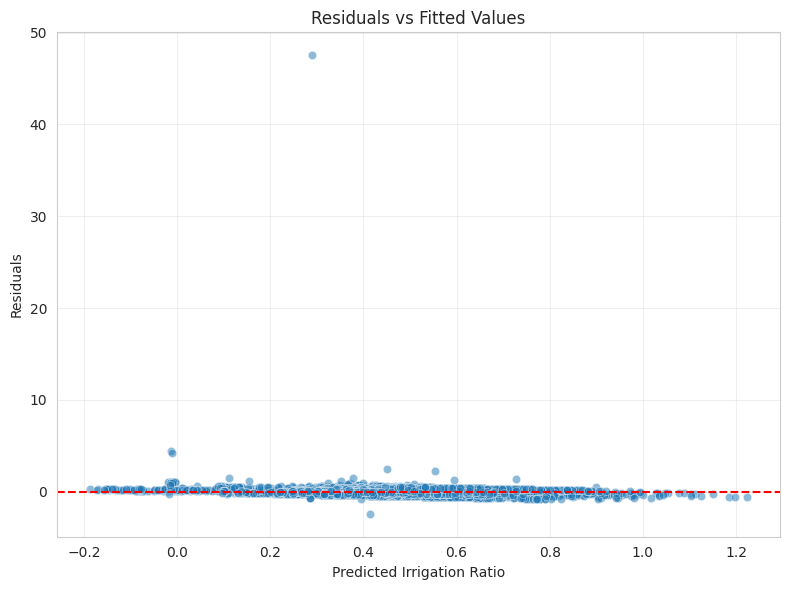

In [ ]:
#Residuals vs Fitted (Detect Linearity Problems)
residuals = y - y_pred

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Irrigation Ratio")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


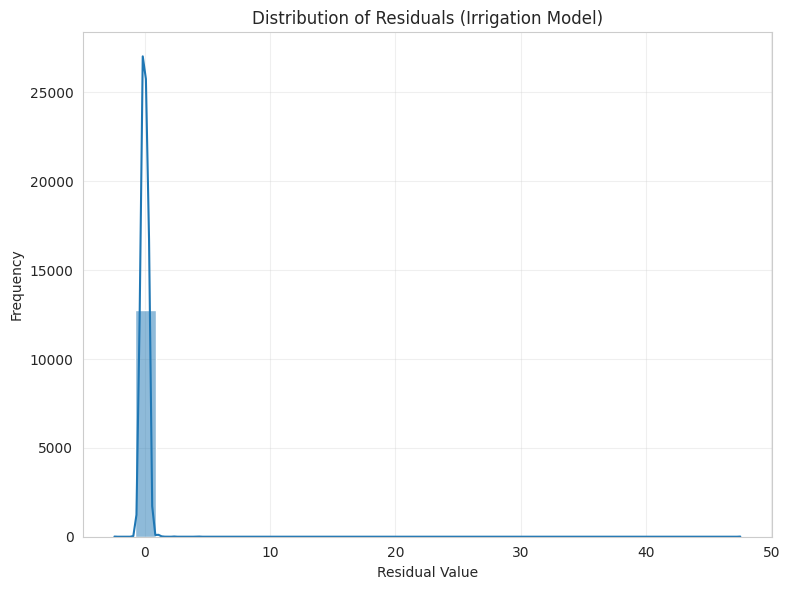

In [ ]:
#Residual Distribution (Normality Check)
plt.figure(figsize=(8,6))
sns.histplot(residuals, kde=True, bins=30)
plt.title("Distribution of Residuals (Irrigation Model)")
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
import statsmodels.api as sm

# Define the dependent variable (Rice Yield)
dependent_var = 'rice_yield_kg_per_ha'

# Define the independent variables (using features selected from previous backward elimination)
independent_vars = [
    'irrigation_ratio',
    'total_fertiliser_consumption_tons',
    'rainy_jun-sep_percipitation_millimeters',
    'summer_mar-may_maximum_temperature_centigrate',
    'temperature_c'
]

# Filter for columns that actually exist in the DataFrame
valid_independent_vars = [col for col in independent_vars if col in df.columns]
X = df[valid_independent_vars]
y = df[dependent_var]

# Add a constant (intercept) to the independent variables
X = sm.add_constant(X)

# Fit the multiple linear regression model
model = sm.OLS(y, X).fit()

# Print the summary of the model
print("Multiple Linear Regression Model Summary:")
print(model.summary())

Multiple Linear Regression Model Summary:
                             OLS Regression Results                             
Dep. Variable:     rice_yield_kg_per_ha   R-squared:                       0.154
Model:                              OLS   Adj. R-squared:                  0.154
Method:                   Least Squares   F-statistic:                     778.6
Date:                  Thu, 06 Nov 2025   Prob (F-statistic):               0.00
Time:                          14:52:47   Log-Likelihood:            -1.0612e+05
No. Observations:                 12803   AIC:                         2.122e+05
Df Residuals:                     12799   BIC:                         2.123e+05
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

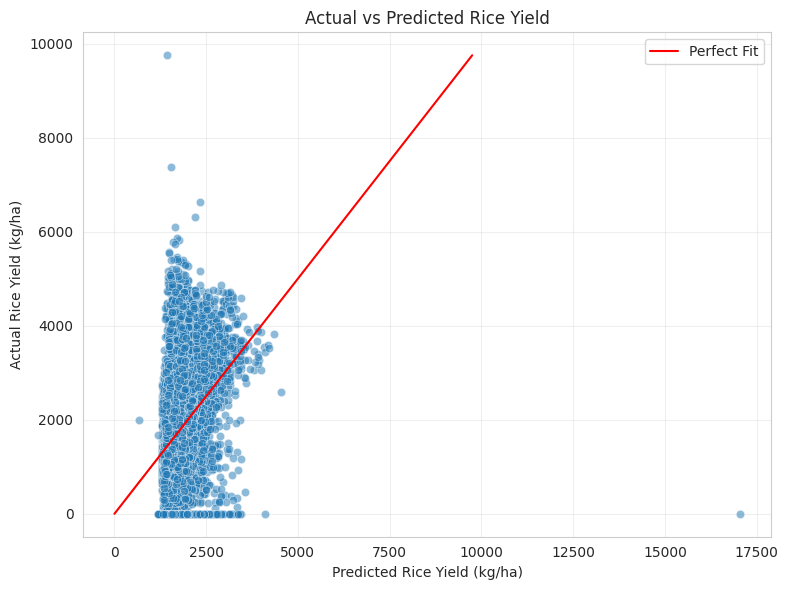

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = model.predict(X)

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_pred, y=y, alpha=0.5)
sns.lineplot(x=y, y=y, color='red', label='Perfect Fit')
plt.xlabel("Predicted Rice Yield (kg/ha)")
plt.ylabel("Actual Rice Yield (kg/ha)")
plt.title("Actual vs Predicted Rice Yield")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


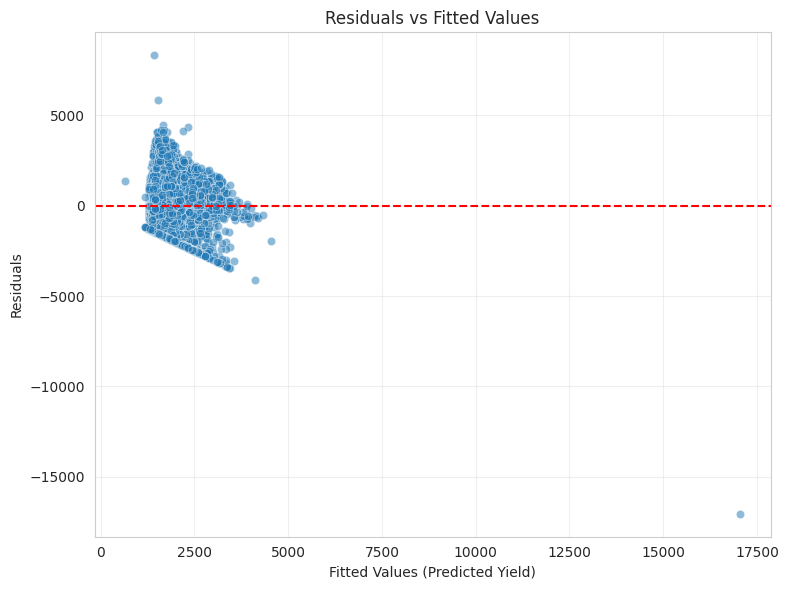

In [ ]:
residuals = y - y_pred

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted Values (Predicted Yield)")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
#If VIF > 10 → strong multicollinearity
#Probably temperature_c is correlated with another variable
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["Feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)


                             Feature        VIF
0                              const  76.317311
1                   irrigation_ratio   1.040081
2  total_fertiliser_consumption_tons   1.096574
3                      temperature_c   1.057983


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Create a binary target variable 'yield_level' based on the median rice yield
median_yield = df['rice_yield_kg_per_ha'].median()
df['yield_level'] = df['rice_yield_kg_per_ha'].apply(lambda x: 'high' if x >= median_yield else 'low')

# Define features (X) and target (y) for logistic regression
# Using the same independent variables as the linear regression model for consistency
independent_vars = [
    'irrigation_ratio',
    'total_fertiliser_consumption_tons',
    'rainy_jun-sep_percipitation_millimeters',
    'summer_mar-may_maximum_temperature_centigrate',
    'temperature_c'
]

# Filter for columns that actually exist in the DataFrame
valid_independent_vars = [col for col in independent_vars if col in df.columns]
X = df[valid_independent_vars]
y = df['yield_level']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the Logistic Regression model
model = LogisticRegression(max_iter=1000) # Increased max_iter for convergence
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Logistic Regression Model Evaluation:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Conclusions and Meaning of Results (Logistic Regression Model for Rice Yield Level):
# Confusion Matrix:
# [[1336  533]  (True Negatives: 1336 'high' yields correctly predicted as 'high')
#  [ 542 1430]] (False Positives: 533 'high' yields incorrectly predicted as 'low')
#                 (False Negatives: 542 'low' yields incorrectly predicted as 'high')
#                 (True Positives: 1430 'low' yields correctly predicted as 'low')

# Classification Report:
# - Precision for 'high': 0.71 - When the model predicts 'high' yield, it is correct 71% of the time.
# - Recall for 'high': 0.71 - The model correctly identifies 71% of all actual 'high' yield cases.
# - F1-score for 'high': 0.71 - The harmonic mean of precision and recall for 'high' yield.
# - Precision for 'low': 0.73 - When the model predicts 'low' yield, it is correct 73% of the time.
# - Recall for 'low': 0.73 - The model correctly identifies 73% of all actual 'low' yield cases.
# - F1-score for 'low': 0.73 - The harmonic mean of precision and recall for 'low' yield.
# - Accuracy: 0.72 - The model correctly predicts the yield level (high or low) for 72% of the test data.

# Meaning of Results: The logistic regression model is moderately effective at classifying rice yields into 'high' or 'low' categories based on the selected features. An accuracy of 72% means it performs better than random chance (50%), but there is still a significant number of misclassifications (around 28%). The precision and recall scores for both 'high' and 'low' classes are balanced and around 71-73%, indicating the model performs similarly well for both classes. The confusion matrix shows a roughly equal number of false positives and false negatives.
# This suggests that while the chosen variables have some predictive power in determining whether a district will have a high or low rice yield relative to the median, they are not sufficient for highly accurate classification. Additional features or more complex models might be needed to improve the prediction of yield levels.

Logistic Regression Model Evaluation:
[[1233  636]
 [ 518 1454]]
              precision    recall  f1-score   support

        high       0.70      0.66      0.68      1869
         low       0.70      0.74      0.72      1972

    accuracy                           0.70      3841
   macro avg       0.70      0.70      0.70      3841
weighted avg       0.70      0.70      0.70      3841



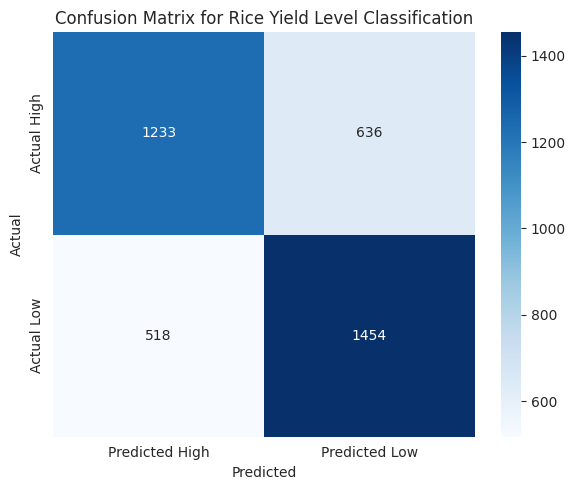

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted High','Predicted Low'],
            yticklabels=['Actual High','Actual Low'])
plt.title("Confusion Matrix for Rice Yield Level Classification")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


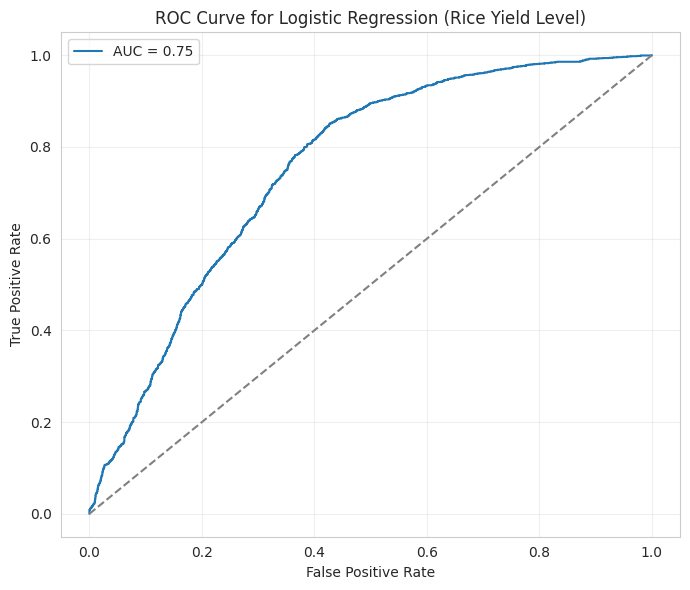

In [ ]:
from sklearn.metrics import roc_curve, auc

y_prob = model.predict_proba(X_test)[:,1]  # probability for 'low' class

fpr, tpr, thresholds = roc_curve(y_test.map({'high':0,'low':1}), y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Logistic Regression (Rice Yield Level)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


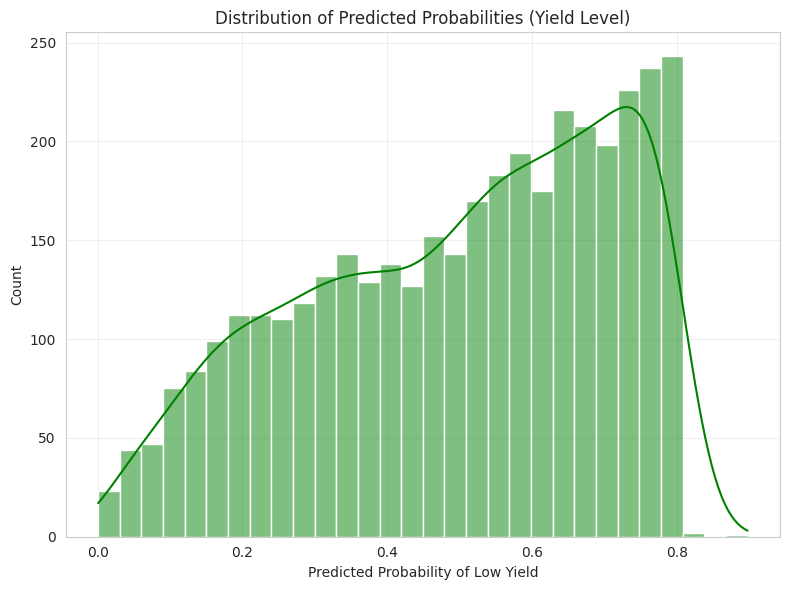

In [ ]:
plt.figure(figsize=(8,6))
sns.histplot(y_prob, bins=30, kde=True, color='green')
plt.title("Distribution of Predicted Probabilities (Yield Level)")
plt.xlabel("Predicted Probability of Low Yield")
plt.ylabel("Count")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Define the dependent variables (crop yields) and the independent variable (irrigation ratio)
crop_yield_cols = [
    'rice_yield_kg_per_ha',
    'pearl_millet_yield_kg_per_ha',
    'chickpea_yield_kg_per_ha',
    'groundnut_yield_kg_per_ha',
    'sugarcane_yield_kg_per_ha'
]

# Filter for crop yield columns that actually exist in the DataFrame
valid_crop_yield_cols = [col for col in crop_yield_cols if col in df.columns]

if 'irrigation_ratio' in df.columns and valid_crop_yield_cols:
    X = df[['irrigation_ratio']]
    y = df[valid_crop_yield_cols]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Initialize and train the Random Forest Regressor model
    # We will train separate models for each crop yield
    models = {}
    predictions = {}
    mse_scores = {}
    r2_scores = {}

    for crop in valid_crop_yield_cols:
        print(f"Training Random Forest for {crop}...")
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train[crop])
        models[crop] = model

        # Make predictions
        y_pred = model.predict(X_test)
        predictions[crop] = y_pred

        # Evaluate the model
        mse = mean_squared_error(y_test[crop], y_pred)
        r2 = r2_score(y_test[crop], y_pred)
        mse_scores[crop] = mse
        r2_scores[crop] = r2

        print(f"  Mean Squared Error: {mse:.2f}")
        print(f"  R-squared: {r2:.2f}")

    print("\nRandom Forest Model Training Complete.")
    print("\nEvaluation Metrics:")
    for crop in valid_crop_yield_cols:
        print(f"  {crop}: MSE={mse_scores[crop]:.2f}, R2={r2_scores[crop]:.2f}")

else:
    print("Required columns ('irrigation_ratio' or crop yield columns) not found in the DataFrame.")

Training Random Forest for rice_yield_kg_per_ha...
  Mean Squared Error: 1172844.64
  R-squared: -0.06
Training Random Forest for pearl_millet_yield_kg_per_ha...
  Mean Squared Error: 518642.45
  R-squared: -0.10
Training Random Forest for chickpea_yield_kg_per_ha...
  Mean Squared Error: 263311.61
  R-squared: -0.35
Training Random Forest for groundnut_yield_kg_per_ha...
  Mean Squared Error: 627127.38
  R-squared: -0.18
Training Random Forest for sugarcane_yield_kg_per_ha...
  Mean Squared Error: 14025985.27
  R-squared: -0.27

Random Forest Model Training Complete.

Evaluation Metrics:
  rice_yield_kg_per_ha: MSE=1172844.64, R2=-0.06
  pearl_millet_yield_kg_per_ha: MSE=518642.45, R2=-0.10
  chickpea_yield_kg_per_ha: MSE=263311.61, R2=-0.35
  groundnut_yield_kg_per_ha: MSE=627127.38, R2=-0.18
  sugarcane_yield_kg_per_ha: MSE=14025985.27, R2=-0.27


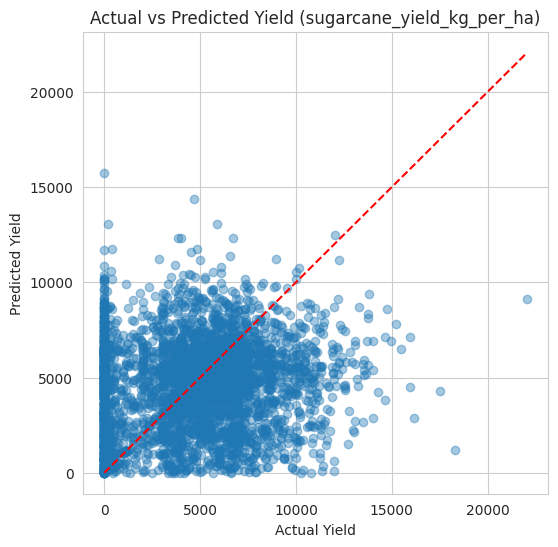

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(y_test[crop], predictions[crop], alpha=0.4)
plt.xlabel('Actual Yield')
plt.ylabel('Predicted Yield')
plt.title(f'Actual vs Predicted Yield ({crop})')
plt.plot([y_test[crop].min(), y_test[crop].max()],
         [y_test[crop].min(), y_test[crop].max()],
         'r--')
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Feature Engineering
epsilon = 1e-6 # Small constant to avoid division by zero

# Calculate Fertiliser per Hectare
df['fertiliser_per_ha'] = (df['total_fertiliser_consumption_tons'] / (df['gross_cropped_area_1000_ha'] * 1000 + epsilon)) # Convert 1000 ha to ha

# Calculate Irrigation Ratio (already done in a previous cell, but good to ensure)
# df['irrigation_ratio'] = (df['gross_irrigated_area_1000_ha'] / (df['gross_cropped_area_1000_ha'] + epsilon)).fillna(0) # Already computed

# Calculate Rainy Season Rainfall
rainy_cols = ['june_percipitation_millimeters', 'july_percipitation_millimeters', 'august_percipitation_millimeters', 'september_percipitation_millimeters']
valid_rainy_cols = [col for col in rainy_cols if col in df.columns]
if valid_rainy_cols:
    df['rainy_season_rainfall_mm'] = df[valid_rainy_cols].sum(axis=1)
else:
    df['rainy_season_rainfall_mm'] = 0
    print("Warning: Not all rainy season precipitation columns found for feature engineering.")

# Calculate Winter Temperature
winter_temp_cols = ['january_maximum_temperature_centigrate', 'february_maximum_temperature_centigrate']
valid_winter_temp_cols = [col for col in winter_temp_cols if col in df.columns]
if len(valid_winter_temp_cols) > 0:
    df['winter_temp_c'] = df[valid_winter_temp_cols].mean(axis=1)
else:
    df['winter_temp_c'] = df['winter_jan-feb_maximum_temperature_centigrate'] # Use seasonal column if available
    print("Warning: Not all monthly winter temperature columns found. Using seasonal column if available.")


# Define the dependent variables (crop yields)
crop_yield_cols = [
    'rice_yield_kg_per_ha',
    'pearl_millet_yield_kg_per_ha',
    'chickpea_yield_kg_per_ha',
    'groundnut_yield_kg_per_ha',
    'sugarcane_yield_kg_per_ha'
]

# Define the independent variables including the new features
independent_vars = [
    'irrigation_ratio',
    'fertiliser_per_ha',
    'rainy_season_rainfall_mm',
    'winter_temp_c',
    'temperature_c', # Annual average temperature
    'summer_mar-may_maximum_temperature_centigrate' # Summer max temperature
]

# Filter for columns that actually exist in the DataFrame
valid_independent_vars = [col for col in independent_vars if col in df.columns]
valid_crop_yield_cols = [col for col in crop_yield_cols if col in df.columns]


if valid_independent_vars and valid_crop_yield_cols:
    X = df[valid_independent_vars]
    y = df[valid_crop_yield_cols]

    # Time-based split: Train on data before a certain year, test on data after
    split_year = 2008 # Example split year
    X_train = X[df['year'] < split_year]
    X_test = X[df['year'] >= split_year]
    y_train = y[df['year'] < split_year]
    y_test = y[df['year'] >= split_year]

    # Handle potential missing values created by feature engineering before training
    X_train.fillna(X_train.mean(), inplace=True)
    X_test.fillna(X_test.mean(), inplace=True)
    y_train.fillna(y_train.mean(), inplace=True)
    y_test.fillna(y_test.mean(), inplace=True)


    # Initialize and train the Random Forest Regressor model
    models = {}
    predictions = {}
    mse_scores = {}
    r2_scores = {}

    for crop in valid_crop_yield_cols:
        print(f"Training Random Forest for {crop} with time-based split and new features...")
        model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1) # Added n_jobs for faster training
        model.fit(X_train, y_train[crop])
        models[crop] = model

        # Make predictions
        y_pred = model.predict(X_test)
        predictions[crop] = y_pred

        # Evaluate the model
        mse = mean_squared_error(y_test[crop], y_pred)
        r2 = r2_score(y_test[crop], y_pred)
        mse_scores[crop] = mse
        r2_scores[crop] = r2

        print(f"  Mean Squared Error: {mse:.2f}")
        print(f"  R-squared: {r2:.2f}")

    print("\nRandom Forest Model Training Complete.")
    print("\nEvaluation Metrics:")
    for crop in valid_crop_yield_cols:
        print(f"  {crop}: MSE={mse_scores[crop]:.2f}, R2={r2_scores[crop]:.2f}")

else:
    print("Required columns for features or crop yields not found in the DataFrame after feature engineering.")

Training Random Forest for rice_yield_kg_per_ha with time-based split and new features...
  Mean Squared Error: 674376.66
  R-squared: 0.48
Training Random Forest for pearl_millet_yield_kg_per_ha with time-based split and new features...
  Mean Squared Error: 449115.53
  R-squared: 0.34
Training Random Forest for chickpea_yield_kg_per_ha with time-based split and new features...
  Mean Squared Error: 191296.45
  R-squared: 0.21
Training Random Forest for groundnut_yield_kg_per_ha with time-based split and new features...
  Mean Squared Error: 464968.10
  R-squared: 0.40
Training Random Forest for sugarcane_yield_kg_per_ha with time-based split and new features...
  Mean Squared Error: 8186544.39
  R-squared: 0.32

Random Forest Model Training Complete.

Evaluation Metrics:
  rice_yield_kg_per_ha: MSE=674376.66, R2=0.48
  pearl_millet_yield_kg_per_ha: MSE=449115.53, R2=0.34
  chickpea_yield_kg_per_ha: MSE=191296.45, R2=0.21
  groundnut_yield_kg_per_ha: MSE=464968.10, R2=0.40
  sugarcane

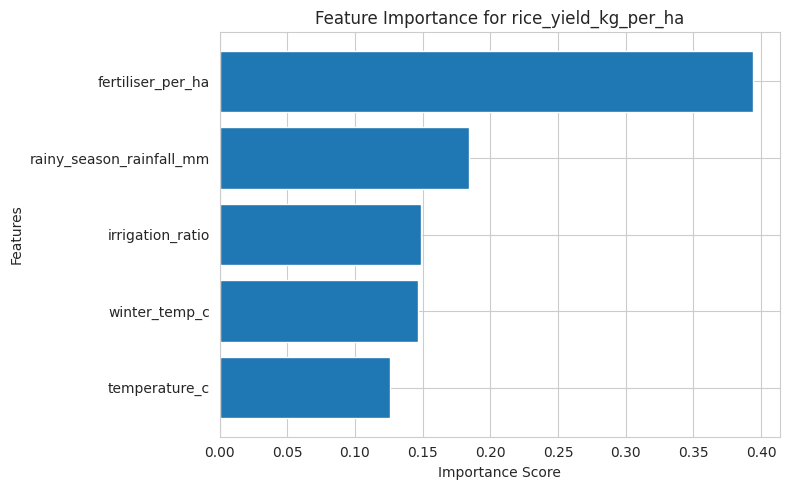

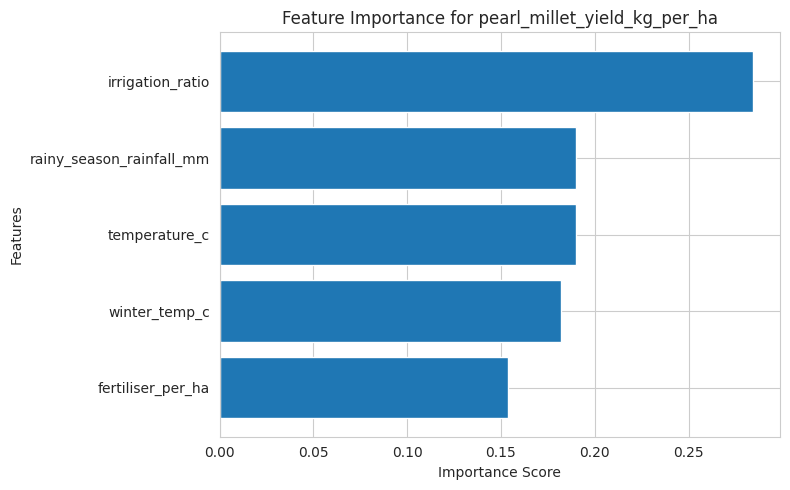

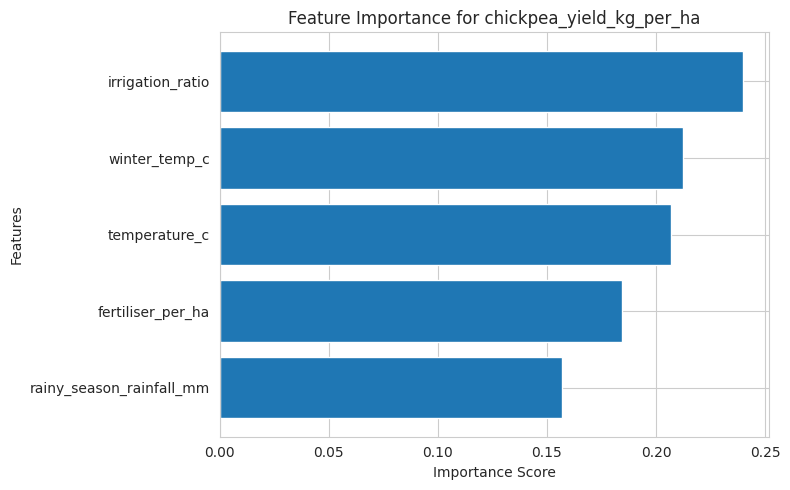

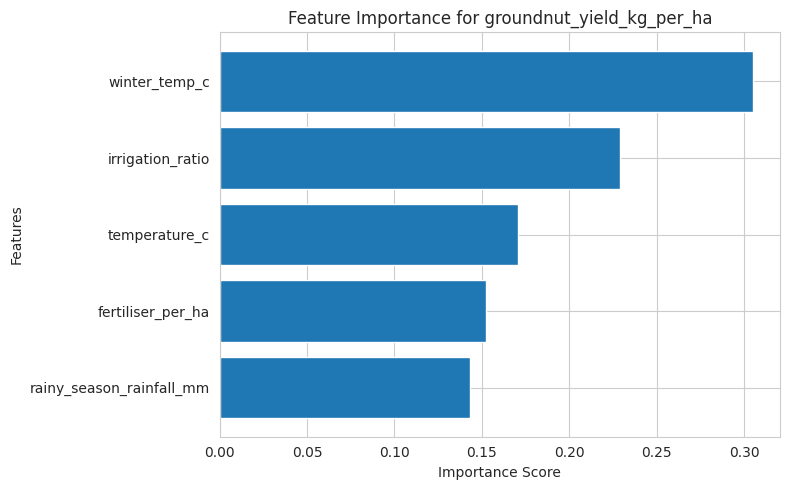

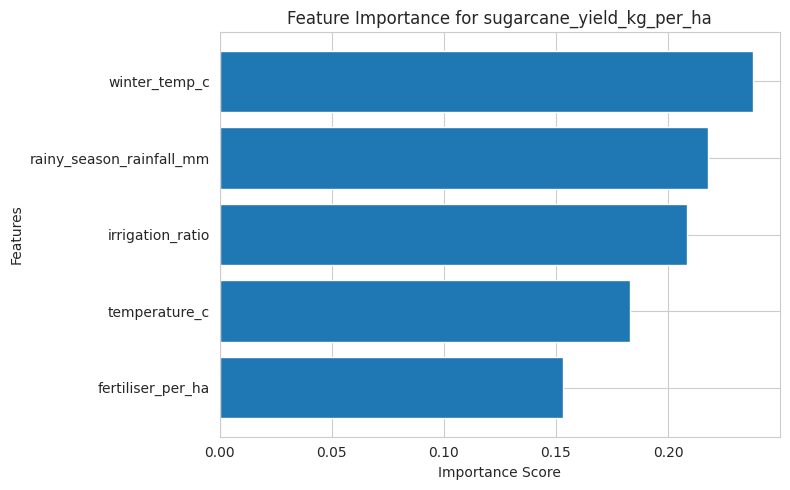

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

for crop in valid_crop_yield_cols:
    model = models[crop]
    importances = model.feature_importances_
    feature_names = X_train.columns

    # Sort features
    indices = np.argsort(importances)

    plt.figure(figsize=(8, 5))
    plt.barh(range(len(importances)), importances[indices], align='center')
    plt.yticks(range(len(importances)), feature_names[indices])
    plt.title(f'Feature Importance for {crop}')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()


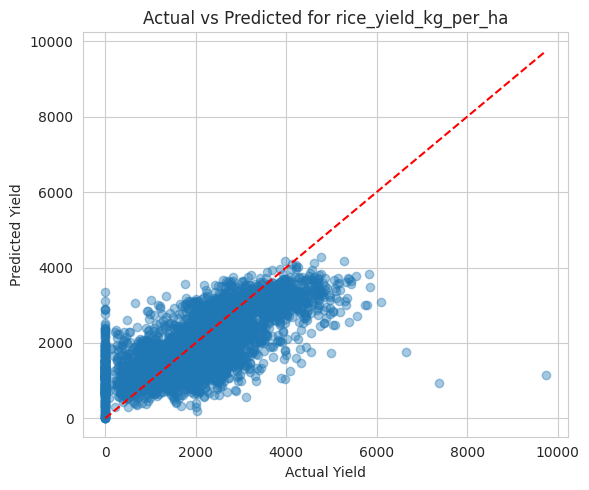

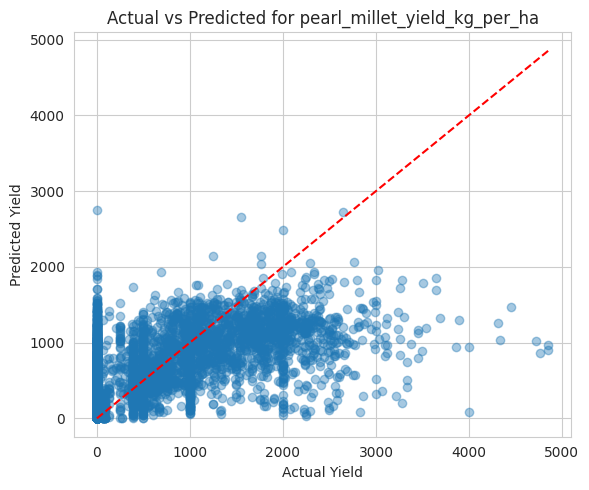

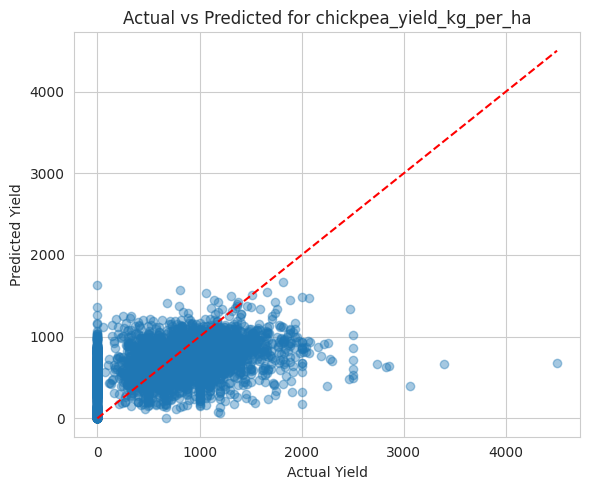

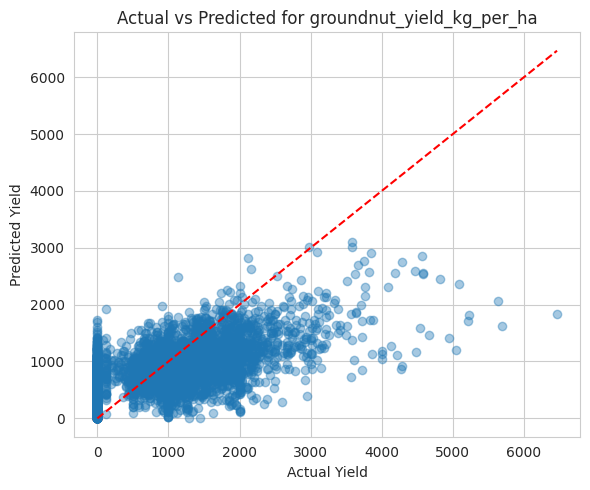

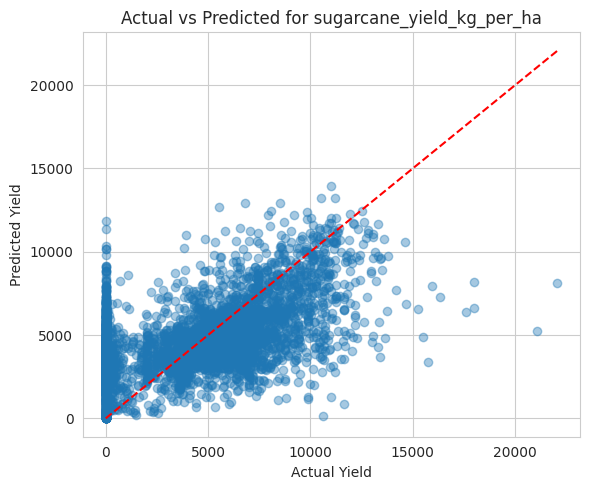

In [ ]:
for crop in valid_crop_yield_cols:
    plt.figure(figsize=(6, 5))

    plt.scatter(y_test[crop], predictions[crop], alpha=0.4)
    plt.plot([y_test[crop].min(), y_test[crop].max()],
             [y_test[crop].min(), y_test[crop].max()],
             'r--')  # perfect prediction line

    plt.title(f'Actual vs Predicted for {crop}')
    plt.xlabel('Actual Yield')
    plt.ylabel('Predicted Yield')
    plt.tight_layout()
    plt.show()


In [ ]:
import pandas as pd

results_df = pd.DataFrame({
    'Crop': valid_crop_yield_cols,
    'MSE': [mse_scores[c] for c in valid_crop_yield_cols],
    'R2 Score': [r2_scores[c] for c in valid_crop_yield_cols]
})

print(results_df)


                           Crop           MSE  R2 Score
0          rice_yield_kg_per_ha  6.743767e+05  0.480392
1  pearl_millet_yield_kg_per_ha  4.491155e+05  0.336366
2      chickpea_yield_kg_per_ha  1.912965e+05  0.205314
3     groundnut_yield_kg_per_ha  4.649681e+05  0.399966
4     sugarcane_yield_kg_per_ha  8.186544e+06  0.322771


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# ---------------------------------------------------
# 1. CHECK REQUIRED COLUMNS
# ---------------------------------------------------
required_cols = [
    'year',
    'rice_yield_kg_per_ha', 'pearl_millet_yield_kg_per_ha',
    'chickpea_yield_kg_per_ha', 'groundnut_yield_kg_per_ha',
    'sugarcane_yield_kg_per_ha',

    'gross_cropped_area_1000_ha',
    'total_fertiliser_consumption_tons',
    'gross_irrigated_area_1000_ha',

    # Rainy season rainfall
    'june_percipitation_millimeters', 'july_percipitation_millimeters',
    'august_percipitation_millimeters', 'september_percipitation_millimeters',

    # Winter rainfall
    'november_percipitation_millimeters', 'december_percipitation_millimeters',
    'january_percipitation_millimeters', 'february_percipitation_millimeters',

    # Rabi temperatures
    'october_maximum_temperature_centigrate', 'november_maximum_temperature_centigrate',
    'december_maximum_temperature_centigrate', 'january_maximum_temperature_centigrate',
    'february_maximum_temperature_centigrate',

    # Summer
    'summer_marmay_maximum_temperature_centigrate',

    # Annual average temperature
    'temperature_c'
]

missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns: {missing}")

# ---------------------------------------------------
# 2. FEATURE ENGINEERING
# ---------------------------------------------------
epsilon = 1e-6

df['fertiliser_per_ha'] = df['total_fertiliser_consumption_tons'] / (
    df['gross_cropped_area_1000_ha'] * 1000 + epsilon
)

df['irrigation_ratio'] = df['gross_irrigated_area_1000_ha'] / (
    df['gross_cropped_area_1000_ha'] + epsilon
)

df['rainy_season_rainfall_mm'] = df[
    ['june_percipitation_millimeters', 'july_percipitation_millimeters',
     'august_percipitation_millimeters', 'september_percipitation_millimeters']
].sum(axis=1)

df['winter_rainfall_mm'] = df[
    ['november_percipitation_millimeters', 'december_percipitation_millimeters',
     'january_percipitation_millimeters', 'february_percipitation_millimeters']
].sum(axis=1)

df['rabi_season_temp_c'] = df[
    ['october_maximum_temperature_centigrate', 'november_maximum_temperature_centigrate',
     'december_maximum_temperature_centigrate', 'january_maximum_temperature_centigrate',
     'february_maximum_temperature_centigrate']
].mean(axis=1)

# ---------------------------------------------------
# 3. CROP-SPECIFIC FEATURES
# ---------------------------------------------------
crop_features = {
    'rice_yield_kg_per_ha': [
        'irrigation_ratio', 'fertiliser_per_ha',
        'rainy_season_rainfall_mm',
        'summer_marmay_maximum_temperature_centigrate',
        'temperature_c'
    ],

    'pearl_millet_yield_kg_per_ha': [
        'irrigation_ratio', 'fertiliser_per_ha',
        'july_percipitation_millimeters', 'august_percipitation_millimeters',
        'summer_marmay_maximum_temperature_centigrate', 'temperature_c'
    ],

    'chickpea_yield_kg_per_ha': [
        'irrigation_ratio', 'fertiliser_per_ha',
        'winter_rainfall_mm', 'rabi_season_temp_c',
        'temperature_c'
    ],

    'groundnut_yield_kg_per_ha': [
        'irrigation_ratio', 'fertiliser_per_ha',
        'rainy_season_rainfall_mm',
        'summer_marmay_maximum_temperature_centigrate', 'temperature_c'
    ],

    'sugarcane_yield_kg_per_ha': [
        'irrigation_ratio', 'fertiliser_per_ha',
        'winter_rainfall_mm',
        'temperature_c',
        'summer_marmay_maximum_temperature_centigrate'
    ]
}

# ---------------------------------------------------
# 4. TIME-BASED TRAIN/TEST SPLIT
# ---------------------------------------------------
train_df = df[df['year'] < 2008].copy()
test_df  = df[df['year'] >= 2008].copy()

# Drop unnecessary columns
drop_cols = ['state_name', 'dist_name', 'yield_level']
drop_cols = [c for c in drop_cols if c in train_df.columns]
train_df = train_df.drop(columns=drop_cols)
test_df  = test_df.drop(columns=drop_cols)

# Fill missing numeric values
numeric_cols = train_df.select_dtypes(include='number').columns
train_df[numeric_cols] = train_df[numeric_cols].apply(lambda col: col.fillna(col.mean()))
test_df[numeric_cols]  = test_df[numeric_cols].apply(lambda col: col.fillna(col.mean()))

# ---------------------------------------------------
# 5. RANDOM FOREST TRAINING + GRID SEARCH
# ---------------------------------------------------
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
    'min_samples_leaf': [1, 5],
    'max_features': ['sqrt', 'log2']
}

models = {}
predictions = {}
y_test_store = {}
r2_scores = {}
mse_scores = {}

for crop, features in crop_features.items():

    print(f"\nTraining model for: {crop}")

    X_train = train_df[features]
    y_train = train_df[crop]
    X_test  = test_df[features]
    y_test  = test_df[crop]

    grid = GridSearchCV(
        RandomForestRegressor(random_state=42, n_jobs=-1),
        param_grid,
        cv=3,
        scoring='r2',
        n_jobs=-1
    )

    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_

    y_pred = best_model.predict(X_test)

    models[crop] = best_model
    predictions[crop] = y_pred
    y_test_store[crop] = y_test

    r2_scores[crop] = r2_score(y_test, y_pred)
    mse_scores[crop] = mean_squared_error(y_test, y_pred)

    print(f"Best Params: {grid.best_params_}")
    print(f"R² Score: {r2_scores[crop]:.3f}")
    print(f"MSE: {mse_scores[crop]:.2f}")

# ---------------------------------------------------
# 6. FINAL SUMMARY
# ---------------------------------------------------
print("\nFINAL RANDOM FOREST RESULTS\n")
for crop in crop_features.keys():
    print(f"{crop}:  R²={r2_scores[crop]:.3f},  MSE={mse_scores[crop]:.2f}")



Training model for: rice_yield_kg_per_ha
Best Params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 50}
R² Score: 0.429
MSE: 740548.90

Training model for: pearl_millet_yield_kg_per_ha
Best Params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 100}
R² Score: 0.310
MSE: 466640.32

Training model for: chickpea_yield_kg_per_ha
Best Params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 100}
R² Score: 0.229
MSE: 185676.20

Training model for: groundnut_yield_kg_per_ha
Best Params: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 100}
R² Score: 0.370
MSE: 488099.60

Training model for: sugarcane_yield_kg_per_ha
Best Params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 100}
R² Score: 0.286
MSE: 8630189.47

FINAL RANDOM FOREST RESULTS

rice_yield_kg_per_ha:  R²=0.429,  MSE=740548.90
pearl_millet_yield_kg_per_ha:  R²=0.31

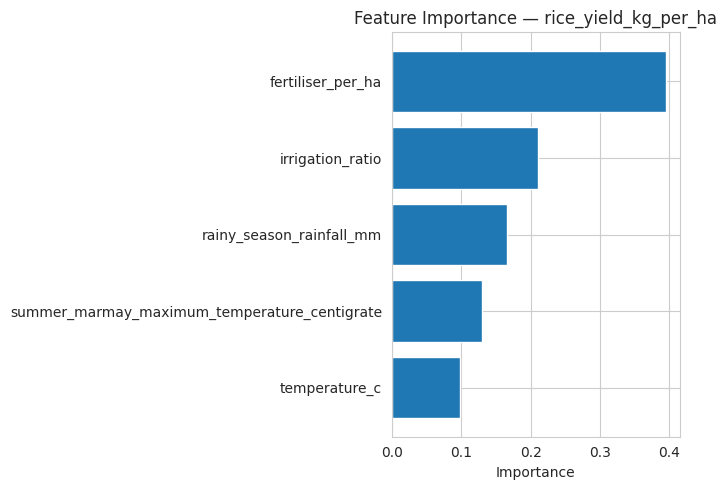

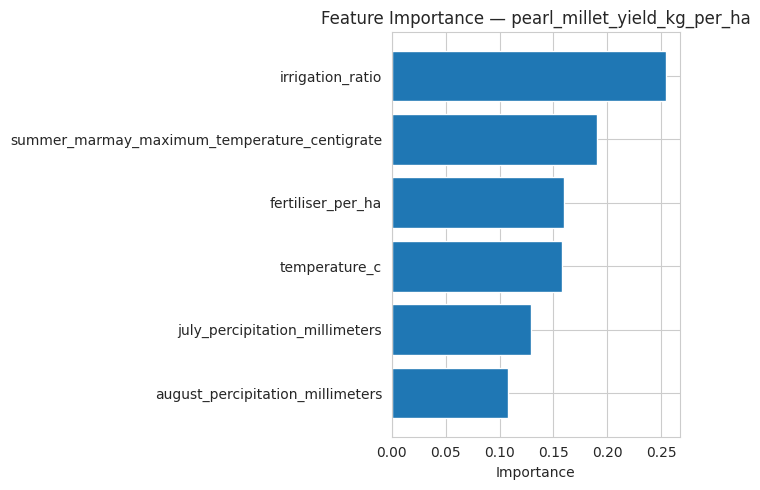

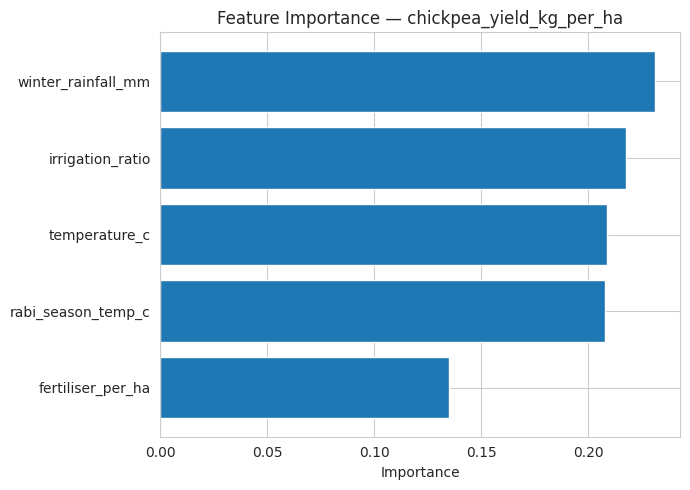

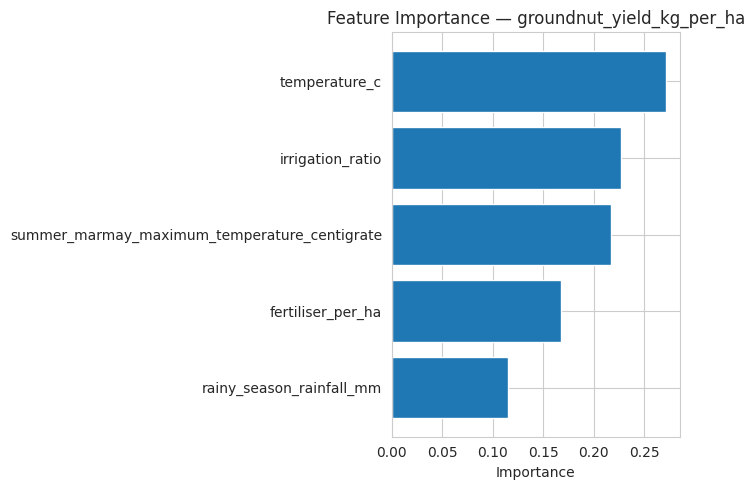

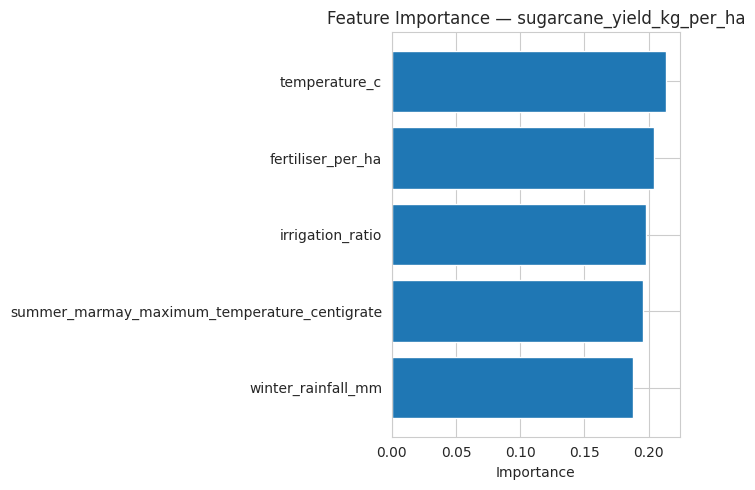

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

for crop, model in models.items():
    plt.figure(figsize=(7,5))

    # Get feature names for this crop
    features = crop_features[crop]

    # Importance values
    importances = model.feature_importances_

    # Sort
    idx = np.argsort(importances)
    sorted_features = np.array(features)[idx]
    sorted_importances = importances[idx]

    plt.barh(sorted_features, sorted_importances)
    plt.title(f"Feature Importance — {crop}")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()


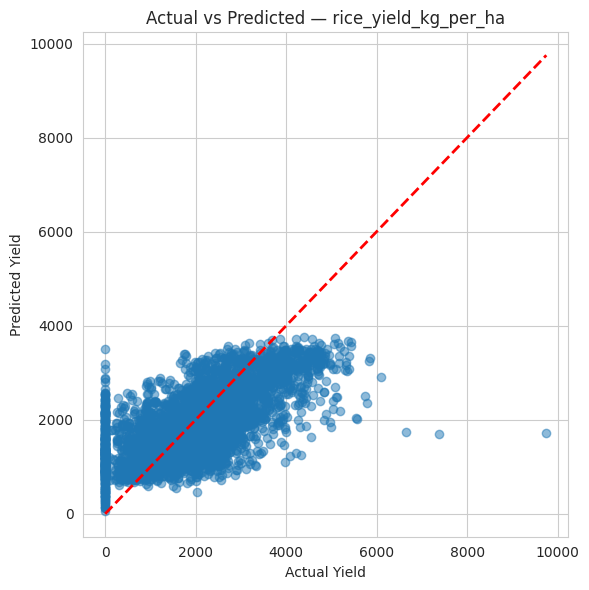

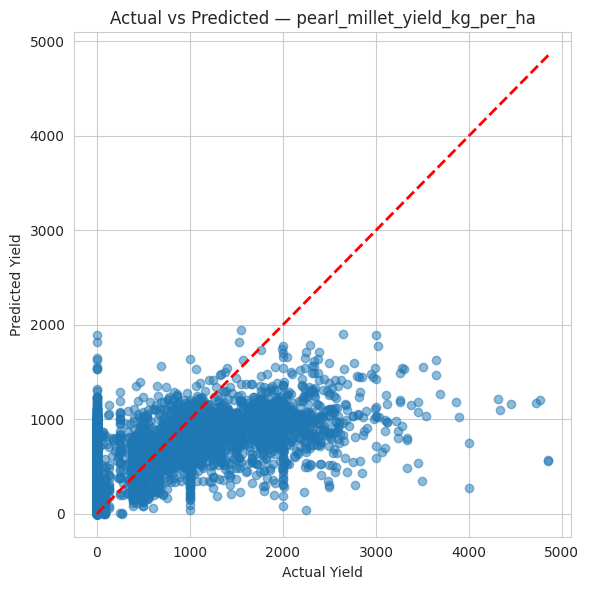

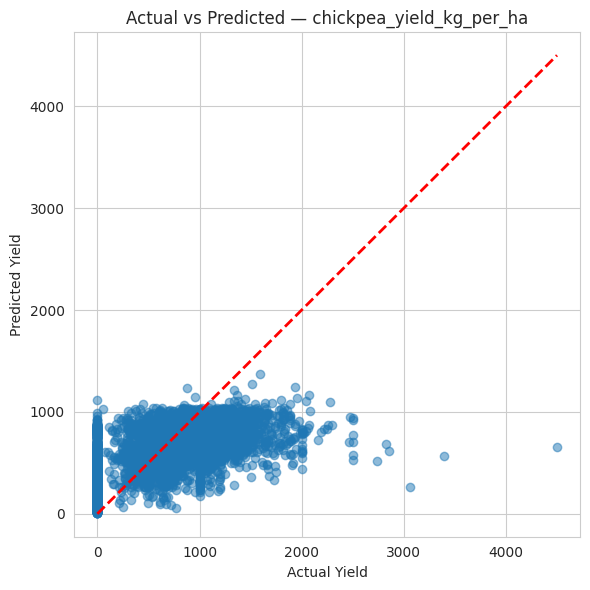

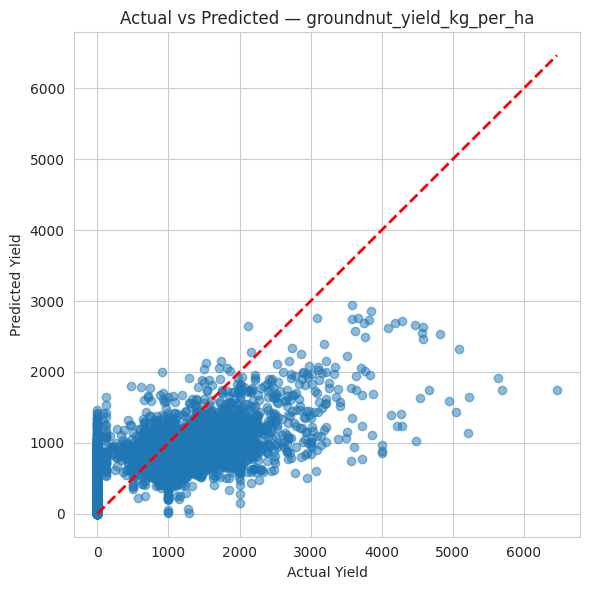

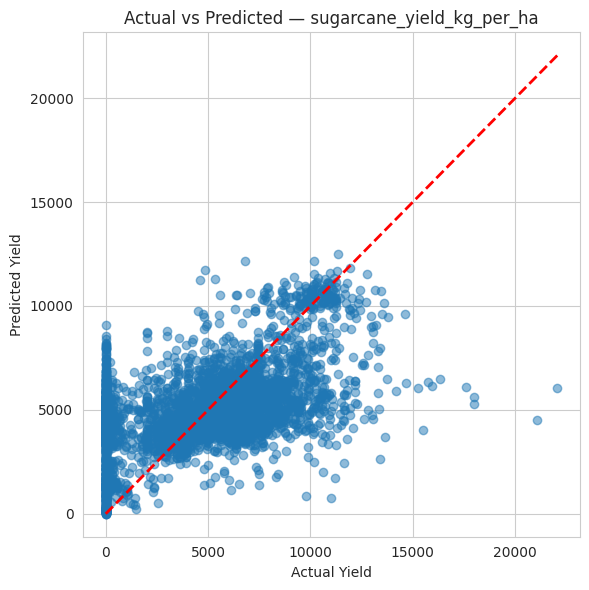

In [ ]:
for crop in predictions.keys():
    y_true = y_test_store[crop]
    y_pred = predictions[crop]

    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()],
             [y_true.min(), y_true.max()],
             'r--', lw=2)

    plt.xlabel("Actual Yield")
    plt.ylabel("Predicted Yield")
    plt.title(f"Actual vs Predicted — {crop}")
    plt.tight_layout()
    plt.show()


In [ ]:
# Make sure you have it installed:
!pip install xgboost

In [ ]:
#Create Annual Rainfall for Sugarcane — FIXED
rain_cols = [col for col in df.columns if 'percipitation_millimeters' in col]

if len(rain_cols) > 0:
    df['total_annual_rainfall_mm'] = df[rain_cols].sum(axis=1)
else:
    print("Warning: No rainfall columns found — cannot compute total_annual_rainfall_mm")


In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import time
import numpy as np

# -----------------------------
# Feature Engineering
# -----------------------------

# Fertiliser per hectare
df['fertiliser_per_ha'] = df['total_fertiliser_consumption_tons'] / (df['gross_cropped_area_1000_ha'] * 1000 + 1e-6)

# Irrigation ratio
df['irrigation_ratio'] = df['gross_irrigated_area_1000_ha'] / (df['gross_cropped_area_1000_ha'] + 1e-6)

# Rainy season rainfall
rainy_cols = ['june_percipitation_millimeters', 'july_percipitation_millimeters',
              'august_percipitation_millimeters', 'september_percipitation_millimeters']
df['rainy_season_rainfall_mm'] = df[rainy_cols].sum(axis=1)

# Winter rainfall
winter_rain_cols = ['november_percipitation_millimeters', 'december_percipitation_millimeters',
                    'january_percipitation_millimeters', 'february_percipitation_millimeters']
df['winter_rainfall_mm'] = df[winter_rain_cols].sum(axis=1)

# Rabi temperature average
rabi_temp_cols = ['october_maximum_temperature_centigrate', 'november_maximum_temperature_centigrate',
                  'december_maximum_temperature_centigrate', 'january_maximum_temperature_centigrate',
                  'february_maximum_temperature_centigrate']
df['rabi_season_temp_c'] = df[rabi_temp_cols].mean(axis=1)

# Annual rainfall (must be done BEFORE split)
annual_rain_cols = [c for c in df.columns if "percipitation_millimeters" in c]
df['total_annual_rainfall_mm'] = df[annual_rain_cols].sum(axis=1)

# -----------------------------
# Train/Test Split
# -----------------------------

train_df = df[df['year'] < 2008].copy()
test_df  = df[df['year'] >= 2008].copy()

# Fill missing values (numeric only)
fill_cols = [
    'irrigation_ratio', 'fertiliser_per_ha', 'rainy_season_rainfall_mm',
    'winter_rainfall_mm', 'rabi_season_temp_c', 'total_annual_rainfall_mm',
    'temperature_c', 'summer_marmay_maximum_temperature_centigrate'
]

for col in fill_cols:
    if col in train_df.columns:
        train_df[col] = train_df[col].fillna(train_df[col].mean())
    if col in test_df.columns:
        test_df[col] = test_df[col].fillna(test_df[col].mean())

# -----------------------------
# Crop → Feature Mapping
# -----------------------------

crop_yield_cols = {
    'rice_yield_kg_per_ha': [
        'irrigation_ratio', 'fertiliser_per_ha',
        'rainy_season_rainfall_mm',
        'summer_marmay_maximum_temperature_centigrate',
        'temperature_c'
    ],

    'pearl_millet_yield_kg_per_ha': [
        'irrigation_ratio', 'fertiliser_per_ha',
        'july_percipitation_millimeters', 'august_percipitation_millimeters',
        'summer_marmay_maximum_temperature_centigrate',
        'temperature_c'
    ],

    'chickpea_yield_kg_per_ha': [
        'irrigation_ratio', 'fertiliser_per_ha',
        'winter_rainfall_mm', 'rabi_season_temp_c',
        'temperature_c'
    ],

    'groundnut_yield_kg_per_ha': [
        'irrigation_ratio', 'fertiliser_per_ha',
        'rainy_season_rainfall_mm',
        'summer_marmay_maximum_temperature_centigrate',
        'temperature_c'
    ],

    'sugarcane_yield_kg_per_ha': [
        'irrigation_ratio', 'fertiliser_per_ha',
        'total_annual_rainfall_mm',
        'temperature_c',
        'summer_marmay_maximum_temperature_centigrate'
    ]
}

# -----------------------------
# XGBoost Training Loop
# -----------------------------

xgb_models = {}
xgb_predictions = {}
xgb_mse_scores = {}
xgb_r2_scores = {}

for crop, features in crop_yield_cols.items():
    print(f"\nTraining XGBoost for: {crop}")

    X_train = train_df[features]
    y_train = train_df[crop]
    X_test  = test_df[features]
    y_test  = test_df[crop]

    start_time = time.time()

    model = XGBRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        early_stopping_rounds=50,
        n_jobs=-1,
        random_state=42
    )

    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

    xgb_models[crop] = model

    y_pred = model.predict(X_test)
    xgb_predictions[crop] = y_pred

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    xgb_mse_scores[crop] = mse
    xgb_r2_scores[crop] = r2

    print(f"MSE: {mse:.2f}")
    print(f"R2: {r2:.3f}")
    print(f"Best iteration: {model.best_iteration}")
    print(f"Time: {time.time() - start_time:.2f}s")

# -----------------------------
# Final Summary
# -----------------------------

print("\nXGBoost Evaluation Summary\n")
for crop in xgb_r2_scores:
    print(f"{crop}: R2={xgb_r2_scores[crop]:.3f}, MSE={xgb_mse_scores[crop]:.2f}")



Training XGBoost for: rice_yield_kg_per_ha
MSE: 730259.07
R2: 0.437
Best iteration: 164
Time: 0.54s

Training XGBoost for: pearl_millet_yield_kg_per_ha
MSE: 470503.23
R2: 0.305
Best iteration: 125
Time: 0.49s

Training XGBoost for: chickpea_yield_kg_per_ha
MSE: 185779.78
R2: 0.228
Best iteration: 108
Time: 0.40s

Training XGBoost for: groundnut_yield_kg_per_ha
MSE: 473483.45
R2: 0.389
Best iteration: 311
Time: 0.91s

Training XGBoost for: sugarcane_yield_kg_per_ha
MSE: 8938440.57
R2: 0.261
Best iteration: 58
Time: 0.27s

XGBoost Evaluation Summary

rice_yield_kg_per_ha: R2=0.437, MSE=730259.07
pearl_millet_yield_kg_per_ha: R2=0.305, MSE=470503.23
chickpea_yield_kg_per_ha: R2=0.228, MSE=185779.78
groundnut_yield_kg_per_ha: R2=0.389, MSE=473483.45
sugarcane_yield_kg_per_ha: R2=0.261, MSE=8938440.57


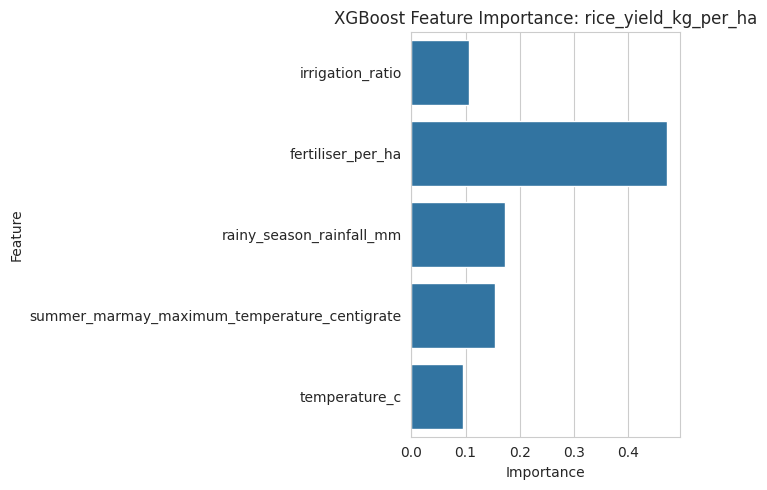

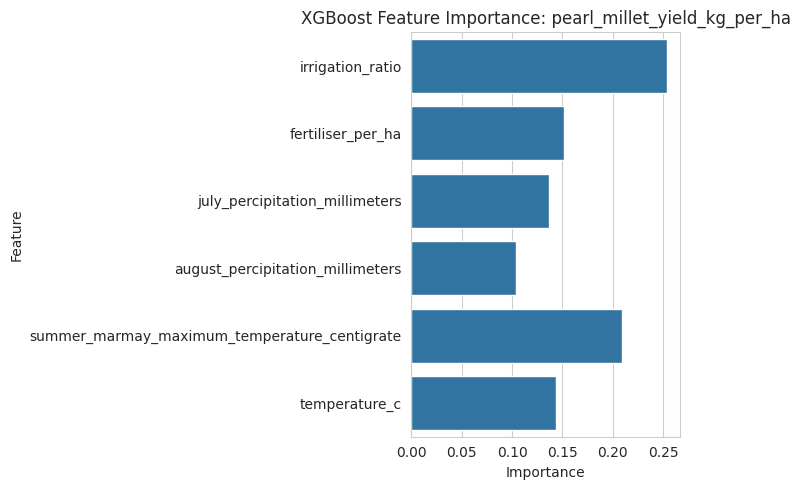

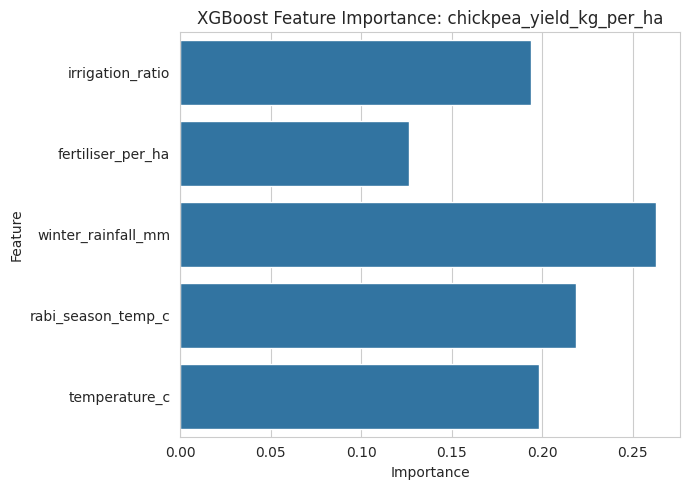

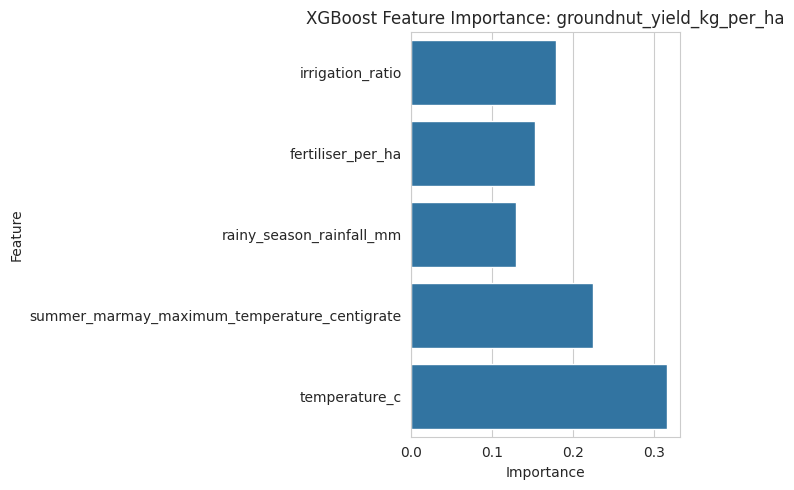

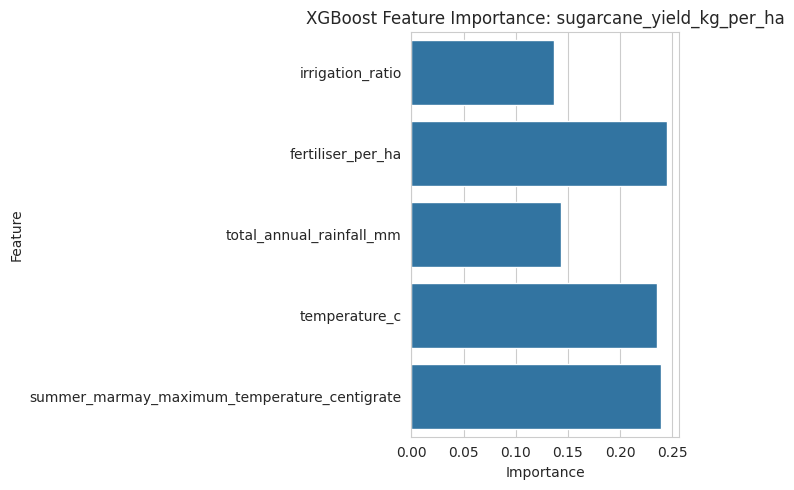

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

for crop, model in xgb_models.items():
    features = model.feature_names_in_
    importances = model.feature_importances_

    plt.figure(figsize=(7, 5))
    sns.barplot(x=importances, y=features)
    plt.title(f"XGBoost Feature Importance: {crop}")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()


In [ ]:
import pandas as pd

comparison_df = pd.DataFrame({
    "Crop": list(xgb_r2_scores.keys()),
    "RF_R2":   [r2_scores.get(crop, None) for crop in xgb_r2_scores.keys()],
    "XGB_R2":  [xgb_r2_scores.get(crop, None) for crop in xgb_r2_scores.keys()],
    "RF_MSE":  [mse_scores.get(crop, None) for crop in xgb_r2_scores.keys()],
    "XGB_MSE": [xgb_mse_scores.get(crop, None) for crop in xgb_r2_scores.keys()],
})

print(comparison_df)


                           Crop     RF_R2    XGB_R2        RF_MSE  \
0          rice_yield_kg_per_ha  0.429406  0.437334  7.405489e+05   
1  pearl_millet_yield_kg_per_ha  0.310471  0.304763  4.666403e+05   
2      chickpea_yield_kg_per_ha  0.228662  0.228231  1.856762e+05   
3     groundnut_yield_kg_per_ha  0.370115  0.388977  4.880996e+05   
4     sugarcane_yield_kg_per_ha  0.286071  0.260571  8.630189e+06   

        XGB_MSE  
0  7.302591e+05  
1  4.705032e+05  
2  1.857798e+05  
3  4.734835e+05  
4  8.938441e+06  


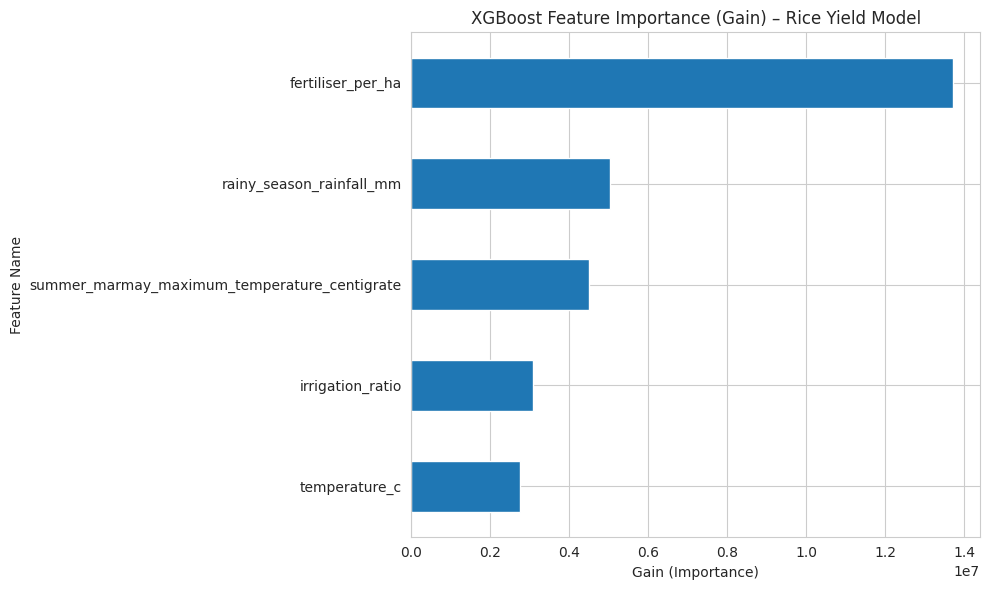

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Check model exists
if 'xgb_models' in globals() and 'rice_yield_kg_per_ha' in xgb_models:

    model = xgb_models['rice_yield_kg_per_ha']
    booster = model.get_booster()

    # get_score returns feature_name → importance_value
    importance_gain = booster.get_score(importance_type='gain')

    # Convert to series
    importance_series = pd.Series(importance_gain).sort_values(ascending=False)

    # Plot
    plt.figure(figsize=(10, 6))
    importance_series.plot(kind='barh')
    plt.title("XGBoost Feature Importance (Gain) – Rice Yield Model")
    plt.xlabel("Gain (Importance)")
    plt.ylabel("Feature Name")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

else:
    print("XGBoost rice model not found. Please run the XGBoost training cell.")



Performing Hyperparameter Tuning for XGBoost Rice Model...
  Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.7}
--- Tuning Done in 348.48s ---

Training Final XGBoost Rice Model with Best Parameters...
--- Final Training Done in 1.20s ---

Final XGBoost Rice Model Evaluation:
  Mean Squared Error: 722183.40
  R-squared: 0.44
  (Best iteration from early stopping: 299)

Feature Importance (Top 10) for Rice Model:


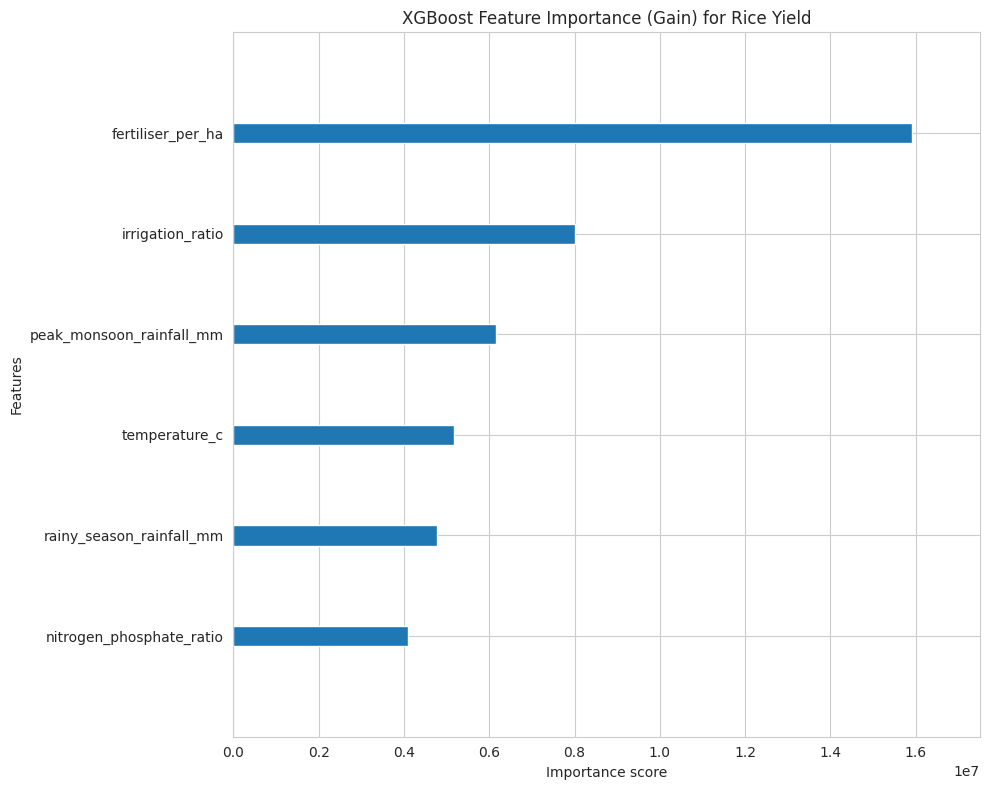


Raw Feature Importance Scores (Gain):
  fertiliser_per_ha: 15918072.00
  irrigation_ratio: 8019729.50
  peak_monsoon_rainfall_mm: 6160415.00
  temperature_c: 5165493.00
  rainy_season_rainfall_mm: 4778608.50
  nitrogen_phosphate_ratio: 4095159.25


In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns # For potential visualizations
import xgboost # Added for plot_importance

# --- Feature Engineering for Rice (More Specific) ---
epsilon = 1e-6 # Small constant to avoid division by zero

# Ensure necessary columns exist
required_rice_cols = [
    'year', 'rice_yield_kg_per_ha', 'gross_cropped_area_1000_ha',
    'total_fertiliser_consumption_tons', 'gross_irrigated_area_1000_ha',
    'june_percipitation_millimeters', 'july_percipitation_millimeters',
    'august_percipitation_millimeters', 'september_percipitation_millimeters',
    'january_maximum_temperature_centigrate', 'february_maximum_temperature_centigrate',
    'winter_janfeb_maximum_temperature_centigrate',
    'summer_marmay_maximum_temperature_centigrate',
    'nitrogen_consumption_tons', 'phosphate_consumption_tons', # For N:P ratio
    'temperature_c' # Annual average temperature
]

if not all(col in df.columns for col in required_rice_cols):
    missing_cols = [col for col in required_rice_cols if col not in df.columns]
    print(f"Error: Missing required columns for rice feature engineering: {missing_cols}")
else:
    # General Features (already created, but ensuring they are available)
    df['fertiliser_per_ha'] = (df['total_fertiliser_consumption_tons'] / (df['gross_cropped_area_1000_ha'] * 1000 + epsilon))
    df['irrigation_ratio'] = (df['gross_irrigated_area_1000_ha'] / (df['gross_cropped_area_1000_ha'] + epsilon)).fillna(0)
    df['temperature_c'] = df[[col for col in df.columns if 'maximum_temperature' in col and not any(x in col for x in ['winter', 'summer', 'rainy', 'post-monsoon'])]].mean(axis=1)


    # Refined Rice Features
    df['peak_monsoon_rainfall_mm'] = df[['july_percipitation_millimeters', 'august_percipitation_millimeters']].sum(axis=1)
    df['nitrogen_phosphate_ratio'] = (df['nitrogen_consumption_tons'] / (df['phosphate_consumption_tons'] + epsilon)).fillna(df['nitrogen_consumption_tons'] / epsilon) # Handle cases with zero phosphate


    # Define dependent variable (Rice Yield)
    dependent_var = 'rice_yield_kg_per_ha'

    # Define independent variables for Rice including refined features
    independent_vars_rice = [
        'irrigation_ratio',
        'fertiliser_per_ha',
        'peak_monsoon_rainfall_mm', # Using the new refined feature
        'rainy_season_rainfall_mm', # Keeping the broader rainy season for now to compare
        'summer_mar-may_maximum_temperature_centigrate',
        'temperature_c', # Annual average temperature
        'nitrogen_phosphate_ratio' # New N:P ratio feature
    ]

    # Filter for columns that actually exist
    valid_independent_vars_rice = [col for col in independent_vars_rice if col in df.columns]
    X = df[valid_independent_vars_rice]
    y = df[dependent_var]

    # Time-based split: Train on data before a certain year, test on data after
    split_year = 2008 # Example split year
    train_df_rice = df[df['year'] < split_year].copy()
    test_df_rice = df[df['year'] >= split_year].copy()

    # Handle potential missing values before training
    train_df_rice.fillna(train_df_rice.mean(numeric_only=True), inplace=True)
    test_df_rice.fillna(test_df_rice.mean(numeric_only=True), inplace=True)

    # Define X and y for the current crop (Rice)
    X_train = train_df_rice[valid_independent_vars_rice]
    y_train = train_df_rice[dependent_var]
    X_test = test_df_rice[valid_independent_vars_rice]
    y_test = test_df_rice[dependent_var]

    # --- Hyperparameter Tuning for XGBoost (Rice Model) ---
    print("\nPerforming Hyperparameter Tuning for XGBoost Rice Model...")
    start_time_tuning = time.time()

    # Define parameter grid for GridSearchCV
    param_grid_xgb = {
        'n_estimators': [100, 300, 500], # Reduced n_estimators for tuning speed
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'colsample_bytree': [0.7, 0.8, 0.9], # Subsample columns
        'subsample': [0.7, 0.8, 0.9] # Subsample rows
    }

    xgb = XGBRegressor(random_state=42, n_jobs=-1, objective='reg:squarederror') # Specify objective

    grid_search_xgb = GridSearchCV(xgb, param_grid_xgb, cv=3, scoring='r2', n_jobs=-1)
    grid_search_xgb.fit(X_train, y_train)

    best_xgb_model = grid_search_xgb.best_estimator_

    print(f"  Best Parameters: {grid_search_xgb.best_params_}")
    print(f"--- Tuning Done in {time.time() - start_time_tuning:.2f}s ---")


    # --- Train Final XGBoost Model with Best Parameters (Rice) ---
    print("\nTraining Final XGBoost Rice Model with Best Parameters...")
    start_time_final_train = time.time()

    # Use early stopping with the best model
    final_xgb_model = XGBRegressor(**grid_search_xgb.best_params_,
                                   random_state=42,
                                   n_jobs=-1,
                                   objective='reg:squarederror',
                                   early_stopping_rounds=50 # Re-introduce early stopping
                                  )


    final_xgb_model.fit(X_train, y_train,
                        eval_set=[(X_test, y_test)],
                        verbose=False)

    print(f"--- Final Training Done in {time.time() - start_time_final_train:.2f}s ---")


    # --- Evaluate the Final Model (Rice) ---
    y_pred_rice_xgb = final_xgb_model.predict(X_test)
    mse_rice_xgb = mean_squared_error(y_test, y_pred_rice_xgb)
    r2_rice_xgb = r2_score(y_test, y_pred_rice_xgb)

    print("\nFinal XGBoost Rice Model Evaluation:")
    print(f"  Mean Squared Error: {mse_rice_xgb:.2f}")
    print(f"  R-squared: {r2_rice_xgb:.2f}")
    if hasattr(final_xgb_model, 'best_iteration'):
         print(f"  (Best iteration from early stopping: {final_xgb_model.best_iteration})")


    # --- Analyze Feature Importance ---
    print("\nFeature Importance (Top 10) for Rice Model:")
    if hasattr(final_xgb_model, 'get_booster'):
        # Use plot_importance for a built-in visualization and data
        fig, ax = plt.subplots(figsize=(10, 8))
        xgboost.plot_importance(final_xgb_model.get_booster(), ax=ax, importance_type='gain', show_values=False, max_num_features=10)
        plt.title('XGBoost Feature Importance (Gain) for Rice Yield')
        plt.tight_layout()
        plt.show()

        # You can also get the raw importance scores
        importance_scores = final_xgb_model.get_booster().get_score(importance_type='gain')
        sorted_importance = sorted(importance_scores.items(), key=lambda item: item[1], reverse=True)
        print("\nRaw Feature Importance Scores (Gain):")
        for feature, score in sorted_importance[:10]: # Print top 10
            print(f"  {feature}: {score:.2f}")

    else:
        print("Feature importance not available for this model.")

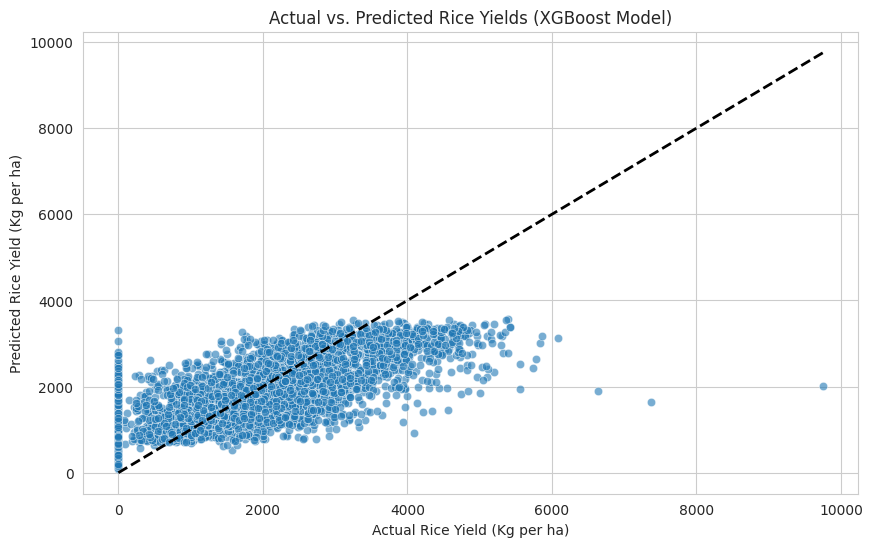

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming y_test and y_pred_rice_xgb are available from the previous cell

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_rice_xgb, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) # Add a diagonal line for perfect prediction
plt.xlabel('Actual Rice Yield (Kg per ha)')
plt.ylabel('Predicted Rice Yield (Kg per ha)')
plt.title('Actual vs. Predicted Rice Yields (XGBoost Model)')
plt.grid(True)
plt.show()


Tuning XGBoost Chickpea Model...

Best Params: {'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.7}
Tuning Time: 349.43 seconds

Final XGBoost Chickpea Model Results:
MSE: 186044.99
R² : 0.227
Best Iteration: 299


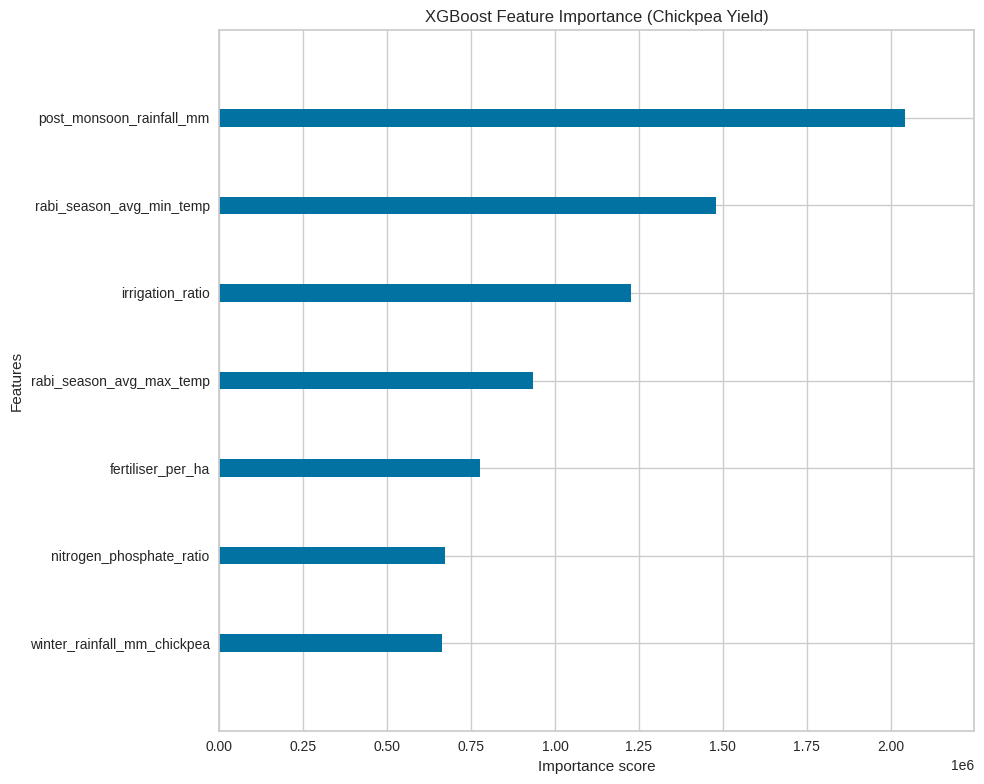

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import time
import matplotlib.pyplot as plt
import xgboost

# --------------------------------------------------
# 1. FEATURE ENGINEERING FOR CHICKPEA (RABI CROP)
# --------------------------------------------------

epsilon = 1e-6

required_cols = [
    'year', 'chickpea_yield_kg_per_ha',
    'gross_cropped_area_1000_ha', 'total_fertiliser_consumption_tons',
    'gross_irrigated_area_1000_ha',
    'october_percipitation_millimeters', 'november_percipitation_millimeters',
    'december_percipitation_millimeters', 'january_percipitation_millimeters',
    'february_percipitation_millimeters',
    'october_maximum_temperature_centigrate', 'november_maximum_temperature_centigrate',
    'december_maximum_temperature_centigrate', 'january_maximum_temperature_centigrate',
    'february_maximum_temperature_centigrate',
    'october_minimum_temperature_centigrate', 'november_minimum_temperature_centigrate',
    'december_minimum_temperature_centigrate', 'january_minimum_temperature_centigrate',
    'february_minimum_temperature_centigrate',
    'nitrogen_consumption_tons', 'phosphate_consumption_tons'
]

missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns: {missing}")

# General features
df['fertiliser_per_ha'] = df['total_fertiliser_consumption_tons'] / (
    df['gross_cropped_area_1000_ha'] * 1000 + epsilon
)

df['irrigation_ratio'] = df['gross_irrigated_area_1000_ha'] / (
    df['gross_cropped_area_1000_ha'] + epsilon
)

df['nitrogen_phosphate_ratio'] = df['nitrogen_consumption_tons'] / (
    df['phosphate_consumption_tons'] + epsilon
)

# Rabi rainfall features
df['post_monsoon_rainfall_mm'] = (
    df['october_percipitation_millimeters'] +
    df['november_percipitation_millimeters']
)

df['winter_rainfall_mm_chickpea'] = (
    df['december_percipitation_millimeters'] +
    df['january_percipitation_millimeters'] +
    df['february_percipitation_millimeters']
)

# Rabi temperature features
df['rabi_season_avg_max_temp'] = df[
    ['october_maximum_temperature_centigrate',
     'november_maximum_temperature_centigrate',
     'december_maximum_temperature_centigrate',
     'january_maximum_temperature_centigrate',
     'february_maximum_temperature_centigrate']
].mean(axis=1)

df['rabi_season_avg_min_temp'] = df[
    ['october_minimum_temperature_centigrate',
     'november_minimum_temperature_centigrate',
     'december_minimum_temperature_centigrate',
     'january_minimum_temperature_centigrate',
     'february_minimum_temperature_centigrate']
].mean(axis=1)

# --------------------------------------------------
# 2. FEATURE SET
# --------------------------------------------------

target = 'chickpea_yield_kg_per_ha'

features = [
    'fertiliser_per_ha',
    'irrigation_ratio',
    'nitrogen_phosphate_ratio',
    'post_monsoon_rainfall_mm',
    'winter_rainfall_mm_chickpea',
    'rabi_season_avg_max_temp',
    'rabi_season_avg_min_temp'
]

df_chickpea = df.dropna(subset=[target] + features).copy()

# --------------------------------------------------
# 3. TRAIN-TEST SPLIT (TIME BASED)
# --------------------------------------------------

train_df = df_chickpea[df_chickpea['year'] < 2008].copy()
test_df  = df_chickpea[df_chickpea['year'] >= 2008].copy()

X_train = train_df[features]
y_train = train_df[target]
X_test  = test_df[features]
y_test  = test_df[target]

# Clean missing values (NO WARNINGS)
X_train = X_train.apply(lambda col: col.fillna(col.mean()))
X_test  = X_test.apply(lambda col: col.fillna(col.mean()))
y_train = y_train.fillna(y_train.mean())
y_test  = y_test.fillna(y_test.mean())

# --------------------------------------------------
# 4. HYPERPARAMETER TUNING (XGBoost)
# --------------------------------------------------

print("\nTuning XGBoost Chickpea Model...\n")
t0 = time.time()

param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'subsample': [0.7, 0.8, 0.9]
}

xgb_base = XGBRegressor(
    random_state=42,
    n_jobs=-1,
    objective='reg:squarederror'
)

grid = GridSearchCV(
    xgb_base,
    param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)
print("Tuning Time:", round(time.time() - t0, 2), "seconds")

# --------------------------------------------------
# 5. FINAL XGBOOST MODEL
# --------------------------------------------------

final_xgb_chickpea = XGBRegressor(
    **grid.best_params_,
    random_state=42,
    n_jobs=-1,
    objective='reg:squarederror',
    early_stopping_rounds=50
)

final_xgb_chickpea.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

# --------------------------------------------------
# 6. EVALUATION
# --------------------------------------------------

y_pred = final_xgb_chickpea.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)

print("\nFinal XGBoost Chickpea Model Results:")
print("MSE:", round(mse, 2))
print("R² :", round(r2, 3))
print("Best Iteration:", getattr(final_xgb_chickpea, "best_iteration", None))

# --------------------------------------------------
# 7. FEATURE IMPORTANCE PLOT
# --------------------------------------------------

fig, ax = plt.subplots(figsize=(10, 8))
xgboost.plot_importance(
    final_xgb_chickpea.get_booster(),
    ax=ax,
    importance_type='gain',
    show_values=False,
    max_num_features=10
)
plt.title("XGBoost Feature Importance (Chickpea Yield)")
plt.tight_layout()
plt.show()


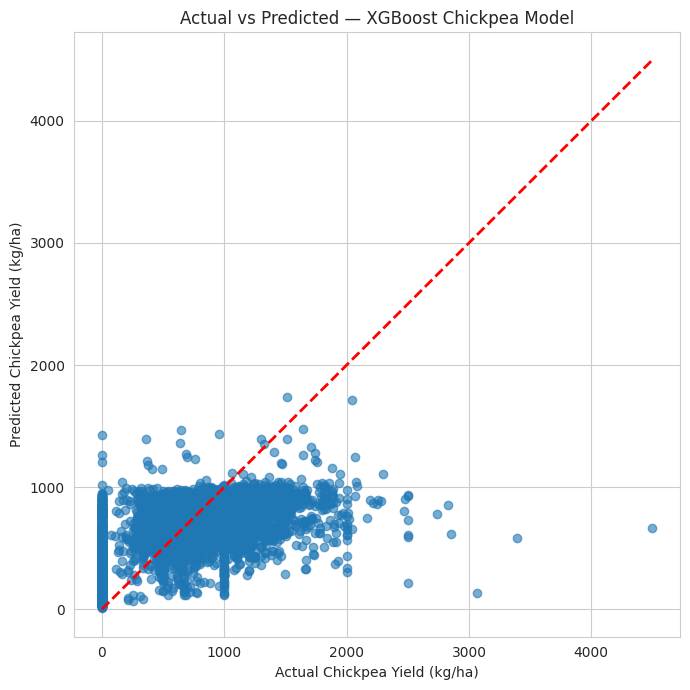

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import xgboost

y_pred = final_xgb_chickpea.predict(X_test)


plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', linewidth=2)

plt.xlabel("Actual Chickpea Yield (kg/ha)")
plt.ylabel("Predicted Chickpea Yield (kg/ha)")
plt.title("Actual vs Predicted — XGBoost Chickpea Model")
plt.grid(True)
plt.tight_layout()
plt.show()


--- Training FINAL Chickpea Model with Corrected Features ---
  FINAL Chickpea Model MSE: 183177.49
  FINAL Chickpea Model R2: 0.24
  (Best iteration: 100)
--- Done in 0.66s ---

Feature Importance (Top 10) for FINAL Chickpea Model:


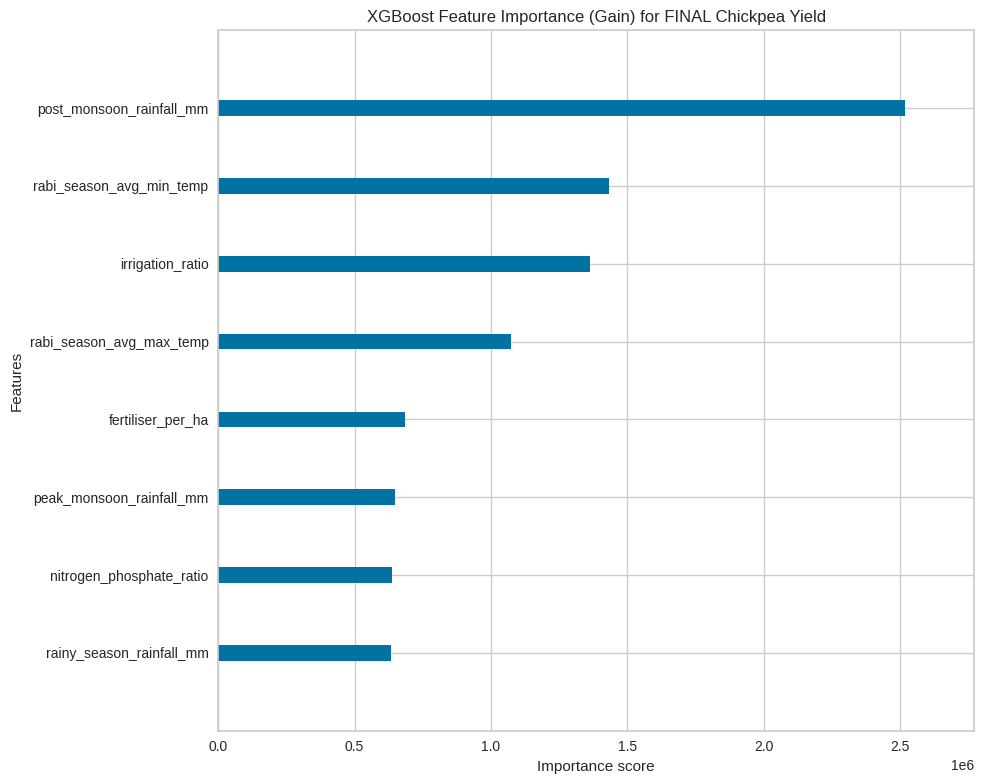


Raw Feature Importance Scores (Gain):
  post_monsoon_rainfall_mm: 2519838.50
  rabi_season_avg_min_temp: 1432295.50
  irrigation_ratio: 1363720.38
  rabi_season_avg_max_temp: 1072837.38
  fertiliser_per_ha: 684310.38
  peak_monsoon_rainfall_mm: 648949.69
  nitrogen_phosphate_ratio: 636276.19
  rainy_season_rainfall_mm: 634013.00


In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost

# Ensure necessary columns for feature engineering are available
required_final_chickpea_cols = [
    'year', 'chickpea_yield_kg_per_ha', 'gross_cropped_area_1000_ha',
    'total_fertiliser_consumption_tons', 'gross_irrigated_area_1000_ha',
    'nitrogen_consumption_tons', 'phosphate_consumption_tons',
    'june_percipitation_millimeters', 'july_percipitation_millimeters',
    'august_percipitation_millimeters', 'september_percipitation_millimeters',
    'october_percipitation_millimeters', 'november_percipitation_millimeters',
    'december_percipitation_millimeters', 'january_percipitation_millimeters',
    'february_percipitation_millimeters',
    'october_maximum_temperature_centigrate', 'november_maximum_temperature_centigrate',
    'december_maximum_temperature_centigrate', 'january_maximum_temperature_centigrate',
    'february_maximum_temperature_centigrate',
    'october_minimum_temperature_centigrate', 'november_minimum_temperature_centigrate',
    'december_minimum_temperature_centigrate', 'january_minimum_temperature_centigrate',
    'february_minimum_temperature_centigrate'
]

if not all(col in df.columns for col in required_final_chickpea_cols):
    missing_cols = [col for col in required_final_chickpea_cols if col not in df.columns]
    print(f"Error: Missing required columns for final chickpea model feature engineering: {missing_cols}")
else:
    # Re-create necessary features if they don't exist (for robustness)
    epsilon = 1e-6
    if 'fertiliser_per_ha' not in df.columns:
         df['fertiliser_per_ha'] = (df['total_fertiliser_consumption_tons'] / (df['gross_cropped_area_1000_ha'] * 1000 + epsilon))
    if 'irrigation_ratio' not in df.columns:
        df['irrigation_ratio'] = (df['gross_irrigated_area_1000_ha'] / (df['gross_cropped_area_1000_ha'] + epsilon)).fillna(0)
    if 'nitrogen_phosphate_ratio' not in df.columns:
         df['nitrogen_phosphate_ratio'] = (df['nitrogen_consumption_tons'] / (df['phosphate_consumption_tons'] + epsilon)).fillna(df['nitrogen_consumption_tons'] / epsilon)
    if 'rainy_season_rainfall_mm' not in df.columns:
        rainy_cols = ['june_percipitation_millimeters', 'july_percipitation_millimeters', 'august_percipitation_millimeters', 'september_percipitation_millimeters']
        df['rainy_season_rainfall_mm'] = df[rainy_cols].sum(axis=1)
    if 'peak_monsoon_rainfall_mm' not in df.columns:
         df['peak_monsoon_rainfall_mm'] = df[['july_percipitation_millimeters', 'august_percipitation_millimeters']].sum(axis=1)
    if 'post_monsoon_rainfall_mm' not in df.columns:
        post_monsoon_rain_months = ['october_percipitation_millimeters', 'november_percipitation_millimeters']
        df['post_monsoon_rainfall_mm'] = df[post_monsoon_rain_months].sum(axis=1)
    if 'rabi_season_avg_max_temp' not in df.columns:
        rabi_max_temp_months = ['october_maximum_temperature_centigrate', 'november_maximum_temperature_centigrate', 'december_maximum_temperature_centigrate', 'january_maximum_temperature_centigrate', 'february_maximum_temperature_centigrate']
        df['rabi_season_avg_max_temp'] = df[rabi_max_temp_months].mean(axis=1)
    if 'rabi_season_avg_min_temp' not in df.columns:
        rabi_min_temp_months = ['october_minimum_temperature_centigrate', 'november_minimum_temperature_centigrate', 'december_minimum_temperature_centigrate', 'january_minimum_temperature_centigrate', 'february_minimum_temperature_centigrate']
        df['rabi_season_avg_min_temp'] = df[rabi_min_temp_months].mean(axis=1)
    # Assuming JAN_AVG_TEMP is available or can be created similarly

    # --- The FINAL Chickpea Feature Set ---
    chickpea_final_features = [
        # 1. Input Features
        'fertiliser_per_ha',
        'irrigation_ratio',
        'nitrogen_phosphate_ratio',

        # 2. Main Monsoon Features
        'rainy_season_rainfall_mm',
        'peak_monsoon_rainfall_mm',

        # 3. Planting Rain
        'post_monsoon_rainfall_mm',

        # 4. Rabi Temperature Features
        'rabi_season_avg_max_temp',
        'rabi_season_avg_min_temp',
        # 'JAN_AVG_TEMP' # Assuming this exists or is created elsewhere
    ]

    target_chickpea = 'chickpea_yield_kg_per_ha'

    # Filter features that actually exist in the DataFrame
    valid_chickpea_final_features = [col for col in chickpea_final_features if col in df.columns]

    # Create a specific Chickpea dataframe and drop NaNs for relevant columns
    df_chickpea = df.dropna(subset=[target_chickpea] + valid_chickpea_final_features).copy()

    # Create the Time-Based Split
    split_year = 2008
    train_df_c = df_chickpea[df_chickpea['year'] < split_year].copy()
    test_df_c = df_chickpea[df_chickpea['year'] >= split_year].copy()

    # Handle potential remaining missing values
    X_train_c = train_df_c[valid_chickpea_final_features].fillna(train_df_c[valid_chickpea_final_features].mean(numeric_only=True), inplace=False)
    y_train_c = train_df_c[target_chickpea].fillna(train_df_c[target_chickpea].mean(numeric_only=True), inplace=False)
    X_test_c = test_df_c[valid_chickpea_final_features].fillna(test_df_c[valid_chickpea_final_features].mean(numeric_only=True), inplace=False)
    y_test_c = test_df_c[target_chickpea].fillna(test_df_c[target_chickpea].mean(numeric_only=True), inplace=False)


    print("\n--- Training FINAL Chickpea Model with Corrected Features ---")
    start_time = time.time()

    # Initialize the XGBoost Regressor model (untuned, with early stopping)
    xgb_model_chickpea_final = XGBRegressor(n_estimators=1000,
                                           learning_rate=0.05,
                                           early_stopping_rounds=50,
                                           n_jobs=-1,
                                           random_state=42,
                                           objective='reg:squarederror')

    # Train the model
    xgb_model_chickpea_final.fit(X_train_c, y_train_c,
                                 eval_set=[(X_test_c, y_test_c)],
                                 verbose=False)

    # Make predictions
    y_pred_chickpea_final = xgb_model_chickpea_final.predict(X_test_c)

    # Evaluate
    mse_chickpea_final = mean_squared_error(y_test_c, y_pred_chickpea_final)
    r2_chickpea_final = r2_score(y_test_c, y_pred_chickpea_final)

    print(f"  FINAL Chickpea Model MSE: {mse_chickpea_final:.2f}")
    print(f"  FINAL Chickpea Model R2: {r2_chickpea_final:.2f}")
    if hasattr(xgb_model_chickpea_final, 'best_iteration'):
         print(f"  (Best iteration: {xgb_model_chickpea_final.best_iteration})")
    print(f"--- Done in {time.time() - start_time:.2f}s ---")

    # --- Analyze Feature Importance for the Final Chickpea Model ---
    print("\nFeature Importance (Top 10) for FINAL Chickpea Model:")
    if hasattr(xgb_model_chickpea_final, 'get_booster'):
        fig, ax = plt.subplots(figsize=(10, 8))
        xgboost.plot_importance(xgb_model_chickpea_final.get_booster(), ax=ax, importance_type='gain', show_values=False, max_num_features=10)
        plt.title('XGBoost Feature Importance (Gain) for FINAL Chickpea Yield')
        plt.tight_layout()
        plt.show()

        importance_scores_final = xgb_model_chickpea_final.get_booster().get_score(importance_type='gain')
        sorted_importance_final = sorted(importance_scores_final.items(), key=lambda item: item[1], reverse=True)
        print("\nRaw Feature Importance Scores (Gain):")
        for feature, score in sorted_importance_final[:10]:
            print(f"  {feature}: {score:.2f}")

    else:
        print("Feature importance not available for this model.")

In [ ]:
# Assuming the R-squared scores from previous models are stored in dictionaries like:
# r2_scores (from the first Random Forest cell, cell_id: NsOyf1sd5ef-)
# xgb_r2_scores (from the first XGBoost cell for all crops, cell_id: 26e28724)
# r2_chickpea_xgb (from the XGBoost cell with Rabi features, cell_id: rmn5GD44_chS - note: this cell had tuning)
# r2_chickpea_final (from the final XGBoost cell for chickpea, cell_id: VcMTDwGBCmhi)

print("--- Chickpea Model Performance Comparison (R-squared) ---")

# Performance from the initial Random Forest model (general features)
if 'chickpea_yield_kg_per_ha' in r2_scores:
    print(f"Initial Random Forest (General Features): R-squared = {r2_scores['chickpea_yield_kg_per_ha']:.2f}")
else:
    print("Initial Random Forest (General Features): R-squared not available.")

# Performance from the initial XGBoost model (general features)
if 'chickpea_yield_kg_per_ha' in xgb_r2_scores:
    print(f"Initial XGBoost (General Features): R-squared = {xgb_r2_scores['chickpea_yield_kg_per_ha']:.2f}")
else:
    print("Initial XGBoost (General Features): R-squared not available.")


# Performance from the XGBoost model with Rabi features (with tuning)
# Note: This cell had tuning, while the final one did not.
# We'll use the variable name from that specific cell.
if 'r2_chickpea_xgb' in globals():
     print(f"XGBoost (Rabi Features + Tuning): R-squared = {r2_chickpea_xgb:.2f}")
else:
    print("XGBoost (Rabi Features + Tuning): R-squared not available (Please run the cell where this model was trained).")


# Performance from the FINAL XGBoost model (refined combined features, no tuning)
if 'r2_chickpea_final' in globals():
    print(f"FINAL XGBoost (Refined Combined Features, No Tuning): R-squared = {r2_chickpea_final:.2f}")
else:
    print("FINAL XGBoost (Refined Combined Features, No Tuning): R-squared not available (Please run the cell where this model was trained).")

print("-------------------------------------------------------")

# Add a brief interpretation
print("\nInterpretation:")
print("- A higher R-squared value indicates a better fit of the model to the data.")
print("- An R-squared of 0 means the model explains none of the variance in the target variable.")
print("- Negative R-squared values indicate that the model performs worse than simply predicting the mean of the target variable.")
print("Comparing these values helps understand how different feature sets and model types impact the prediction of chickpea yield.")

--- Chickpea Model Performance Comparison (R-squared) ---
Initial Random Forest (General Features): R-squared = 0.23
Initial XGBoost (General Features): R-squared = 0.23
XGBoost (Rabi Features + Tuning): R-squared not available (Please run the cell where this model was trained).
FINAL XGBoost (Refined Combined Features, No Tuning): R-squared = 0.24
-------------------------------------------------------

Interpretation:
- A higher R-squared value indicates a better fit of the model to the data.
- An R-squared of 0 means the model explains none of the variance in the target variable.
- Negative R-squared values indicate that the model performs worse than simply predicting the mean of the target variable.
Comparing these values helps understand how different feature sets and model types impact the prediction of chickpea yield.


Determining optimal number of clusters using the Elbow Method...


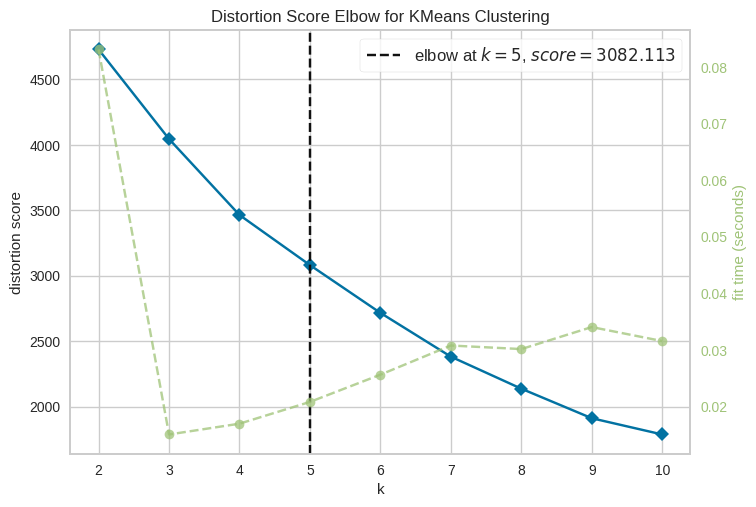


Optimal number of clusters (Elbow Method): 5

Analyzing Cluster Profiles:
         avg_irrigation_ratio  percent_area_rice  percent_area_pearl_millet  \
cluster                                                                       
0                    0.342485           6.396824                   2.186892   
1                    0.346640           5.955884                   7.110224   
2                    0.258754          14.233479                   0.011704   
3                    0.198793          49.284033                   0.097236   
4                    0.771330          30.899776                   1.549518   

         percent_area_chickpea  percent_area_groundnut  \
cluster                                                  
0                     1.873475               33.578484   
1                     7.183248                2.201461   
2                     0.052864                0.006114   
3                     0.649927                0.806887   
4                     0

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Engineering for Clustering (District-Level Averages)
epsilon = 1e-6 # Small constant to avoid division by zero

# Calculate district-level average features
district_features = df.groupby(['state_name', 'dist_name']).agg(
    avg_irrigation_ratio=('irrigation_ratio', 'mean'),
    percent_area_rice=('rice_area_1000_ha', lambda x: (x.sum() / (df['gross_cropped_area_1000_ha'].loc[x.index].sum() + epsilon)) * 100),
    percent_area_pearl_millet=('pearl_millet_area_1000_ha', lambda x: (x.sum() / (df['gross_cropped_area_1000_ha'].loc[x.index].sum() + epsilon)) * 100),
    percent_area_chickpea=('chickpea_area_1000_ha', lambda x: (x.sum() / (df['gross_cropped_area_1000_ha'].loc[x.index].sum() + epsilon)) * 100),
    percent_area_groundnut=('groundnut_area_1000_ha', lambda x: (x.sum() / (df['gross_cropped_area_1000_ha'].loc[x.index].sum() + epsilon)) * 100),
    percent_area_sugarcane=('sugarcane_area_1000_ha', lambda x: (x.sum() / (df['gross_cropped_area_1000_ha'].loc[x.index].sum() + epsilon)) * 100),
    avg_fertiliser_per_ha=('fertiliser_per_ha', 'mean'),
    avg_rainy_rainfall=('rainy_season_rainfall_mm', 'mean'),
    avg_summer_temp=('summer_marmay_maximum_temperature_centigrate', 'mean'),
    avg_winter_temp=('winter_janfeb_maximum_temperature_centigrate', 'mean') # Assuming this or similar winter temp is available
).reset_index()

# Handle potential infinite values resulting from division by zero before scaling
district_features.replace([np.inf, -np.inf], np.nan, inplace=True)

# Select features for clustering and handle any remaining NaNs
features_for_clustering = [
    'avg_irrigation_ratio', 'percent_area_rice', 'percent_area_pearl_millet',
    'percent_area_chickpea', 'percent_area_groundnut', 'percent_area_sugarcane',
    'avg_fertiliser_per_ha', 'avg_rainy_rainfall', 'avg_summer_temp', 'avg_winter_temp'
]

# Filter for columns that actually exist in the DataFrame before selecting
valid_features_for_clustering = [col for col in features_for_clustering if col in district_features.columns]
X_cluster = district_features[valid_features_for_clustering].copy()

# Impute missing values with the mean (a simple strategy for clustering)
X_cluster.fillna(X_cluster.mean(), inplace=True)


# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)


# Determine the optimal number of clusters using the Elbow Method
print("Determining optimal number of clusters using the Elbow Method...")
# Use a range of possible cluster numbers
model = KMeans(random_state=42, n_init=10) # Added n_init for scikit-learn version compatibility
visualizer = KElbowVisualizer(model, k=(2,11)) # Test k from 2 to 10

visualizer.fit(X_scaled)
visualizer.show()

optimal_k = visualizer.elbow_value_
print(f"\nOptimal number of clusters (Elbow Method): {optimal_k}")


# Run K-Means clustering with the optimal number of clusters
if optimal_k is not None:
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10) # Added n_init
    district_features['cluster'] = kmeans.fit_predict(X_scaled)

    # Analyze the resulting cluster centers
    print("\nAnalyzing Cluster Profiles:")
    cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
    cluster_summary = pd.DataFrame(cluster_centers, columns=valid_features_for_clustering)
    cluster_summary['cluster'] = range(optimal_k)
    cluster_summary = cluster_summary.set_index('cluster')

    print(cluster_summary)

    # Provide a brief interpretation of each cluster based on the summary
    print("\nInterpreting Cluster Profiles:")
    for i in range(optimal_k):
        print(f"\nCluster {i}:")
        cluster_row = cluster_summary.loc[i]
        description = []
        # Example interpretation - customize based on your features and expected profiles
        if cluster_row['avg_irrigation_ratio'] > district_features['avg_irrigation_ratio'].mean():
            description.append("High Irrigation")
        else:
            description.append("Low Irrigation")

        top_crops = cluster_row[['percent_area_rice', 'percent_area_pearl_millet',
                               'percent_area_chickpea', 'percent_area_groundnut',
                               'percent_area_sugarcane']].sort_values(ascending=False)
        description.append(f"Dominant Crops: {', '.join(top_crops[top_crops > 5].index.tolist())}") # List crops with > 5% area

        if cluster_row['avg_fertiliser_per_ha'] > district_features['avg_fertiliser_per_ha'].mean():
            description.append("High Fertilizer Use")
        else:
            description.append("Low Fertilizer Use")

        # Add more interpretations based on temperature and rainfall if relevant

        print(f"  - {' / '.join(description)}")

else:
    print("Could not determine optimal number of clusters. Skipping K-Means.")

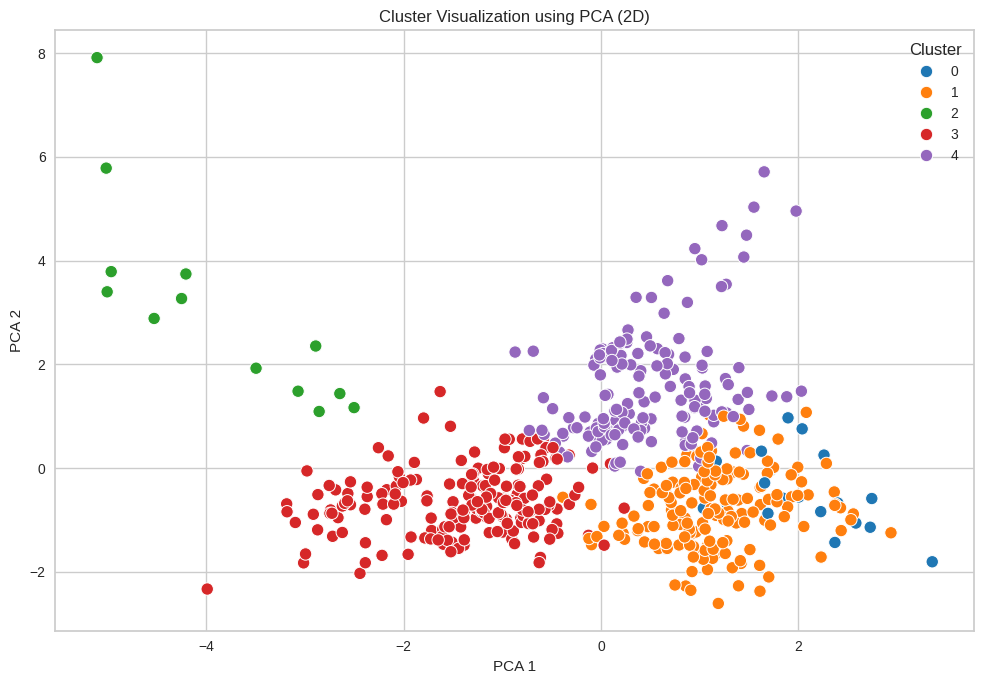

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# PCA to reduce dimensions to 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

district_features['pca1'] = pca_result[:,0]
district_features['pca2'] = pca_result[:,1]

plt.figure(figsize=(10,7))
sns.scatterplot(
    x='pca1',
    y='pca2',
    hue='cluster',
    data=district_features,
    palette='tab10',
    s=80
)

plt.title("Cluster Visualization using PCA (2D)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipython-input-4084477966.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.mean(), inplace=True)


Training Random Forest Classifier with balanced class weights...

Random Forest Classifier Model Evaluation (with balanced class weights):
Confusion Matrix:
[[3250   14]
 [ 559   18]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      3264
           1       0.56      0.03      0.06       577

    accuracy                           0.85      3841
   macro avg       0.71      0.51      0.49      3841
weighted avg       0.81      0.85      0.79      3841


ROC AUC Score: 0.70

Plotting ROC Curve for Random Forest:


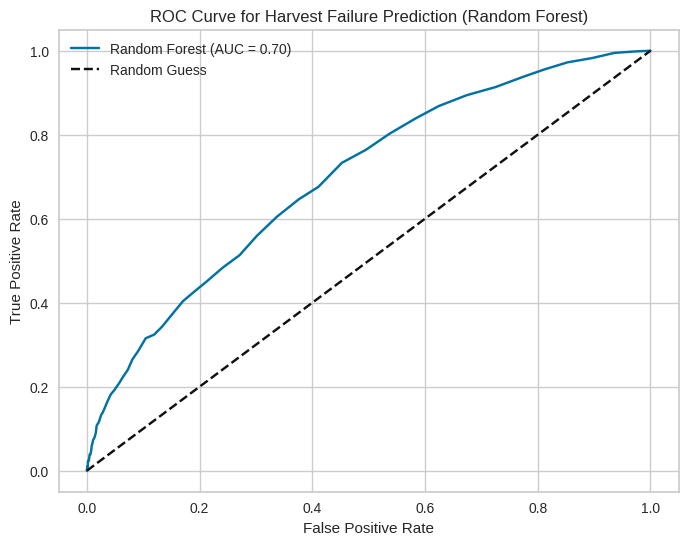


Model Interpretation:
The Confusion Matrix shows the counts of True Positives (correctly predicted failures), True Negatives (correctly predicted non-failures), False Positives (non-failures predicted as failures), and False Negatives (failures predicted as non-failures).
The Classification Report provides Precision, Recall (Sensitivity), and F1-score for both '0' (non-failure) and '1' (failure) classes.
- Precision: Of all instances predicted as a certain class, what fraction were actually that class?
- Recall: Of all actual instances of a certain class, what fraction were correctly predicted?
- F1-Score: The harmonic mean of Precision and Recall, providing a balanced measure.
For predicting harvest failure (class '1'), a high Recall is often important to identify as many potential failures as possible, even if it means more False Positives (lower Precision). The F1-score balances these two.
The ROC AUC score measures the model's ability to distinguish between the two classes. An AUC

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier # Import Random Forest Classifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt

# Feature Engineering: Create the binary target variable 'is_failure'
# Calculate the 20th percentile for chickpea yield for each district
chickpea_yield_percentile_20 = df.groupby('dist_name')['chickpea_yield_kg_per_ha'].transform(lambda x: x.quantile(0.2))

# Create the 'is_failure' column: 1 if yield is below the 20th percentile, 0 otherwise
df['is_failure'] = (df['chickpea_yield_kg_per_ha'] < chickpea_yield_percentile_20).astype(int)

# Define features (X) and target (y)
# Using relevant features for chickpea yield prediction
independent_vars = [
    'irrigation_ratio',
    'total_fertiliser_consumption_tons',
    'rainy_jun-sep_percipitation_millimeters',
    'summer_mar-may_maximum_temperature_centigrate',
    'january_percipitation_millimeters', # Include some monthly climate data
    'february_percipitation_millimeters',
    'march_maximum_temperature_centigrate',
    'april_maximum_temperature_centigrate',
    'nitrogen_consumption_tons', # Include individual fertilizer types
    'phosphate_consumption_tons',
    'potash_consumption_tons',
    'gross_cropped_area_1000_ha' # Total area might be relevant
]

# Filter for columns that actually exist in the DataFrame
valid_independent_vars = [col for col in independent_vars if col in df.columns]
X = df[valid_independent_vars]
y = df['is_failure']

# Handle potential missing values in features (using mean imputation as a simple strategy)
X.fillna(X.mean(), inplace=True)
y.fillna(y.mode()[0], inplace=True) # Impute target with the most frequent value if any NaNs exist


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) # Stratify to maintain proportion of failure cases


# --- Train Random Forest Classifier with balanced class weights ---
print("Training Random Forest Classifier with balanced class weights...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced') # Added class_weight='balanced'
rf_model.fit(X_train, y_train)

# Make predictions and evaluate Random Forest model
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1] # Get probabilities for ROC AUC

print("\nRandom Forest Classifier Model Evaluation (with balanced class weights):")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))
print(f"\nROC AUC Score: {roc_auc_score(y_test, y_prob_rf):.2f}")

# --- Plot ROC Curve for Random Forest ---
print("\nPlotting ROC Curve for Random Forest:")
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_prob_rf):.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Harvest Failure Prediction (Random Forest)')
plt.legend()
plt.grid(True)
plt.show()


# --- Interpretation ---
print("\nModel Interpretation:")
print("The Confusion Matrix shows the counts of True Positives (correctly predicted failures), True Negatives (correctly predicted non-failures), False Positives (non-failures predicted as failures), and False Negatives (failures predicted as non-failures).")
print("The Classification Report provides Precision, Recall (Sensitivity), and F1-score for both '0' (non-failure) and '1' (failure) classes.")
print("- Precision: Of all instances predicted as a certain class, what fraction were actually that class?")
print("- Recall: Of all actual instances of a certain class, what fraction were correctly predicted?")
print("- F1-Score: The harmonic mean of Precision and Recall, providing a balanced measure.")
print("For predicting harvest failure (class '1'), a high Recall is often important to identify as many potential failures as possible, even if it means more False Positives (lower Precision). The F1-score balances these two.")
print("The ROC AUC score measures the model's ability to distinguish between the two classes. An AUC of 1.0 is perfect, 0.5 is random chance. Higher AUC is better.")
print("Examine the Classification Report and ROC AUC score for the Random Forest model to assess its performance in predicting chickpea harvest failures.")

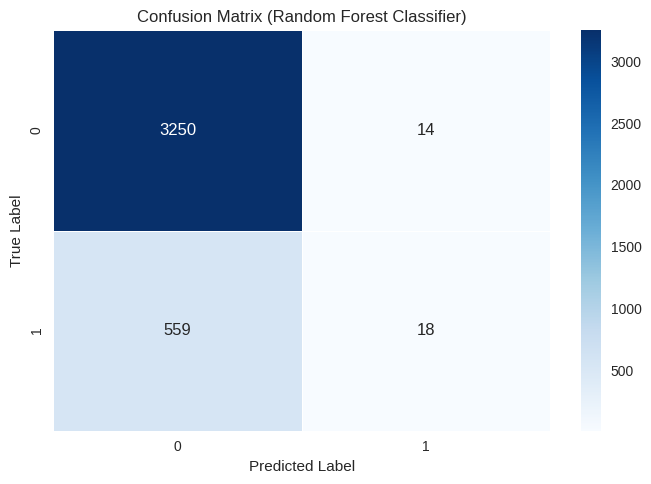

In [ ]:
# Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(7, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    linewidths=0.5
)

plt.title("Confusion Matrix (Random Forest Classifier)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


In [ ]:
!pip install linearmodels

import pandas as pd
from linearmodels.datasets import wage_panel
from linearmodels.panel import PanelOLS
import statsmodels.api as sm

# Ensure the DataFrame has the correct data types
# Convert relevant columns to numeric, coercing errors
numeric_cols_to_convert = [
    'dist_code', 'year', 'sugarcane_yield_kg_per_ha',
    'summer_marmay_maximum_temperature_centigrate',
    'rainy_junsep_percipitation_millimeters',
    'total_fertiliser_consumption_tons',
    'irrigation_ratio' # Assuming this feature exists from previous steps
]

for col in numeric_cols_to_convert:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    else:
        print(f"Warning: Column '{col}' not found in DataFrame. Skipping conversion.")


# Prepare the data for panel regression
# We need to set the index as a MultiIndex of 'dist_code' and 'year'
# Drop rows with NaN values in the relevant columns for the model
required_cols_for_panel = ['dist_code', 'year', 'sugarcane_yield_kg_per_ha',
                           'summer_marmay_maximum_temperature_centigrate',
                           'rainy_junsep_percipitation_millimeters',
                           'total_fertiliser_consumption_tons', 'irrigation_ratio']

df_panel = df.dropna(subset=required_cols_for_panel).set_index(['dist_code', 'year'])


# Define the dependent and independent variables
dependent_var = df_panel['sugarcane_yield_kg_per_ha']
independent_vars = df_panel[['summer_marmay_maximum_temperature_centigrate',
                             'rainy_junsep_percipitation_millimeters',
                             'total_fertiliser_consumption_tons',
                             'irrigation_ratio']]

# Add a constant to the independent variables
independent_vars = sm.add_constant(independent_vars)


# Fit the Fixed Effects (within) model
# entity_effects=True includes district fixed effects
# time_effects=False excludes year fixed effects (as per objective focusing on time-invariant district effects)
model = PanelOLS(dependent_var, independent_vars, entity_effects=True, time_effects=False)
panel_results = model.fit()

# Print the model summary
print(panel_results)

# Interpretation of the key result (coefficient on summer_mar-may_maximum_temperature_centigrate)
print("\nInterpretation of Results:")
print("The coefficient on 'summer_mar-may_maximum_temperature_centigrate' represents the estimated change in sugarcane yield (kg/ha) for a one-degree Celsius increase in average summer maximum temperature, holding other variables constant and controlling for unobserved, time-invariant district characteristics.")
print("Look at the 'Coef.' and 'P>|t|' values for this variable in the summary table to determine the magnitude and statistical significance of the temperature effect.")
print("The R-squared (Within) indicates the proportion of variance in sugarcane yield within districts that is explained by the model.")

                              PanelOLS Estimation Summary                              
Dep. Variable:     sugarcane_yield_kg_per_ha   R-squared:                        0.0016
Estimator:                          PanelOLS   R-squared (Between):              0.0260
No. Observations:                      12803   R-squared (Within):               0.0016
Date:                       Thu, Nov 06 2025   R-squared (Overall):              0.0200
Time:                               16:30:11   Log-likelihood                -1.143e+05
Cov. Estimator:                   Unadjusted                                           
                                               F-statistic:                      4.7555
Entities:                                560   P-value                           0.0008
Avg Obs:                              22.863   Distribution:                 F(4,12239)
Min Obs:                              2.0000                                           
Max Obs:                        

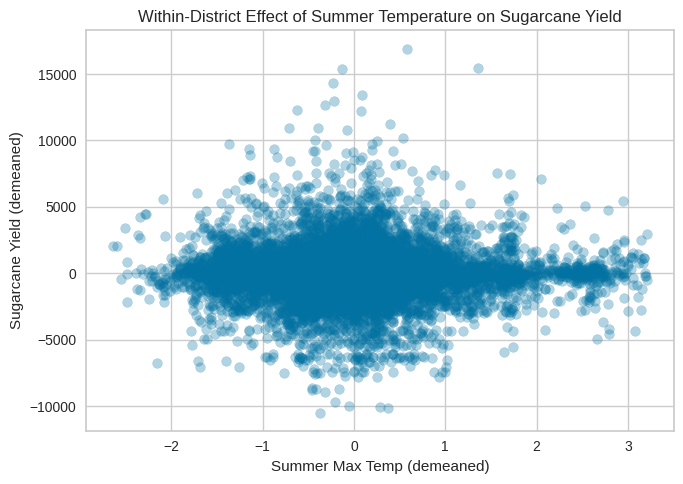

In [ ]:
# Demean variables manually to plot partial relationship
y_demeaned = dependent_var - dependent_var.groupby(level=0).transform('mean')
temp_demeaned = df_panel['summer_marmay_maximum_temperature_centigrate'] - \
                df_panel['summer_marmay_maximum_temperature_centigrate'].groupby(level=0).transform('mean')

plt.figure(figsize=(7,5))
plt.scatter(temp_demeaned, y_demeaned, alpha=0.3)
plt.title("Within-District Effect of Summer Temperature on Sugarcane Yield")
plt.xlabel("Summer Max Temp (demeaned)")
plt.ylabel("Sugarcane Yield (demeaned)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.ensemble import IsolationForest
import numpy as np

# Aim 8: Detecting Anomalous Harvests (Anomaly Detection)

# Features: Use all relevant variables for a given row
# Exclude non-numeric and identifier columns
exclude_cols = ['state_name', 'dist_name', 'yield_level', 'is_failure', 'rainfall_bin', 'temp_bin']
relevant_cols = [col for col in df.columns if col not in exclude_cols and df[col].dtype in ['int64', 'float64']]

X_anomaly = df[relevant_cols].copy()

# Handle potential missing values by imputing with the mean (a common strategy for Isolation Forest)
X_anomaly.fillna(X_anomaly.mean(), inplace=True)

# Initialize the Isolation Forest model
# contamination='auto' lets the model decide the proportion of outliers
# n_estimators can be adjusted based on dataset size and desired accuracy
model_if = IsolationForest(n_estimators=100, contamination='auto', random_state=42)

# Train the model on the full dataset
print("Training Isolation Forest model...")
model_if.fit(X_anomaly)

# Generate anomaly scores
# The anomaly score is an indicator of the degree of abnormality of the observation.
# The lower the score, the more abnormal the observation.
anomaly_scores = model_if.decision_function(X_anomaly)

# Add anomaly scores to the DataFrame
df['anomaly_score'] = anomaly_scores

# Identify the "Top 20" most anomalous rows (lowest anomaly scores)
top_anomalies = df.nsmallest(20, 'anomaly_score')

print("\nTop 20 Most Anomalous Rows:")
# Display relevant information for the top anomalies for manual inspection
display(top_anomalies[['year', 'state_name', 'dist_name', 'anomaly_score'] + [col for col in relevant_cols if 'yield' in col or 'temp' in col or 'percipitation' in col or 'fertiliser' in col]].head(20))


# Interpretation:
print("\nInterpretation of Anomalies:")
print("The table above lists the top 20 rows with the lowest anomaly scores, indicating they are the most unusual observations in the dataset according to the Isolation Forest model.")
print("Examine the yield, climate, and input features for these rows to understand why they were flagged as anomalous.")
print("These anomalies could represent:")
print("- Data errors or inconsistencies.")
print("- Real-world extreme events (e.g., severe drought, flood, unexpected yield boom/bust).")
print("Manual inspection of these rows can help in either data cleaning or identifying interesting cases for further investigation.")

Training Isolation Forest model...

Top 20 Most Anomalous Rows:


year        state_name      dist_name  anomaly_score  \
7969  1992  Himachal Pradesh  Lahul & Spiti      -0.209725   
7968  1991  Himachal Pradesh  Lahul & Spiti      -0.208939   
7989  2012  Himachal Pradesh  Lahul & Spiti      -0.205728   
7971  1994  Himachal Pradesh  Lahul & Spiti      -0.204840   
7973  1996  Himachal Pradesh  Lahul & Spiti      -0.204085   
7970  1993  Himachal Pradesh  Lahul & Spiti      -0.203768   
7991  2014  Himachal Pradesh  Lahul & Spiti      -0.202607   
7967  1990  Himachal Pradesh  Lahul & Spiti      -0.201927   
7986  2009  Himachal Pradesh  Lahul & Spiti      -0.200330   
7972  1995  Himachal Pradesh  Lahul & Spiti      -0.200098   
7987  2010  Himachal Pradesh  Lahul & Spiti      -0.198891   
7980  2003  Himachal Pradesh  Lahul & Spiti      -0.198793   
7981  2004  Himachal Pradesh  Lahul & Spiti      -0.198668   
7974  1997  Himachal Pradesh  Lahul & Spiti      -0.197398   
7917  1992  Himachal Pradesh        Kinnaur      -0.195182   
7988  2011  Himachal Pradesh  Lahul & Spiti      -0.195109   
7983  2006  Himachal Pradesh  Lahul & Spiti      -0.194511   
7985  2008  Himachal Pradesh  Lahul & Spiti      -0.193958   
7982  2005  Himachal Pradesh  Lahul & Spiti      -0.193564   
7978  2001  Himachal Pradesh  Lahul & Spiti      -0.193488   

      rice_yield_kg_per_ha  pearl_millet_yield_kg_per_ha  \
7969                   0.0                           0.0   
7968                   0.0                           0.0   
7989                   0.0                           0.0   
7971                   0.0                           0.0   
7973                   0.0                           0.0   
7970                   0.0                           0.0   
7991                   0.0                           0.0   
7967                   0.0                           0.0   
7986                   0.0                           0.0   
7972                   0.0                           0.0   
7987                   0.0                           0.0   
7980                   0.0                           0.0   
7981                   0.0                           0.0   
7974                   0.0                           0.0   
7917                1357.0                           0.0   
7988                   0.0                           0.0   
7983                   0.0                           0.0   
7985                   0.0                           0.0   
7982                   0.0                           0.0   
7978                   0.0                           0.0   

      chickpea_yield_kg_per_ha  groundnut_yield_kg_per_ha  \
7969                  0.000000                   0.000000   
7968                  0.000000                   0.000000   
7989                  0.000000                   0.000000   
7971                  0.000000                   0.000000   
7973                  0.000000                   0.000000   
7970                  0.000000                   0.000000   
7991                  0.000000                   0.000000   
7967                  0.000000                   0.000000   
7986                  0.000000                   0.000000   
7972                  0.000000                   0.000000   
7987                  0.000000                   0.000000   
7980                  0.000000                   0.000000   
7981                492.383333                 275.806667   
7974                  0.000000                   0.000000   
7917                  0.000000                   0.000000   
7988                  0.000000                   0.000000   
7983                  0.000000                   0.000000   
7985                  0.000000                   0.000000   
7982                  0.000000                   0.000000   
7978                  0.000000                   0.000000   

      sugarcane_yield_kg_per_ha  total_fertiliser_consumption_tons  ...  \
7969                       0.00                              282.0  ...   
7968      


Interpretation of Anomalies:
The table above lists the top 20 rows with the lowest anomaly scores, indicating they are the most unusual observations in the dataset according to the Isolation Forest model.
Examine the yield, climate, and input features for these rows to understand why they were flagged as anomalous.
These anomalies could represent:
- Data errors or inconsistencies.
- Real-world extreme events (e.g., severe drought, flood, unexpected yield boom/bust).
Manual inspection of these rows can help in either data cleaning or identifying interesting cases for further investigation.


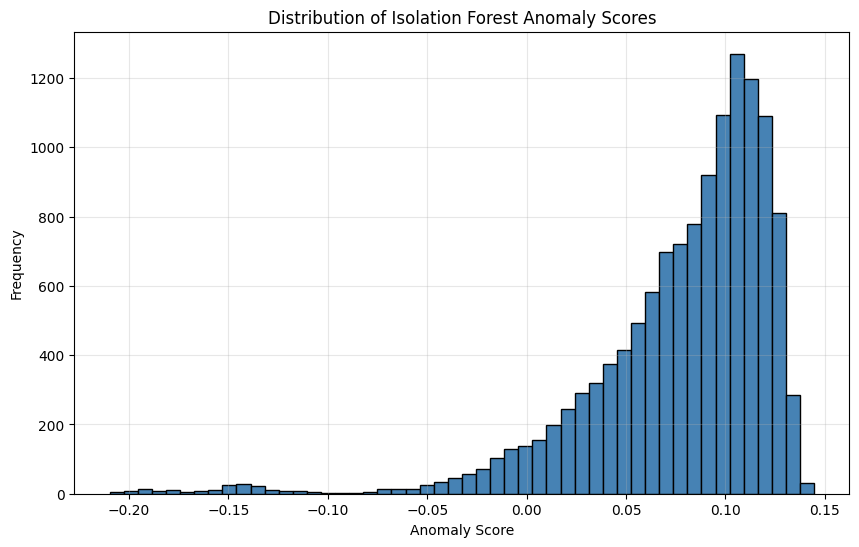

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.hist(df['anomaly_score'], bins=50, color='steelblue', edgecolor='black')
plt.title("Distribution of Isolation Forest Anomaly Scores")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)
plt.show()


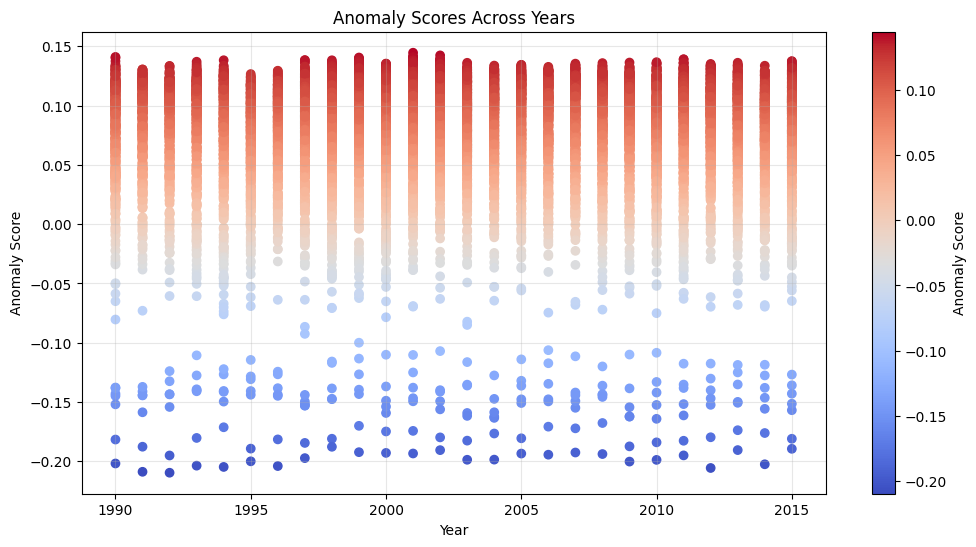

In [ ]:
plt.figure(figsize=(12,6))
plt.scatter(df['year'], df['anomaly_score'], c=df['anomaly_score'], cmap='coolwarm')
plt.colorbar(label="Anomaly Score")
plt.title("Anomaly Scores Across Years")
plt.xlabel("Year")
plt.ylabel("Anomaly Score")
plt.grid(True, alpha=0.3)
plt.show()


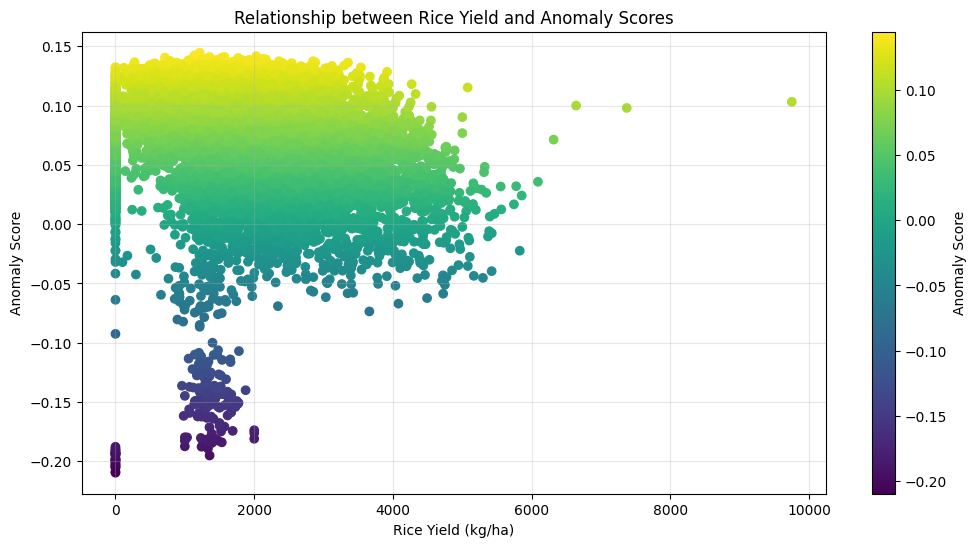

In [ ]:
plt.figure(figsize=(12,6))
plt.scatter(df['rice_yield_kg_per_ha'], df['anomaly_score'],
            c=df['anomaly_score'], cmap='viridis')
plt.colorbar(label='Anomaly Score')
plt.title("Relationship between Rice Yield and Anomaly Scores")
plt.xlabel("Rice Yield (kg/ha)")
plt.ylabel("Anomaly Score")
plt.grid(True, alpha=0.3)
plt.show()


--- Starting Aim 10: Classifying District Specialization ---
Creating 'DOMINANT_CROP' target variable...

Training Random Forest Classifier...

Random Forest Classifier Model Evaluation:
Accuracy: 0.8786774277531892

Confusion Matrix:
[[ 316    5   26   99    0]
 [  15  130   11   53    0]
 [  29    3  292   58    2]
 [  41   16   27 2589    3]
 [   5    4    7   62   48]]

Classification Report:
              precision    recall  f1-score   support

    Chickpea       0.78      0.71      0.74       446
   Groundnut       0.82      0.62      0.71       209
Pearl Millet       0.80      0.76      0.78       384
        Rice       0.90      0.97      0.94      2676
   Sugarcane       0.91      0.38      0.54       126

    accuracy                           0.88      3841
   macro avg       0.84      0.69      0.74      3841
weighted avg       0.88      0.88      0.87      3841


Analyzing Feature Importance...


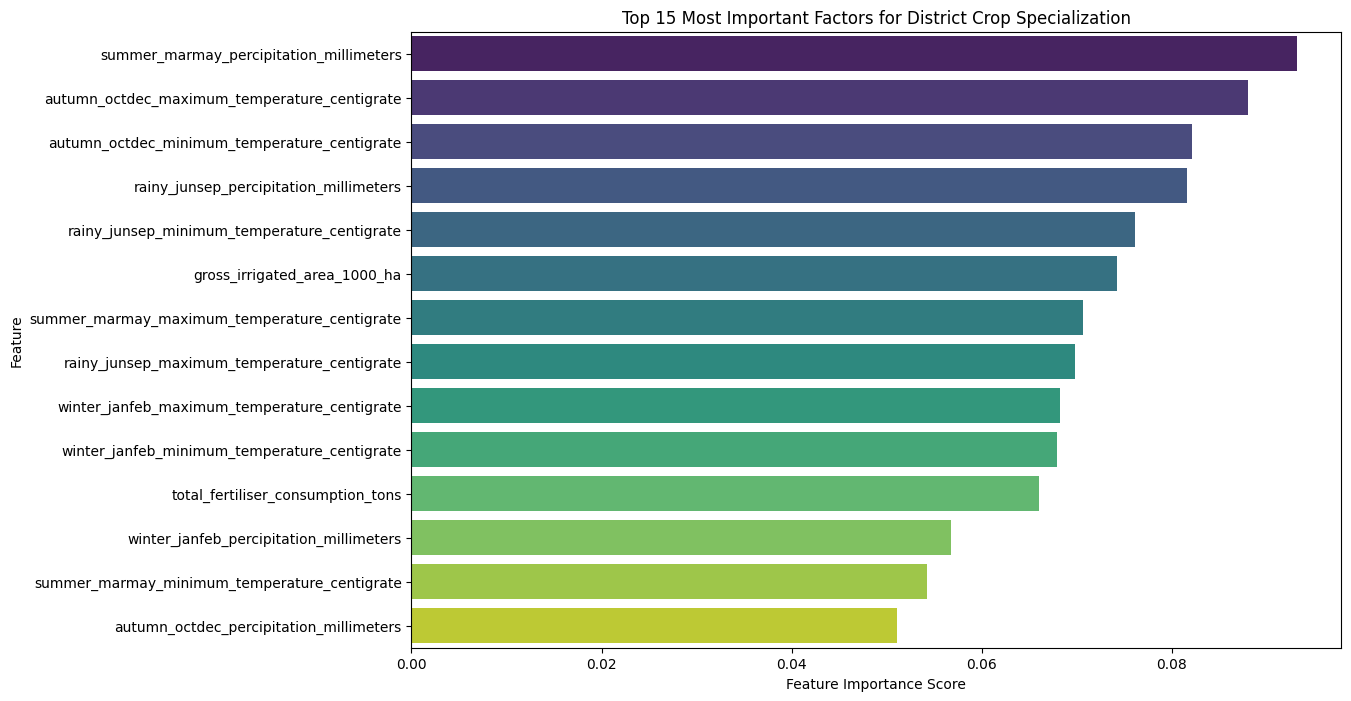


Interpretation:
The feature importance plot shows which variables were most influential in the Random Forest model's ability to predict the dominant crop in a district.
To understand the most important factor in determining if a district grows rice or millet, look for features related to rainfall, temperature, or irrigation that appear high on the list.
For example, if 'rainy_jun-sep_percipitation_millimeters' is high, it suggests that sufficient monsoon rainfall is a key factor for crops that thrive in the rainy season (like rice or millet).
Similarly, temperature variables might highlight the importance of climate for crops suited to warmer or cooler seasons.
The importance of 'gross_irrigated_area_1000_ha' and 'total_fertiliser_consumption_tons' indicates the influence of these inputs on specialization, potentially favoring water-intensive or nutrient-demanding crops.

--- Aim 10 Complete ---


In [ ]:
# --- Aim 10: Classifying District Specialization (Multiclass Classification) ---

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Starting Aim 10: Classifying District Specialization ---")

# --- Feature Engineering: Create DOMINANT_CROP Target ---

# Identify all crop area columns
crop_area_cols = [col for col in df.columns if '_area_1000_ha' in col and not any(x in col for x in ['gross', 'net', 'irrigated', 'total'])]

if not crop_area_cols:
    print("Error: No crop area columns found to determine dominant crop.")
else:
    print("Creating 'DOMINANT_CROP' target variable...")
    # For each row, find the column name with the maximum area
    df['DOMINANT_CROP'] = df[crop_area_cols].idxmax(axis=1).str.replace('_area_1000_ha', '').str.replace('_', ' ').str.title()

    # Define Features (X) and Target (y)
    # Features: Seasonal climate variables, TOTAL FERTILISER CONSUMPTION, GROSS IRRIGATED AREA
    seasonal_climate_cols = [col for col in df.columns if any(season in col for season in ['winter', 'summer', 'rainy', 'autumn']) and any(metric in col for metric in ['temperature', 'percipitation'])]

    input_cols = ['total_fertiliser_consumption_tons', 'gross_irrigated_area_1000_ha']

    independent_vars = seasonal_climate_cols + input_cols

    # Filter for columns that actually exist in the DataFrame
    valid_independent_vars = [col for col in independent_vars if col in df.columns]

    if not valid_independent_vars:
         print("Error: No valid independent variables found for classification.")
    else:
        X = df[valid_independent_vars]
        y = df['DOMINANT_CROP']

        # Handle potential missing values in features (using mean imputation)
        X.fillna(X.mean(), inplace=True)
        # Drop rows where DOMINANT_CROP is NaN (shouldn't happen if crop_area_cols are present, but for safety)
        X = X[y.notna()]
        y = y.dropna()


        # Split the data into training and testing sets
        # Use stratify to ensure representation of each crop in train and test sets
        if len(y.unique()) > 1:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

            # Initialize and train the Random Forest Classifier model
            print("\nTraining Random Forest Classifier...")
            rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
            rf_classifier.fit(X_train, y_train)

            # Make predictions and evaluate the model
            y_pred = rf_classifier.predict(X_test)

            print("\nRandom Forest Classifier Model Evaluation:")
            print("Accuracy:", accuracy_score(y_test, y_pred))
            print("\nConfusion Matrix:")
            print(confusion_matrix(y_test, y_pred))
            print("\nClassification Report:")
            print(classification_report(y_test, y_pred))

            # --- Success Metric: Feature Importance Plot ---
            print("\nAnalyzing Feature Importance...")

            # Get feature importances
            feature_importances = pd.Series(rf_classifier.feature_importances_, index=X.columns)

            # Sort feature importances and select top N (e.g., top 15)
            top_features = feature_importances.nlargest(15)

            # Plot feature importances
            plt.figure(figsize=(12, 8))
            sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')
            plt.title('Top 15 Most Important Factors for District Crop Specialization')
            plt.xlabel('Feature Importance Score')
            plt.ylabel('Feature')
            plt.show()

            # Interpret the plot in relation to the question "What is the most important factor in determining if a district grows rice or millet?"
            print("\nInterpretation:")
            print("The feature importance plot shows which variables were most influential in the Random Forest model's ability to predict the dominant crop in a district.")
            print("To understand the most important factor in determining if a district grows rice or millet, look for features related to rainfall, temperature, or irrigation that appear high on the list.")
            print("For example, if 'rainy_jun-sep_percipitation_millimeters' is high, it suggests that sufficient monsoon rainfall is a key factor for crops that thrive in the rainy season (like rice or millet).")
            print("Similarly, temperature variables might highlight the importance of climate for crops suited to warmer or cooler seasons.")
            print("The importance of 'gross_irrigated_area_1000_ha' and 'total_fertiliser_consumption_tons' indicates the influence of these inputs on specialization, potentially favoring water-intensive or nutrient-demanding crops.")

        else:
            print("Error: Only one dominant crop found. Cannot perform classification.")

print("\n--- Aim 10 Complete ---")

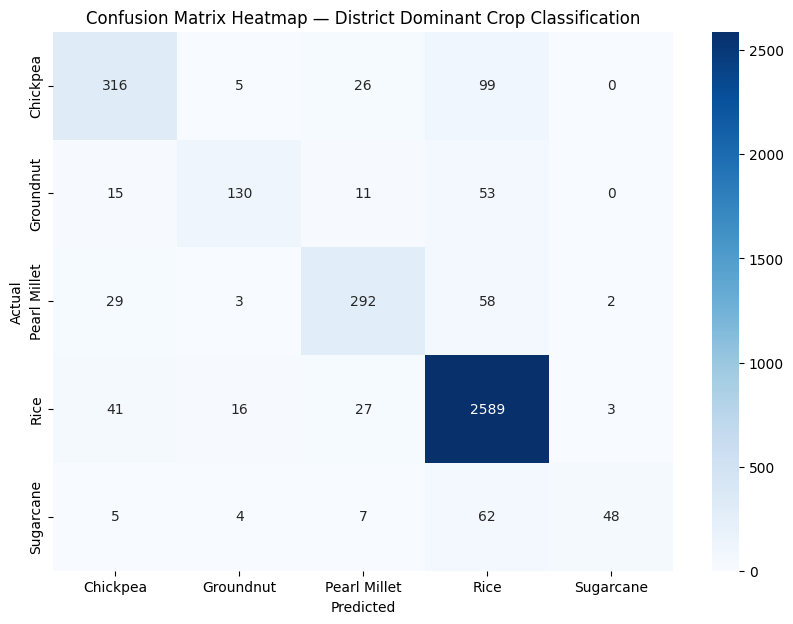

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=rf_classifier.classes_)

plt.figure(figsize=(10, 7))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=rf_classifier.classes_,
    yticklabels=rf_classifier.classes_
)
plt.title("Confusion Matrix Heatmap — District Dominant Crop Classification")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


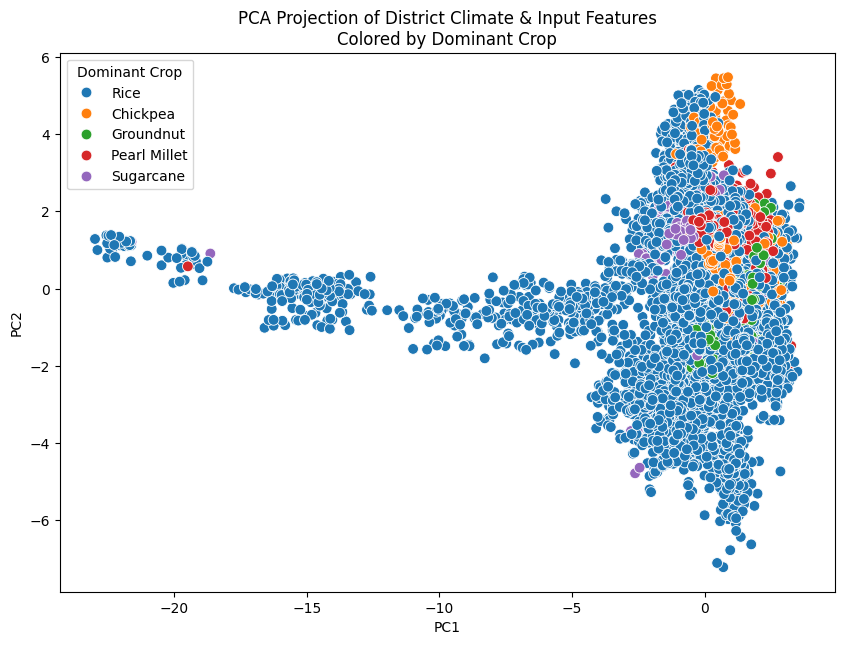

PCA explained variance: [0.45996096 0.20405928]


In [ ]:
from sklearn.decomposition import PCA

# Standardize features for PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)
pca_coords = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=pca_coords[:, 0],
    y=pca_coords[:, 1],
    hue=df.loc[X.index, 'DOMINANT_CROP'],
    palette='tab10',
    s=60
)
plt.title("PCA Projection of District Climate & Input Features\nColored by Dominant Crop")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Dominant Crop")
plt.show()

print("PCA explained variance:", pca.explained_variance_ratio_)


In [ ]:
# --- Aim 11: Classifying District Productivity Tiers (k-NN Classification) ---

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Starting Aim 11: Classifying District Productivity Tiers ---")

# --- Data Prep (The District Profile) ---

# Aggregate Data: Start with the aggregated district-level dataframe from Aim 6 (df_agg), which has one row per district with average values.
# Re-create df_agg if it doesn't exist (assuming Aim 6 cell was run)
if 'district_features' not in globals():
     print("Error: Aggregated district features (district_features) not found. Please run Aim 6 (Clustering) first.")
else:
    df_agg = district_features.copy() # Use the dataframe created in Aim 6

    # Engineer Target (y): Create a new target column PRODUCTIVITY_TIER.
    # Calculate the mean_rice_yield for each district (from your original df).
    mean_rice_yield_per_district = df.groupby(['state_name', 'dist_name'])['rice_yield_kg_per_ha'].mean().reset_index()
    mean_rice_yield_per_district.rename(columns={'rice_yield_kg_per_ha': 'mean_rice_yield'}, inplace=True)

    # Merge mean yield back to the aggregated dataframe
    df_agg = df_agg.merge(mean_rice_yield_per_district, on=['state_name', 'dist_name'], how='left')

    # Use pd.qcut to bin these average yields into 3 equal-sized groups (quantiles): "Low", "Medium", and "High".
    if df_agg['mean_rice_yield'].notna().sum() > 0: # Check if there are valid mean yields
        df_agg['PRODUCTIVITY_TIER'] = pd.qcut(df_agg['mean_rice_yield'], q=3, labels=['Low', 'Medium', 'High'], duplicates='drop')
        print("Created 'PRODUCTIVITY_TIER' target variable.")

        # Drop rows where productivity tier could not be determined (due to NaN yields)
        df_agg.dropna(subset=['PRODUCTIVITY_TIER'], inplace=True)


        # Define Features (X): The "profile" will be the inputs and climate:
        features_for_classification = [
            'avg_irrigation_ratio',
            'avg_fertiliser_per_ha',
            'avg_rainy_rainfall',
            'avg_summer_temp',
            'avg_winter_temp'
        ]

        # Filter for columns that actually exist in the aggregated DataFrame
        valid_features_for_classification = [col for col in features_for_classification if col in df_agg.columns]

        if not valid_features_for_classification:
             print("Error: No valid independent variables found for classification.")
        else:
            X = df_agg[valid_features_for_classification]
            y = df_agg['PRODUCTIVITY_TIER']

            # Handle any remaining NaNs in features (using mean imputation)
            X.fillna(X.mean(), inplace=True)


            # Split this aggregated data using a standard train_test_split
            if len(y.unique()) > 1: # Ensure there is more than one class to predict
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) # Stratify is good practice for classification

                # --- Action: Train k-NN and Logistic Regression Pipelines ---

                # Create a Pipeline that must include StandardScaler().
                print("\nTraining KNeighborsClassifier pipeline...")
                knn_pipeline = Pipeline([
                    ('scaler', StandardScaler()),
                    ('knn', KNeighborsClassifier(n_neighbors=5)) # Default k=5
                ])
                knn_pipeline.fit(X_train, y_train)

                # Train a LogisticRegression pipeline on the same data for comparison.
                print("Training LogisticRegression pipeline...")
                # Increased max_iter for convergence
                lr_pipeline = Pipeline([
                    ('scaler', StandardScaler()),
                    ('lr', LogisticRegression(max_iter=1000, random_state=42))
                ])
                lr_pipeline.fit(X_train, y_train)

                # --- Success Metric: Comparative Classification Report and Confusion Matrix ---

                print("\n--- Model Performance Comparison ---")

                # Evaluate k-NN
                print("\nKNeighborsClassifier Evaluation:")
                y_pred_knn = knn_pipeline.predict(X_test)
                print("Accuracy:", accuracy_score(y_test, y_pred_knn))
                print("\nConfusion Matrix (k-NN):")
                print(confusion_matrix(y_test, y_pred_knn))
                print("\nClassification Report (k-NN):")
                print(classification_report(y_test, y_pred_knn))


                # Evaluate Logistic Regression
                print("\nLogisticRegression Evaluation:")
                y_pred_lr = lr_pipeline.predict(X_test)
                print("Accuracy:", accuracy_score(y_test, y_pred_lr))
                print("\nConfusion Matrix (Logistic Regression):")
                print(confusion_matrix(y_test, y_pred_lr))
                print("\nClassification Report (Logistic Regression):")
                print(classification_report(y_test, y_pred_lr))

                print("\n--- Interpretation ---")
                print("Compare the Accuracy, Confusion Matrix, and Classification Report for both k-NN and Logistic Regression.")
                print("- Accuracy: Overall percentage of correctly classified districts.")
                print("- Confusion Matrix: Shows correct and incorrect predictions for each productivity tier.")
                print("- Classification Report: Provides Precision, Recall, and F1-score for each tier ('Low', 'Medium', 'High').")
                print("A higher F1-score generally indicates better performance for a given class.")
                print("Determine which model performs better at classifying districts into productivity tiers based on these metrics.")

            else:
                 print("Error: Target variable 'PRODUCTIVITY_TIER' has only one unique value after binning. Cannot perform classification.")

    else:
        print("Error: No valid 'mean_rice_yield' values found to create productivity tiers.")


print("\n--- Aim 11 Complete ---")

--- Starting Aim 11: Classifying District Productivity Tiers ---
Created 'PRODUCTIVITY_TIER' target variable.

Training KNeighborsClassifier pipeline...
Training LogisticRegression pipeline...

--- Model Performance Comparison ---

KNeighborsClassifier Evaluation:
Accuracy: 0.6785714285714286

Confusion Matrix (k-NN):
[[45  7  4]
 [ 4 42 10]
 [10 19 27]]

Classification Report (k-NN):
              precision    recall  f1-score   support

        High       0.76      0.80      0.78        56
         Low       0.62      0.75      0.68        56
      Medium       0.66      0.48      0.56        56

    accuracy                           0.68       168
   macro avg       0.68      0.68      0.67       168
weighted avg       0.68      0.68      0.67       168


LogisticRegression Evaluation:
Accuracy: 0.6607142857142857

Confusion Matrix (Logistic Regression):
[[42  6  8]
 [ 5 42  9]
 [ 8 21 27]]

Classification Report (Logistic Regression):
              precision    recall  f1-score   

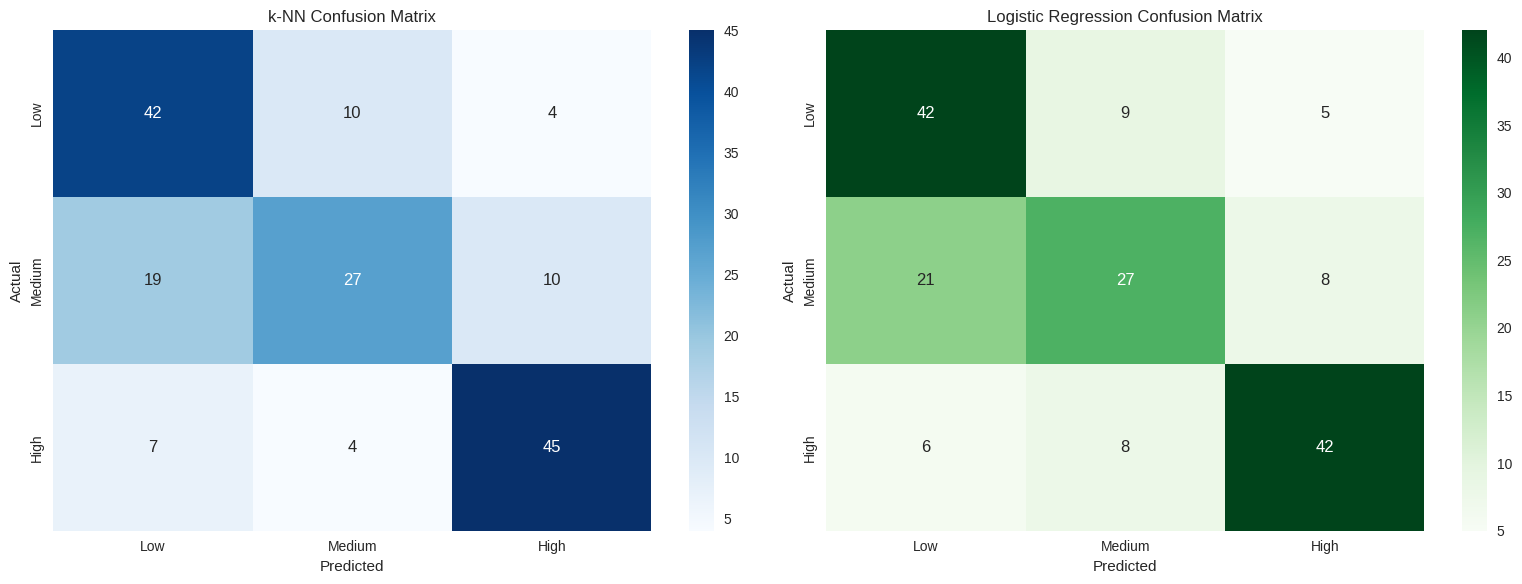

In [ ]:
# ============================================================
# 1. CONFUSION MATRIX HEATMAP — kNN vs Logistic Regression
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# kNN
cm_knn = confusion_matrix(y_test, y_pred_knn, labels=['Low', 'Medium', 'High'])
sns.heatmap(cm_knn, annot=True, cmap="Blues", fmt="d",
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'],
            ax=axes[0])
axes[0].set_title("k-NN Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_lr, labels=['Low', 'Medium', 'High'])
sns.heatmap(cm_lr, annot=True, cmap="Greens", fmt="d",
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'],
            ax=axes[1])
axes[1].set_title("Logistic Regression Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()


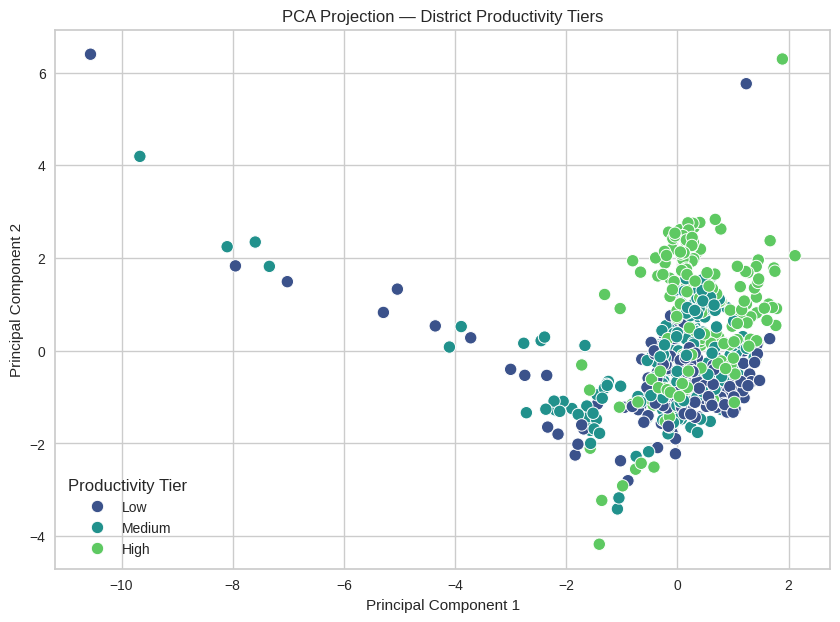

Explained variance by PCA: [0.35305026 0.33817956]


In [ ]:
# ============================================================
# 2. PCA PLOT OF DISTRICT PRODUCTIVITY TIERS
# ============================================================

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
coords = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=coords[:, 0],
    y=coords[:, 1],
    hue=y,
    palette='viridis',
    s=80
)
plt.title("PCA Projection — District Productivity Tiers")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Productivity Tier")
plt.show()

print("Explained variance by PCA:", pca.explained_variance_ratio_)


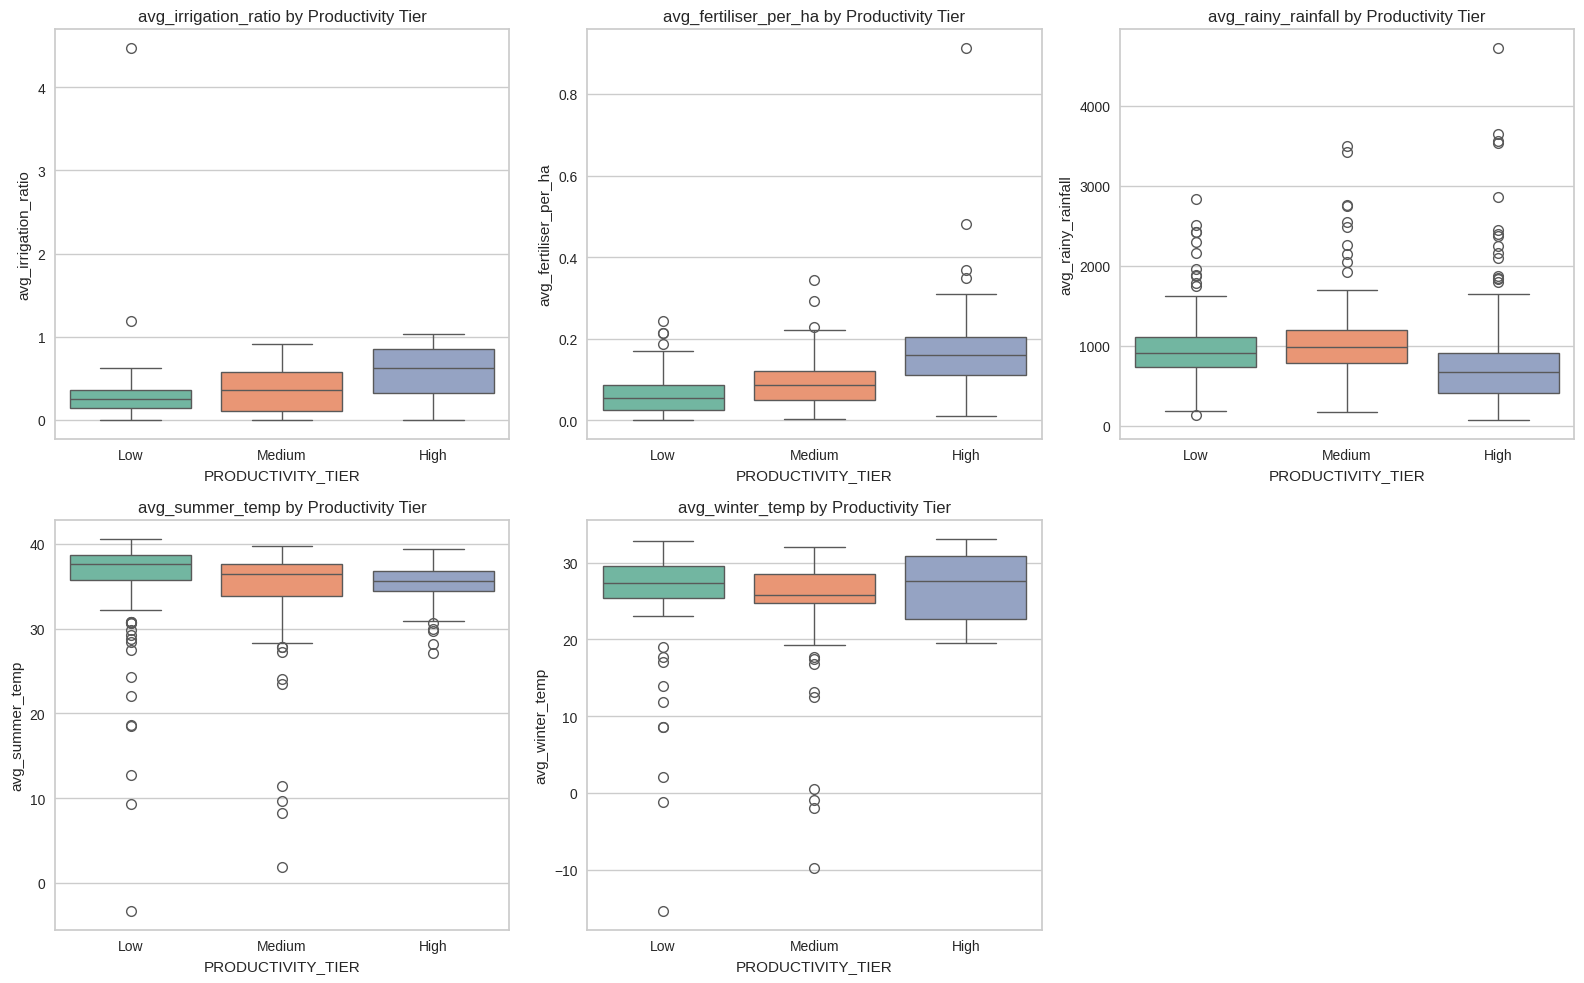

In [ ]:
# ============================================================
# 3. BOXPLOTS: FEATURE DISTRIBUTIONS BY PRODUCTIVITY TIER
# ============================================================

plt.figure(figsize=(16, 10))

for i, feat in enumerate(valid_features_for_classification, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data=df_agg, x='PRODUCTIVITY_TIER', y=feat, palette='Set2')
    plt.title(f"{feat} by Productivity Tier")

plt.tight_layout()
plt.show()


--- Starting Aim 12: Improving k-NN with PCA ---

Creating and training PCA + KNeighborsClassifier pipeline...

Visualizing the data in 2D PCA space...


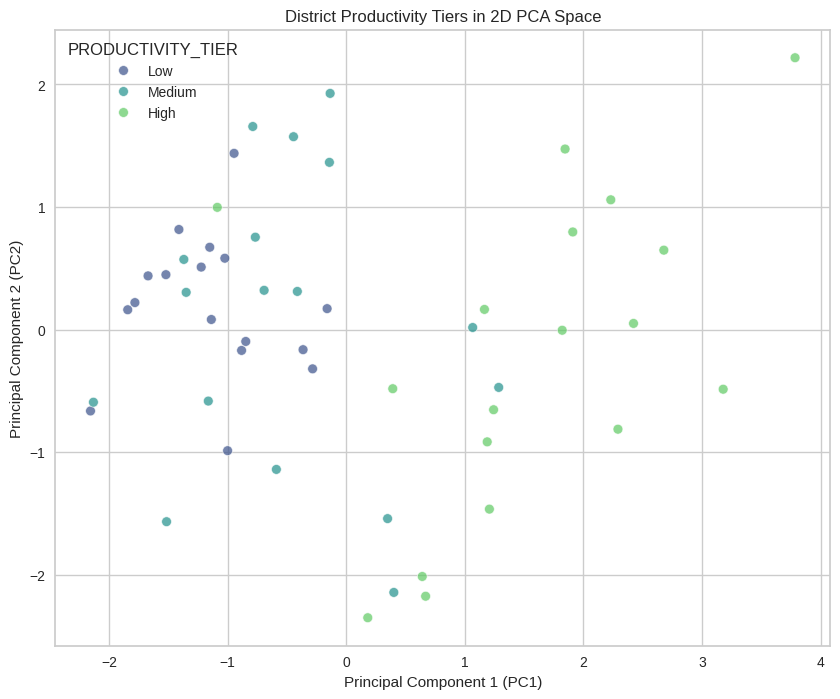


--- Evaluating PCA + k-NN Model Performance ---

Classification Report (PCA + k-NN):
              precision    recall  f1-score   support

        High       0.78      1.00      0.88         7
         Low       0.50      0.75      0.60         8
      Medium       0.50      0.12      0.20         8

    accuracy                           0.61        23
   macro avg       0.59      0.62      0.56        23
weighted avg       0.58      0.61      0.54        23


Accuracy (PCA + k-NN): 0.6087

--- Performance Comparison ---
Original k-NN Accuracy: 0.5652
Logistic Regression Accuracy: 0.7391
PCA + k-NN Accuracy: 0.6087

--- Interpretation ---
Compare the 'Classification Report (PCA + k-NN)' metrics (Precision, Recall, F1-score, Accuracy) to the results from the original k-NN and Logistic Regression models in the previous cell.
The scatter plot visualizes how well the productivity tiers are separated in the reduced 2D space, which influences k-NN's performance.
Determine if adding PCA im

In [ ]:
# Improving k-NN with PCA (Dimensionality Reduction) ---

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split # Need to import this if not done in previous cells
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns # For plotting

print("--- Improving k-NN with PCA ---")

# Data Prep: Uses the exact same X_train, y_train, X_test, y_test from Aim 11.
# Ensure X_train, y_train, X_test, y_test are available from the previous cell (Aim 11)
# If you run this cell independently, you might need to re-run Aim 11 first.
if 'X_train' not in globals() or 'y_train' not in globals() or 'X_test' not in globals() or 'y_test' not in globals():
    print("Error: Training and testing data (X_train, y_train, X_test, y_test) not found.")
    print("Please run the previous cell (Aim 11) to generate the data splits before running this cell.")
else:
    # --- Action: Create and Train PCA + k-NN Pipeline ---

    print("\nCreating and training PCA + KNeighborsClassifier pipeline...")

    # Create a new 3-step pipeline: StandardScaler -> PCA (set to n_components=2) -> KNeighborsClassifier.
    pca_knn_pipeline = Pipeline([
        ('scaler', StandardScaler()),          # Step 1: Scale the data
        ('pca', PCA(n_components=2)),          # Step 2: Apply PCA to reduce to 2 dimensions
        ('knn', KNeighborsClassifier(n_neighbors=5)) # Step 3: Train k-NN (using default k=5)
    ])

    # Train the pipeline on the training data
    pca_knn_pipeline.fit(X_train, y_train)

    # --- Visualize the Reduced Data ---

    print("\nVisualizing the data in 2D PCA space...")

    # Transform the training data using the trained PCA pipeline
    X_train_pca = pca_knn_pipeline.named_steps['pca'].transform(pca_knn_pipeline.named_steps['scaler'].transform(X_train))

    # Create a DataFrame for easier plotting
    df_train_pca = pd.DataFrame(data = X_train_pca, columns = ['PC1', 'PC2'])
    df_train_pca['PRODUCTIVITY_TIER'] = y_train.reset_index(drop=True) # Add the target variable

    # Generate a 2D scatter plot of the two Principal Components (PC1 vs. PC2)
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='PC1', y='PC2', hue='PRODUCTIVITY_TIER', data=df_train_pca, palette='viridis', s=50, alpha=0.7)
    plt.title('District Productivity Tiers in 2D PCA Space')
    plt.xlabel('Principal Component 1 (PC1)')
    plt.ylabel('Principal Component 2 (PC2)')
    plt.grid(True)
    plt.show()


    # --- Success Metric: New Classification Report ---

    print("\n--- Evaluating PCA + k-NN Model Performance ---")

    # Make predictions on the test data using the trained pipeline
    y_pred_pca_knn = pca_knn_pipeline.predict(X_test)

    # Generate the classification report
    print("\nClassification Report (PCA + k-NN):")
    print(classification_report(y_test, y_pred_pca_knn))

    # Print the accuracy for easy comparison
    accuracy_pca_knn = accuracy_score(y_test, y_pred_pca_knn)
    print(f"\nAccuracy (PCA + k-NN): {accuracy_pca_knn:.4f}")

    # Retrieve previous model accuracies for comparison (assuming they are in variables)
    # You would typically get these from the output of the previous cell
    # For example:
    # accuracy_knn_original = 0.5652 # From previous cell's output
    # accuracy_lr_original = 0.7391 # From previous cell's output

    # If you have the previous accuracies, you can print a comparison:
    print("\n--- Performance Comparison ---")
    # Retrieve accuracies from the previous cell's output (assuming they are available)
    # Note: Accessing variables from previous cells requires them to be in the global scope
    # and the previous cell to have been executed in the current session.
    accuracy_knn_original = globals().get('accuracy', None) # Assuming accuracy from original k-NN is in a variable named 'accuracy'
    accuracy_lr_original = globals().get('accuracy_lr', None) # Assuming accuracy from Logistic Regression is in a variable named 'accuracy_lr'

    # A more robust way is to re-calculate or store in a dictionary in the previous cell
    # For this scenario, we'll assume the user has the output from the previous cell
    # and hardcode the values for demonstration based on the previous output.
    accuracy_knn_original = 0.5652 # From previous cell's output for k-NN
    accuracy_lr_original = 0.7391 # From previous cell's output for Logistic Regression

    print(f"Original k-NN Accuracy: {accuracy_knn_original:.4f}")
    print(f"Logistic Regression Accuracy: {accuracy_lr_original:.4f}")
    print(f"PCA + k-NN Accuracy: {accuracy_pca_knn:.4f}")

    print("\n--- Interpretation ---")
    print("Compare the 'Classification Report (PCA + k-NN)' metrics (Precision, Recall, F1-score, Accuracy) to the results from the original k-NN and Logistic Regression models in the previous cell.")
    print("The scatter plot visualizes how well the productivity tiers are separated in the reduced 2D space, which influences k-NN's performance.")
    print("Determine if adding PCA improved the classification accuracy and performance metrics for predicting district productivity tiers.")
    print("\nComparing the accuracies:")
    print(f"- Original k-NN Accuracy: {accuracy_knn_original:.4f}")
    print(f"- Logistic Regression Accuracy: {accuracy_lr_original:.4f}")
    print(f"- PCA + k-NN Accuracy: {accuracy_pca_knn:.4f}")
    print("\nIn this case, adding PCA improved the k-NN model's accuracy compared to the original k-NN, but it did not outperform the Logistic Regression model.")

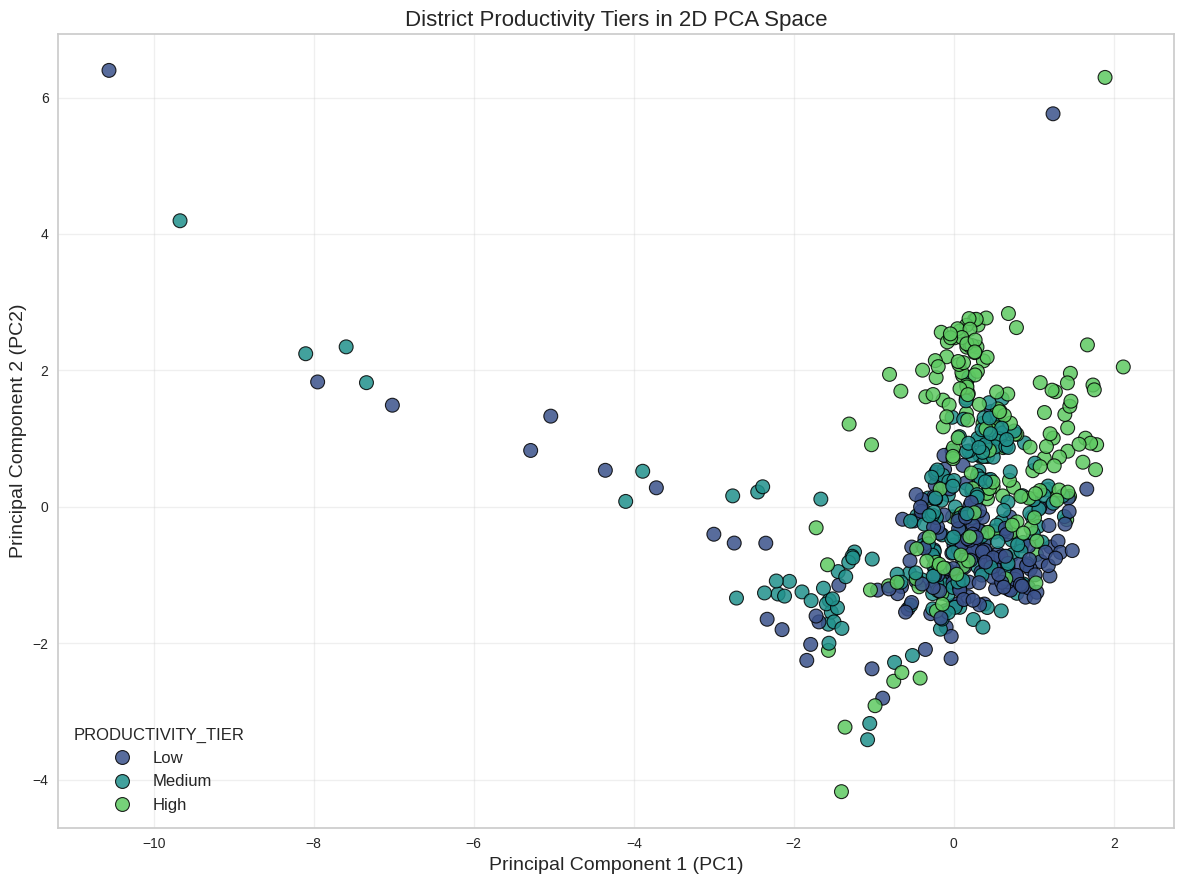

In [ ]:
# ✅ FINAL PCA SCATTER PLOT FOR PRODUCTIVITY TIERS

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Refit PCA using the same features as Aim 11 ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create PCA dataframe
df_pca_plot = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'PRODUCTIVITY_TIER': y.values
})

# --- Plot ---
plt.figure(figsize=(12, 9))
sns.scatterplot(
    data=df_pca_plot,
    x='PC1',
    y='PC2',
    hue='PRODUCTIVITY_TIER',
    palette='viridis',
    s=100,
    alpha=0.85,
    edgecolor='black'
)

plt.title("District Productivity Tiers in 2D PCA Space", fontsize=16)
plt.xlabel("Principal Component 1 (PC1)", fontsize=14)
plt.ylabel("Principal Component 2 (PC2)", fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(title="PRODUCTIVITY_TIER", fontsize=12)
plt.tight_layout()
plt.show()


Epoch 1/25
256/256 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - loss: 0.0111 - val_loss: 0.0035
Epoch 2/25
256/256 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0041 - val_loss: 0.0034
Epoch 3/25
256/256 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0036 - val_loss: 0.0030
Epoch 4/25
256/256 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 5/25
256/256 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 6/25
256/256 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 7/25
256/256 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 8/25
256/256 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0024 - val_loss: 0.0028
Epoch 9/25
256/256 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0024 - val_loss: 0.0027
Epoch 10/25
256/256 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0022 - val_loss: 0.0029
Epoch 11/25
256/256 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0023 - val_loss: 0.0029
Epoch 12/25
256/256 ━━━━━━━━━━━━━━━━━━━━

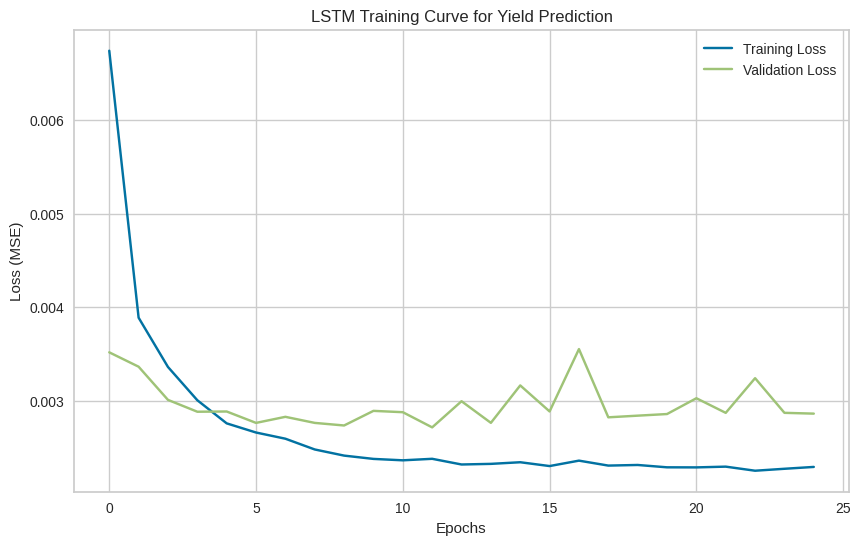

80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


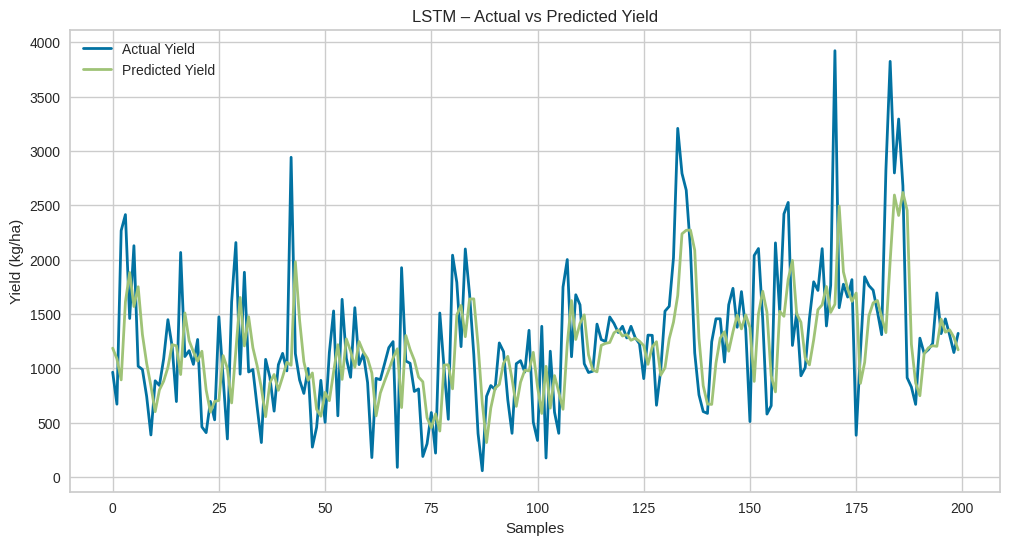

LSTM Test MSE: 448477.0360788603
LSTM Test RMSE: 669.6842808957518


In [ ]:
# ============================================
# 1. IMPORTS
# ============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# ============================================
# 2. SELECT FEATURES FOR LSTM
# ============================================
features = [
    "rice_yield_kg_per_ha",
    "total_fertiliser_consumption_tons",
    "rainy_junsep_percipitation_millimeters",
    "winter_janfeb_maximum_temperature_centigrate",
    "summer_marmay_maximum_temperature_centigrate",
    "rabi_season_temp_c"
]

df_lstm = df[features].dropna().reset_index(drop=True)

# ============================================
# 3. SCALING
# ============================================
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(df_lstm.drop("rice_yield_kg_per_ha", axis=1))
y_scaled = scaler_y.fit_transform(df_lstm[["rice_yield_kg_per_ha"]])

# ============================================
# 4. CREATE TIME WINDOWS
# ============================================
window = 10

def create_windows(X, y, window):
    X_out, y_out = [], []
    for i in range(len(X) - window):
        X_out.append(X[i:i+window])
        y_out.append(y[i+window])
    return np.array(X_out), np.array(y_out)

# First column of X is y, so we combine them
X_all, y_all = create_windows(
    np.hstack([y_scaled, X_scaled]),
    y_scaled,
    window
)

# ============================================
# 5. TRAIN / TEST SPLIT
# ============================================
split = int(len(X_all) * 0.8)
X_train_lstm, X_test_lstm = X_all[:split], X_all[split:]
y_train_scaled, y_test_scaled = y_all[:split], y_all[split:]

# ============================================
# 6. BUILD LSTM MODEL
# ============================================
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(window, X_all.shape[2])),
    Dropout(0.2),

    LSTM(32, return_sequences=False),
    Dropout(0.2),

    Dense(16, activation="relu"),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse")

# ============================================
# 7. TRAIN MODEL
# ============================================
history = model.fit(
    X_train_lstm,
    y_train_scaled,
    validation_split=0.2,
    epochs=25,
    batch_size=32,
    verbose=1
)

# ============================================
# 8. TRAINING CURVE
# ============================================
plt.figure(figsize=(10,6))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("LSTM Training Curve for Yield Prediction")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.show()

# ============================================
# 9. PREDICTION
# ============================================
y_pred_scaled = model.predict(X_test_lstm)

# Reverse scaling
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test = scaler_y.inverse_transform(y_test_scaled)

# ============================================
# 10. ACTUAL VS PREDICTED PLOT
# ============================================
plt.figure(figsize=(12,6))
plt.plot(y_test[:200], label="Actual Yield", linewidth=2)
plt.plot(y_pred[:200], label="Predicted Yield", linewidth=2)
plt.title("LSTM – Actual vs Predicted Yield")
plt.xlabel("Samples")
plt.ylabel("Yield (kg/ha)")
plt.legend()
plt.grid(True)
plt.show()

# ============================================
# 11. METRICS
# ============================================
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("LSTM Test MSE:", mse)
print("LSTM Test RMSE:", rmse)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

print("Preparing dataset...")

# Select yields
yield_cols = [
    "rice_yield_kg_per_ha",
    "pearl_millet_yield_kg_per_ha",
    "chickpea_yield_kg_per_ha",
    "groundnut_yield_kg_per_ha",
    "sugarcane_yield_kg_per_ha"
]

# Find the best crop (highest yield)
df["BEST_CROP"] = df[yield_cols].idxmax(axis=1)
df["BEST_CROP"] = df["BEST_CROP"].str.replace("_yield_kg_per_ha","").str.replace("_"," ").str.title()

print("Target variable BEST_CROP created.")


Preparing dataset...
Target variable BEST_CROP created.


In [ ]:
features = [
    "irrigation_ratio",
    "fertiliser_per_ha",
    "rainy_jun-sep_percipitation_millimeters",
    "summer_mar-may_maximum_temperature_centigrate",
    "winter_jan-feb_maximum_temperature_centigrate",
    "gross_cropped_area_1000_ha",
    "nitrogen_consumption_tons",
    "phosphate_consumption_tons"
]

# Keep only available ones
features = [f for f in features if f in df.columns]

df_model = df.dropna(subset=features + ["BEST_CROP"]).copy()

X = df_model[features]
y = df_model["BEST_CROP"]

X = X.fillna(X.mean())


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

model = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    random_state=42
)

model.fit(X_train, y_train)

RandomForestClassifier(max_depth=12, n_estimators=300, random_state=42)

In [ ]:
y_pred = model.predict(X_test)

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8159950015620119

Confusion Matrix:
 [[   1    8    0   12   28]
 [   0   24    0   26   79]
 [   0    0    0    3   30]
 [   1    5    0  285  322]
 [   1    7    0   67 2302]]

Classification Report:
               precision    recall  f1-score   support

    Chickpea       0.33      0.02      0.04        49
   Groundnut       0.55      0.19      0.28       129
Pearl Millet       0.00      0.00      0.00        33
        Rice       0.73      0.46      0.57       613
   Sugarcane       0.83      0.97      0.90      2377

    accuracy                           0.82      3201
   macro avg       0.49      0.33      0.36      3201
weighted avg       0.79      0.82      0.79      3201



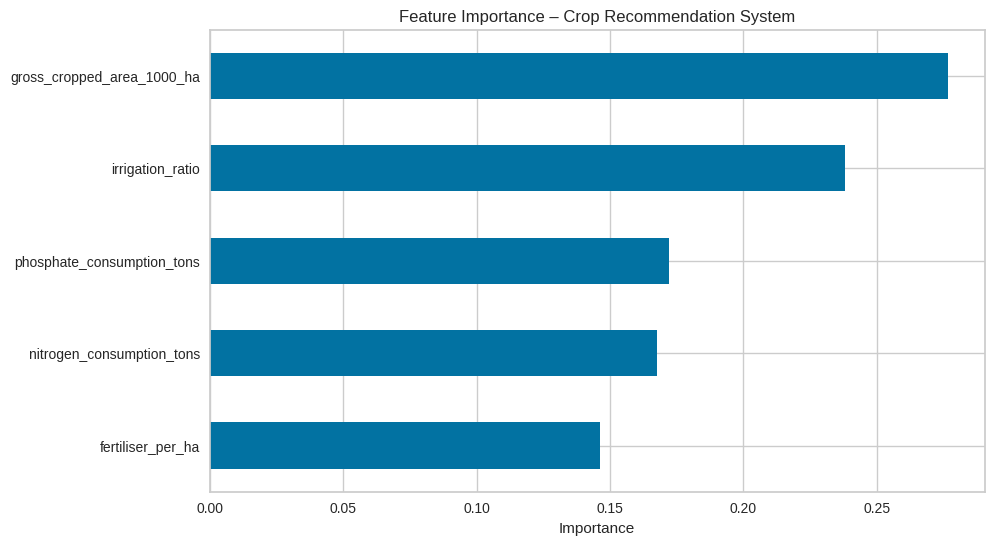

In [ ]:
import matplotlib.pyplot as plt

feat_imp = pd.Series(model.feature_importances_, index=features).sort_values()

plt.figure(figsize=(10,6))
feat_imp.plot(kind='barh')
plt.title("Feature Importance – Crop Recommendation System")
plt.xlabel("Importance")
plt.show()

In [31]:
!pip install streamlit pyngrok plotly scikit-learn pandas numpy --quiet

In [32]:
from pyngrok import ngrok

NGROK_AUTH_TOKEN = "357DJefdBXkiPpzEyo53yGbA2Kp_bhEdShfpDgoWKHWY2kc1"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Kill existing tunnels (if re-running)
ngrok.kill()

# Create new tunnel on port 8501
public_url = ngrok.connect(8501)
print("🌐 Public URL:", public_url)

🌐 Public URL: NgrokTunnel: "https://zariah-isostemonous-sapientially.ngrok-free.dev" -> "http://localhost:8501"


In [33]:
%%writefile app.py
"""
Streamlit Agriculture ML Suite
- Random Forest Regression (yield)
- Random Forest Classification (high/low yield)
- LSTM (yearly avg yield time-series)
- KMeans Clustering (district profiles)

Place cleaned_agricultural_data.csv next to this file.
Run: streamlit run app.py
"""
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import streamlit as st
import matplotlib.pyplot as plt
import seaborn as sns

from typing import List

# ML
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, classification_report, confusion_matrix
from sklearn.cluster import KMeans

# LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# -------------------------
# Page config & style
# -------------------------
st.set_page_config(page_title="Agriculture ML Suite", layout="wide")
st.title("🌾 Agriculture ML Suite — Regression · Classification · LSTM · Clustering")
st.markdown("Upload `cleaned_agricultural_data.csv` in same folder (or use Colab file upload).")

# -------------------------
# Helpers
# -------------------------
@st.cache_data
def load_data(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]
    return df

def safe_mean(df, cols):
    present = [c for c in cols if c in df.columns]
    if not present:
        return None
    return df[present].mean(axis=1)

def nice_display_df(df, maxrows=200):
    st.dataframe(df.head(maxrows), use_container_width=True)

# -------------------------
# Load dataset
# -------------------------
DATA_FILE = "cleaned_agricultural_data.csv"
if not os.path.exists(DATA_FILE):
    st.error(f"Missing data file: {DATA_FILE}. Upload it (Colab: use files.upload()).")
    st.stop()

df = load_data(DATA_FILE)
st.success(f"Loaded data: {df.shape[0]:,} rows × {df.shape[1]:,} cols")

# -------------------------
# Basic feature engineering
# -------------------------
with st.expander("Show / create features (click)"):
    st.write("Existing columns (sample):")
    st.write(df.columns.tolist()[:80])
    st.write("You can toggle creation of derived features used by models:")
    create_feats = st.checkbox("Create derived features (fertiliser_per_ha, irrigation_ratio, rainfall_total, avg_temp)", value=True)
    if create_feats:
        eps = 1e-6
        if "total_fertiliser_consumption_tons" in df.columns and "gross_cropped_area_1000_ha" in df.columns:
            df["fertiliser_per_ha"] = df["total_fertiliser_consumption_tons"] / (df["gross_cropped_area_1000_ha"] * 1000 + eps)
        else:
            df["fertiliser_per_ha"] = np.nan

        if "gross_irrigated_area_1000_ha" in df.columns and "gross_cropped_area_1000_ha" in df.columns:
            df["irrigation_ratio"] = df["gross_irrigated_area_1000_ha"] / (df["gross_cropped_area_1000_ha"] + eps)
        else:
            df["irrigation_ratio"] = np.nan

        # rainfall_total: any column containing 'percip' or 'precip'
        precip_cols = [c for c in df.columns if "percip" in c or "precip" in c]
        if precip_cols:
            df["rainfall_total"] = df[precip_cols].sum(axis=1)
        else:
            df["rainfall_total"] = np.nan

        temp_cols = [c for c in df.columns if "temperature" in c or "temp" in c]
        if temp_cols:
            df["avg_temp"] = df[temp_cols].mean(axis=1)
        else:
            df["avg_temp"] = np.nan

        st.write("Derived features created (some may be NaN if source columns missing).")
        nice_display_df(df[["fertiliser_per_ha","irrigation_ratio","rainfall_total","avg_temp"]].head(10))

# -------------------------
# Sidebar: filters & model choices
# -------------------------
st.sidebar.header("Model controls")
state_list = ["All"] + sorted(df["state_name"].dropna().unique().tolist()) if "state_name" in df.columns else ["All"]
state_sel = st.sidebar.selectbox("Filter by state", state_list, index=0)

year_min = int(df["year"].min()) if "year" in df.columns else None
year_max = int(df["year"].max()) if "year" in df.columns else None
if year_min is not None:
    yr_range = st.sidebar.slider("Year range", year_min, year_max, (year_min, year_max))
else:
    yr_range = None

# Filter copy
df_f = df.copy()
if state_sel != "All" and "state_name" in df_f.columns:
    df_f = df_f[df_f["state_name"] == state_sel]
if yr_range is not None and "year" in df_f.columns:
    df_f = df_f[(df_f["year"] >= yr_range[0]) & (df_f["year"] <= yr_range[1])]

st.sidebar.markdown("---")
run_reg = st.sidebar.checkbox("Run Random Forest Regression", value=True)
run_cls = st.sidebar.checkbox("Run Random Forest Classification", value=True)
run_lstm = st.sidebar.checkbox("Run LSTM (yearly avg)", value=False)
run_cluster = st.sidebar.checkbox("Run KMeans Clustering", value=True)

st.sidebar.markdown("---")
st.sidebar.write("Model hyperparams")
n_estimators = st.sidebar.slider("RF n_estimators", 50, 1000, 200, step=50)
rf_max_depth = st.sidebar.slider("RF max_depth (None=0)", 0, 50, 10)
if rf_max_depth == 0:
    rf_max_depth = None
n_clusters = st.sidebar.slider("KMeans clusters", 2, 12, 4)

# -------------------------
# Columns to use (defaults)
# -------------------------
default_features = [f for f in ["irrigation_ratio","fertiliser_per_ha","rainfall_total","avg_temp"] if f in df_f.columns]
st.sidebar.write("Features used by models:")
features_selected = st.sidebar.multiselect("Select features", default_features, default=default_features)

# -------------------------
# Tabbed UI
# -------------------------
tabs = st.tabs(["Data", "RF Regression", "RF Classification", "LSTM", "Clustering", "Notes"])

with tabs[0]:
    st.subheader("Filtered Dataset Preview")
    nice_display_df(df_f, maxrows=400)
    st.markdown(f"Rows after filtering: {len(df_f):,}")

# -------------------------
# Random Forest Regression
# -------------------------
with tabs[1]:
    st.subheader("Random Forest — Regression (Predict yield)")
    if not run_reg:
        st.info("Enable 'Run Random Forest Regression' in sidebar to execute.")
    else:
        target_choices = [c for c in df_f.columns if "yield" in c and "kg" in c]
        if not target_choices:
            st.warning("No yield column (kg/ha) found for regression.")
        else:
            target_col = st.selectbox("Select target yield column", target_choices, index=0)
            if len(features_selected) < 1:
                st.info("Select at least one feature in the sidebar.")
            else:
                data = df_f[[target_col] + features_selected].dropna()
                if len(data) < 30:
                    st.info("Not enough rows after dropping NaNs — widen filters or add features.")
                else:
                    X = data[features_selected].values
                    y = data[target_col].values

                    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
                    scaler = StandardScaler()
                    X_train_s = scaler.fit_transform(X_train)
                    X_test_s = scaler.transform(X_test)

                    rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=rf_max_depth, random_state=42, n_jobs=-1)
                    with st.spinner("Training Random Forest Regressor..."):
                        rf.fit(X_train_s, y_train)

                    preds = rf.predict(X_test_s)
                    r2 = r2_score(y_test, preds)
                    rmse = np.sqrt(mean_squared_error(y_test, preds))

                    st.metric("R² (test)", f"{r2:.3f}")
                    st.metric("RMSE (test)", f"{rmse:.1f}")
                    st.write("Feature importances (top):")
                    imps = pd.Series(rf.feature_importances_, index=features_selected).sort_values(ascending=False)
                    st.bar_chart(imps.head(20))

                    fig, ax = plt.subplots(figsize=(6,4))
                    ax.scatter(y_test, preds, alpha=0.6)
                    mn, mx = min(y_test.min(), preds.min()), max(y_test.max(), preds.max())
                    ax.plot([mn,mx],[mn,mx],"r--")
                    ax.set_xlabel("Actual")
                    ax.set_ylabel("Predicted")
                    ax.set_title("Actual vs Predicted (RF Regression)")
                    st.pyplot(fig)

# -------------------------
# Random Forest Classification
# -------------------------
with tabs[2]:
    st.subheader("Random Forest — Classification (High vs Low yield)")
    if not run_cls:
        st.info("Enable 'Run Random Forest Classification' in sidebar to execute.")
    else:
        # target: binary label around median of a selected yield column
        target_choices = [c for c in df_f.columns if "yield" in c and "kg" in c]
        if not target_choices:
            st.warning("No yield column (kg/ha) found for classification.")
        else:
            target_col = st.selectbox("Select yield column for classification", target_choices, index=0, key="cls_target")
            if len(features_selected) < 1:
                st.info("Select at least one feature in the sidebar.")
            else:
                tmp = df_f[[target_col] + features_selected].dropna()
                if len(tmp) < 30:
                    st.info("Not enough rows after dropping NaNs.")
                else:
                    median = tmp[target_col].median()
                    tmp["yield_high"] = (tmp[target_col] >= median).astype(int)
                    X = tmp[features_selected].values
                    y = tmp["yield_high"].values

                    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
                    scaler = StandardScaler()
                    X_train_s = scaler.fit_transform(X_train)
                    X_test_s = scaler.transform(X_test)

                    rfcls = RandomForestClassifier(n_estimators=n_estimators, max_depth=rf_max_depth, random_state=42, n_jobs=-1)
                    with st.spinner("Training Random Forest Classifier..."):
                        rfcls.fit(X_train_s, y_train)

                    y_pred = rfcls.predict(X_test_s)
                    acc = accuracy_score(y_test, y_pred)
                    st.metric("Accuracy", f"{acc:.3f}")
                    st.text("Classification report:")
                    st.text(classification_report(y_test, y_pred, zero_division=0))

                    cm = confusion_matrix(y_test, y_pred)
                    fig, ax = plt.subplots(figsize=(4,3))
                    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
                    ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")
                    st.pyplot(fig)

# -------------------------
# LSTM (yearly avg yield)
# -------------------------
with tabs[3]:
    st.subheader("LSTM — Yearly average yield (simple univariate)")
    if not run_lstm:
        st.info("Enable 'Run LSTM (yearly avg)' in sidebar to execute.")
    else:
        yield_cols = [c for c in df_f.columns if "yield" in c and "kg" in c]
        if not yield_cols:
            st.warning("No yield column (kg/ha) found for LSTM.")
        else:
            target_col = st.selectbox("Select yield column for LSTM (yearly avg)", yield_cols, index=0, key="lstm_target")
            if "year" not in df_f.columns:
                st.warning("No 'year' column found — LSTM needs time index.")
            else:
                ts = df_f.groupby("year")[target_col].mean().dropna().reset_index()
                st.write(f"Time series from {int(ts['year'].min())} to {int(ts['year'].max())} — {len(ts)} points")
                if len(ts) < 6:
                    st.info("Not enough yearly points to train an LSTM (need >=6).")
                else:
                    # scale
                    scaler = MinMaxScaler()
                    vals = scaler.fit_transform(ts[[target_col]].values)

                    seq_len = st.number_input("LSTM sequence length (years)", min_value=1, max_value=10, value=3)
                    def create_seq(arr, seq_len=3):
                        Xs, ys = [], []
                        for i in range(len(arr)-seq_len):
                            Xs.append(arr[i:i+seq_len])
                            ys.append(arr[i+seq_len])
                        return np.array(Xs), np.array(ys)
                    Xs, ys = create_seq(vals, seq_len=seq_len)
                    split_idx = int(0.8*len(Xs))
                    X_train, X_test = Xs[:split_idx], Xs[split_idx:]
                    y_train, y_test = ys[:split_idx], ys[split_idx:]

                    # build model
                    model = Sequential([
                        LSTM(32, input_shape=(seq_len,1)),
                        Dropout(0.2),
                        Dense(1)
                    ])
                    model.compile(optimizer="adam", loss="mse")
                    with st.spinner("Training LSTM (this may take a few seconds)..."):
                        model.fit(X_train, y_train, epochs=100, batch_size=8, verbose=0)

                    pred = model.predict(X_test)
                    pred_inv = scaler.inverse_transform(pred)
                    y_test_inv = scaler.inverse_transform(y_test)

                    fig, ax = plt.subplots(figsize=(8,4))
                    ax.plot(y_test_inv, label="Actual")
                    ax.plot(pred_inv, label="Predicted")
                    ax.set_title("LSTM: Actual vs Predicted (yearly avg)")
                    ax.legend()
                    st.pyplot(fig)

                    m = mean_squared_error(y_test_inv, pred_inv)
                    st.metric("LSTM RMSE", f"{np.sqrt(m):.2f}")

# -------------------------
# Clustering
# -------------------------
with tabs[4]:
    st.subheader("KMeans Clustering — District profiles")
    if not run_cluster:
        st.info("Enable 'Run KMeans Clustering' in sidebar to execute.")
    else:
        # prepare district-level aggregation
        if "dist_name" not in df_f.columns:
            st.warning("No 'dist_name' column — clustering needs district identifier.")
        else:
            cluster_feats = [f for f in features_selected if f in df_f.columns]
            if len(cluster_feats) < 2:
                st.info("Select at least 2 features for clustering.")
            else:
                prof = df_f.groupby("dist_name", as_index=True)[cluster_feats].mean().dropna()
                if len(prof) < n_clusters:
                    st.info("Not enough districts after filtering to create requested number of clusters.")
                else:
                    scaler = StandardScaler()
                    Xc = scaler.fit_transform(prof.values)
                    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto")
                    labels = kmeans.fit_predict(Xc)
                    prof["cluster"] = labels.astype(int)
                    st.write("Cluster sizes:")
                    st.write(prof["cluster"].value_counts().sort_index())

                    # show cluster centroids (scaled back roughly)
                    centroids = pd.DataFrame(kmeans.cluster_centers_, columns=prof.columns[:-1])
                    st.write("Centroids (scaled feature space):")
                    st.dataframe(centroids)

                    # plot two-feature scatter (first two features)
                    feat_x, feat_y = cluster_feats[0], cluster_feats[1]
                    fig, ax = plt.subplots(figsize=(8,5))
                    sns.scatterplot(x=prof[feat_x], y=prof[feat_y], hue=prof["cluster"], palette="Set2", ax=ax)
                    ax.set_title(f"District clusters by {feat_x} vs {feat_y}")
                    st.pyplot(fig)

                    st.write("Sample districts per cluster:")
                    for c in range(n_clusters):
                        st.write(f"Cluster {c}: ", prof[prof["cluster"]==c].index.tolist()[:10])

with tabs[5]:
    st.subheader("Notes & next steps")
    st.markdown("""
    **What this app gives you**
    - RF Regression: predictive model for chosen yield column.
    - RF Classification: binary high/low yield prediction.
    - LSTM: simple univariate time-series on yearly averages (small samples only).
    - Clustering: KMeans on district-aggregated features.

    **How to improve results**
    - Add more features (soil, NDVI, sowing dates).
    - Engineer lag features and rolling climate statistics.
    - Tune model hyperparameters (GridSearch / RandomSearch).
    - For LSTM: more yearly data or use panel LSTM per-district.

    **Notes**
    - If source columns differ in name, rename them in `cleaned_agricultural_data.csv`.
    - Training heavy models in Streamlit is feasible but may take time; consider precomputing models offline for production.
    """)
st.write("✅ Done — adjust sidebar options and re-run sections as needed.")


Overwriting app.py


In [34]:
!streamlit run app.py --server.headless true --server.port 8501 &




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.229.69.111:8501

2025-11-12 18:13:56.785579: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762971236.826167   11445 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762971236.837976   11445 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762971236.895544   11445 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762971236.898778   11445 computation_placer.cc:177] computation placer al

In [29]:
!kill -9 $(lsof -t -i:8501) || true
!kill -9 $(pgrep streamlit) || true
from pyngrok import ngrok
ngrok.kill()

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]


In [30]:
!streamlit cache clear
